# Основная литература, используемая при подготовке:
<ol>
<li> Спектральный анализ временных рядов в экономике [Текст] / К. Гренджер, М. Хатанака ; Пер. В. С. Дуженко, Е. Г. Угер ; Науч. ред. В. В. Налимов. - Москва : Статистика, 1972. - 312 с. : черт.; 22 см.</li>
<li> С.В. Борщ, Ю.А. Симонов, А.В. Христофоров, Н.М. Юмина. КРАТКОСРОЧНОЕ ПРОГНОЗИРОВАНИЕ УРОВНЕЙ ВОДЫ НА РЕКЕ АМУР</li>
<li> Известия Томского политехнического университета. Инжиниринг георесурсов. 2016. Т. 327. № 11. 105–115  Лариошкин В.В. Методика прогноза дождевых паводков в бассейне Верхнего Амура (на примере р. Онон)</li>
<li> Экстремальные паводки в бассейне Амура: гидрологические аспекты / Сб. работ по гидрологии / под ред. Георгиевского В.Ю., ФГБУ «ГГИ», СПБ, ООО «ЭсПэХа», 2015.- стр.171. </li>
<li> Мы и амурские наводнения: невыученный урок? / Под ред.А. В. Шаликовского. — М.: Всемирный фонд дикой природы (WWF),2016. — 216 с.</li>
<li> Калугин А.С., Модель формирования стока реки Амур и ее применение для оценки возможных изменений водного режима, дис. … канд. геогр. Наук. Институт водных проблем РАН, Москва, 2016</li>
<li> С.В. Борщ , Д.А. Бураков , Ю.А. Симонов. МЕТОДИКА ОПЕРАТИВНОГО РАСЧЕТА И ПРОГНОЗА СУТОЧНОГО ПРИТОКА ВОДЫ В ВОДОХРАНИЛИЩЕ ЗЕЙСКОЙ ГЭС </li>
<li> ЭКСТРЕМАЛЬНОЕ НАВОДНЕНИЕ В БАССЕЙНЕ АМУРА В 2013 ГОДУ: АНАЛИЗ ФОРМИРОВАНИЯ, ОЦЕНКИ И РЕКОМЕНДАЦИИ,  Болгов М.В., Алексеевский Н.И., Гарцман Б.И., Георгиевский В.Ю., Дугина И.О., Ким В.И., Махинов А.Н., Шалыгин А.Л. География и природные ресурсы. 2015. № 3. С. 17-26.</li>
 </ol>


# good Weather api:
1) gis meteo (температура воздуха и воды, влажность, атмосферное давление, облачность (в виде кода и процента), осадки (тип и количество), ветер - 10 дней вперед  https://www.gismeteo.ru/api/ - <b> только платно! в проде в дальнейшем возможно подключение если требуется </b>

2) yandex погода (температура воздуха, влажность, атмосферное давление, облачность (в виде кода), осадки (тип, количество и вероятность выпадения), ветер - 7 дней вперед  https://yandex.ru/dev/weather/doc/dg/concepts/forecast-info.html. тестовый режим - 5000 запросов в сутки в течение месяца

3) openweathermap api (температура воздуха, влажность, атмосферное давление, облачность (в виде кода), осадки (тип, количество и вероятность выпадения),  ветер - 16 дней вперед https://openweathermap.org/api/one-call-api или https://rapidapi.com/community/api/open-weather-map?endpoint=53aa6042e4b051a76d241b79. Стоимость - 10$/месяц, 5000 запросов

В дальнейшем можно использовать и другие API на платной основе

In [1]:
TRAIN = False # поставить True если нужно, чтобы обучалась модель с данными до 2013 года

In [2]:
import logging
import sys
logger = logging.getLogger()
logger.setLevel(logging.INFO)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - [%(levelname)s] - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

In [55]:
import pickle
import os
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from dateutil import relativedelta
import geopandas as gpd
import math
from tqdm.notebook import tqdm
import gc

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.linear_model import LinearRegression,Ridge
from pykrige.ok import OrdinaryKriging
from sklearn.neighbors import KDTree

# вначале я делал EDA в ноутбуке, потом описал репозиторий с либами.
# поэтому вначале исследования с кодом, составление признаков и обучение модели уже из репозитория
sys.path.append('git')

from amurlevel_model.features.amur_features import make_dataset
from amurlevel_model.model.train_test_split import train_test_split
from amurlevel_model.utils.normalizer import get_normalizer_stats
from amurlevel_model.model.prepare_data import prepare_data
from amurlevel_model.model.model import build_model
from amurlevel_model.config_features import NUMERICAL_FEATURES,CATEGORICAL_FEATURES
from amurlevel_model.config import ALL_STATIONS,NUMBER_OF_INFERENCE_STATIONS

import tensorflow as tf
import lightgbm as lgb

%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def read_hydro_archive(identifier):
    def dateparse(x):
        try:
            return datetime.strptime(x, '%d.%m.%Y')
        except:
            return datetime(2020,12,31)

    df = pd.read_csv(os.path.join('data/hydro', f'{identifier}_daily.csv'),
                encoding='cp1251',
                sep=';',
                dtype={'water_code': str},
                skiprows=2, index_col=0,
                names=['date','sealevel_avg', 'sealevel_min', 'sealevel_max', 'water_temp',
                       'water_code', '_'],
                usecols = ['date','sealevel_avg', 'sealevel_min', 'sealevel_max', 
                           'water_temp','water_code'],
                date_parser=dateparse,
                skipinitialspace=True
    )
    df['identifier'] = identifier
    df['sealevel_avg'] = pd.to_numeric(df['sealevel_avg'])
    df['sealevel_max'] = pd.to_numeric(df['sealevel_max'],errors='coerce')
    df['sealevel_min'] = pd.to_numeric(df['sealevel_min'])
    df['water_temp'] = pd.to_numeric(df['water_temp'].fillna('').astype(str).str.extract(r'(\d+\.{0,1}\d{0,2})')[0])
    df['water_code'] = df.water_code.str.strip().str.split(', ').astype(str)
    unique_vals = {val:n for n,val in enumerate(df['water_code'].unique())}
    df['water_code'] = df['water_code'].map(unique_vals)
    df = df[~df.index.duplicated(keep='last')]
    df = df.resample('D').agg({
        'sealevel_avg':'max',
        'sealevel_max': 'max',
        'sealevel_min': 'min',
        'water_temp': 'mean',
        'identifier':'max',
        'water_code':'median'
    })
    
    try:    
        ice_df = pd.read_csv(f'data/hydro/{identifier}_ice.csv',encoding='cp1251',
                   sep=';',names=['date','ice_thickness','snow_height','ice_place','_'],
                   usecols=['date','ice_thickness','snow_height','ice_place'],
                    skiprows=2,index_col=0,date_parser=dateparse)

        ice_df['ice_thickness'] = pd.to_numeric(ice_df['ice_thickness'], errors='coerce')
        ice_df['snow_height'] = pd.to_numeric(ice_df['snow_height'], errors='coerce')
        ice_df = ice_df.resample('D').agg({
                'ice_thickness': 'max',
                'snow_height': 'max'
           })
        df = df.merge(ice_df,how='left',left_index=True,right_index=True)
    except FileNotFoundError:
        print(f" no file 'data/hydro/{identifier}_ice.csv'")
    
    try:
        wat_df = pd.read_csv(f'data/hydro/{identifier}_disch_d.csv',encoding='cp1251',
                   sep=';',names=['date','water_flow','_'],usecols=['date','water_flow'],
                        skiprows=2,index_col=0,date_parser=dateparse)
        wat_df = wat_df[wat_df.index <= '2020-07-10']
        wat_df['water_flow'] = pd.to_numeric(wat_df['water_flow'], errors='coerce')  

        df = df.merge(wat_df,how='left',left_index=True,right_index=True)
    except FileNotFoundError:
        print(f" no file 'data/hydro/{identifier}_disch_d.csv'")
    
    return df.sort_index().reset_index()

def read_all():
    identifiers = set([x[0:5] for x in os.listdir('data/hydro')])
    full_df = pd.DataFrame()
    for _id in identifiers:
        print(_id)
        df = read_hydro_archive(_id)
        full_df = pd.concat([full_df,df],ignore_index=True)
    return full_df.sort_index()

In [5]:
identifiers = set([x[0:5] for x in os.listdir('data/hydro')])
asunp = gpd.read_file('http://asunp.meteo.ru/geoits-rest/services/asunp/geo.json', driver='GeoJSON')
posts = asunp[asunp.gidro.isin(identifiers) & 
            (asunp.ktoCategory.isin(['post_gidro', 'station_gidro']))].sort_values(by=['lon']).set_index('gidro', drop=False)
posts

foId  pagr stationId kod1 kod2 kod3  pgph  basic codeUgmsPn  \
gidro                                                                
06545   8.0   0.0     06545  624  455  000   0.0    1.0  358200091   
06573   8.0   0.0     06573  625  436  000   0.0    0.0  353200642   
06001   8.0   0.0      None  626  154  000   0.0    1.0  358200242   
06003   8.0   0.0     06003  649  155  000   0.0    0.0  358181692   
06246   8.0   0.0     06246  649  185  000   0.0    0.0  353181571   
...     ...   ...       ...  ...  ...  ...   ...    ...        ...   
05803   8.0   0.0     05803  650  449  000   0.0    0.0  353181222   
05664   8.0   0.0     05664  631  000  000   0.0    0.0  353180811   
05031   8.0   0.0     05031  650  425  000   0.0    0.0  358180222   
05033   8.0   0.0     05033  650  401  000   0.0    0.0  358180031   
05805   8.0   0.0     05805  631  000  000   0.0    0.0  358180252   

                                                nameLong  ...  ktr  pmor  \
gidro                                                     ...              
06545   БУКУКУН (ГП ПРИ БУКУКУН М)-р.Букукун - Р.БУКУКУН  ...  0.0   0.0   
06573                            ЦАГАН-ОЛЬ-р.Ага - Р.АГА  ...  0.0   0.0   
06001       ПОКРОВКА (ГП ПРИ ПОКРОВКА М)-р.Амур - Р.АМУР  ...  3.0   0.0   
06003             ИГНАШИНО (ГП ПРИ ИГНАШИНО М) - Р. АМУР  ...  0.0   0.0   
06246                                 СТ.УРУША - Р.УРУША  ...  0.0   0.0   
...                                                  ...  ...  ...   ...   
05803                      ТАХТА - МОРЕ ОХОТСКОЕ, Р.АМУР  ...  0.0   3.0   
05664                        МНОГОВЕРШИННЫЙ - Р.ЛЕBЫЙ УЛ  ...  0.0   0.0   
05031  МАРИИНСКОЕ (ГП ПРИ МАРИИНСК М) - Р.АМУР, ПРОТО...  ...  0.0   0.0   
05033        БОГОРОДСКОЕ (ГП ПРИ БОГОРОДСКОЕ М) - Р.АМУР  ...  0.0   2.0   
05805  НИКОЛАЕВСК-НА-АМУРЕ (ГП ПРИ НИКОЛАЕВСК-НА-АМУР...  ...  0.0   2.0   

                        ugmsName    dateOpen  cgms stStatus pmet codeSubject  \
gidro                                                                          
06545    ФГБУ Забайкальское УГМС  1978-04-11   999     open  0.0          75   
06573    ФГБУ Забайкальское УГМС  2019-07-15   999     open  0.0          75   
06001    ФГБУ Забайкальское УГМС  1896-03-06   999     open  0.0          75   
06003  ФГБУ Дальневосточное УГМС  1934-10-05   128     open  0.0          28   
06246  ФГБУ Дальневосточное УГМС  1916-04-21   128     open  1.0          28   
...                          ...         ...   ...      ...  ...         ...   
05803  ФГБУ Дальневосточное УГМС  1937-10-04   999     open  1.0          27   
05664  ФГБУ Дальневосточное УГМС  1976-02-01   999     open  0.0          27   
05031  ФГБУ Дальневосточное УГМС  1900-05-16   999     open  0.0          27   
05033  ФГБУ Дальневосточное УГМС  1932-07-11   999     open  0.0          27   
05805  ФГБУ Дальневосточное УГМС  1900-01-13   999     open  0.0          27   

       kto                    geometry  
gidro                                   
06545   58  POINT (111.13000 49.45000)  
06573   53  POINT (115.48383 51.35264)  
06001   58  POINT (121.53000 53.35000)  
06003   58  POINT (122.40000 53.47000)  
06246   53  POINT (122.85000 54.06000)  
...    ...                         ...  
05803   53  POINT (139.85000 53.13000)  
05664   53  POINT (139.87000 53.62000)  
05031   58  POINT (140.18000 51.73000)  
05033   58  POINT (140.46000 52.38000)  
05805   58  POINT (140.72000 53.12000)  

[201 rows x 53 columns]

In [6]:
# чтение всех данных со всех постов
full_df = read_all()
full_df = full_df[full_df['identifier'].isin(ALL_STATIONS)]

06461
 no file 'data/hydro/06461_disch_d.csv'
06280
 no file 'data/hydro/06280_disch_d.csv'
06414
05748
06437
06544
 no file 'data/hydro/06544_ice.csv'
05296
05761
 no file 'data/hydro/05761_disch_d.csv'
05321
05461
06492
05059
 no file 'data/hydro/05059_disch_d.csv'
05211
06026
 no file 'data/hydro/06026_disch_d.csv'
05336
06568
05085
05116
 no file 'data/hydro/05116_disch_d.csv'
05663
05171
 no file 'data/hydro/05171_ice.csv'
05765
05354
05805
 no file 'data/hydro/05805_disch_d.csv'
06407
05364
 no file 'data/hydro/05364_disch_d.csv'
05167
 no file 'data/hydro/05167_ice.csv'
05135
05013
05155
05664
05749
05332
 no file 'data/hydro/05332_disch_d.csv'
05256
 no file 'data/hydro/05256_disch_d.csv'
06411
05454
 no file 'data/hydro/05454_disch_d.csv'
05290
 no file 'data/hydro/05290_disch_d.csv'
05313
05459
06003
 no file 'data/hydro/06003_disch_d.csv'
06523
 no file 'data/hydro/06523_disch_d.csv'
05263
06421
 no file 'data/hydro/06421_disch_d.csv'
06334
06291
 no file 'data/hydro/06291_d

In [7]:
full_df.count()

date             409615
sealevel_avg     409296
sealevel_max     409288
sealevel_min     409299
water_temp       261464
identifier       409615
water_code       409615
ice_thickness     13440
snow_height       12246
water_flow       107708
dtype: int64

In [8]:
target_inds = ALL_STATIONS[0:NUMBER_OF_INFERENCE_STATIONS]

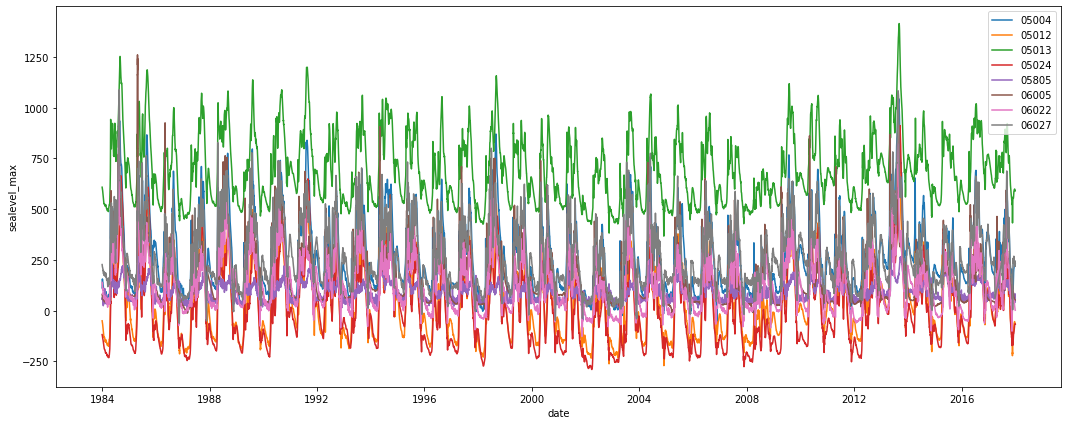

In [9]:
plt.figure(figsize=(18,7))
for grp_name,grp_df in full_df[full_df['identifier'].isin(target_inds)].groupby('identifier'):
    sns.lineplot(grp_df['date'],grp_df['sealevel_max'],label=grp_name)
plt.legend()
plt.show()

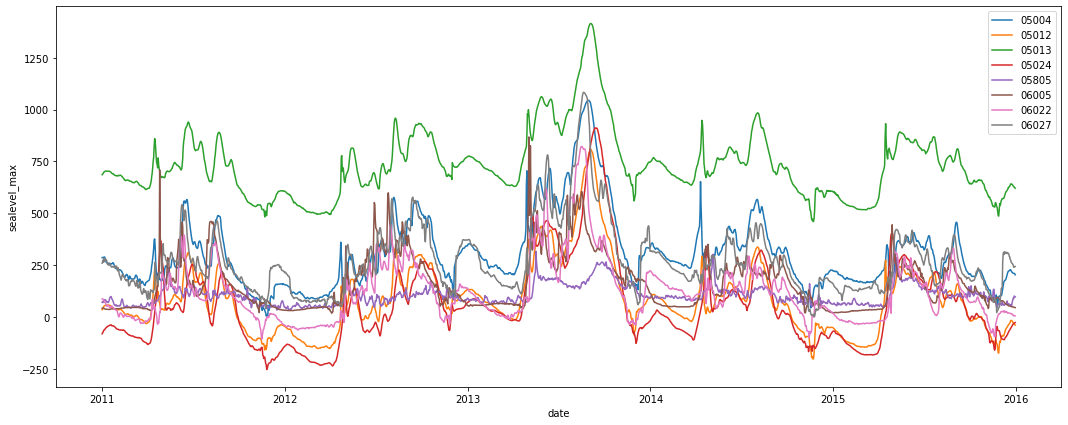

In [10]:
plt.figure(figsize=(18,7))
for grp_name,grp_df in full_df[(full_df['identifier'].isin(target_inds)) & 
            (full_df['date'] >= '2011-01-01') & (full_df['date'] <= '2015-12-31')].groupby('identifier'):
    sns.lineplot(grp_df['date'],grp_df['sealevel_max'],label=grp_name)
plt.legend()
plt.show()

# Уровень воды с течением времени может несущественно линейно изменяться - проверим это, подобрав параметры обычным МНК

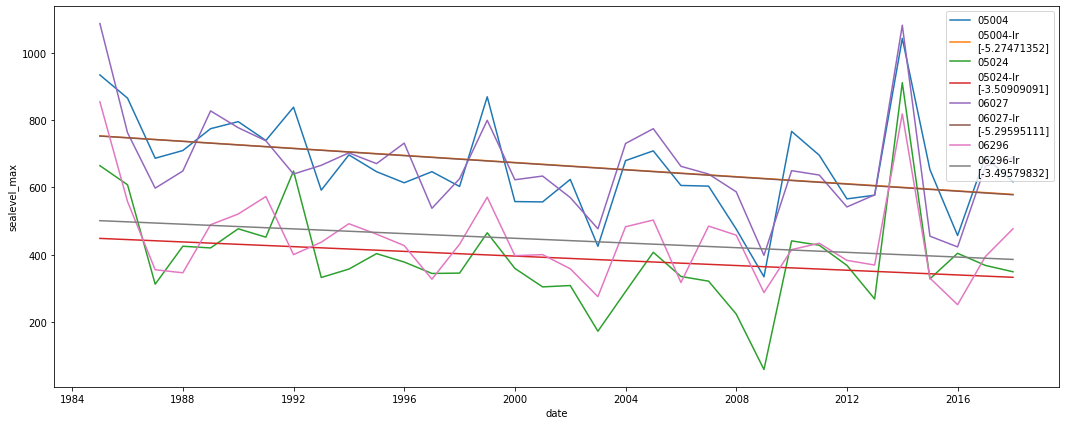

In [11]:
from sklearn.linear_model import LinearRegression

full_df['year'] = full_df['date'].apply(lambda x: x.replace(day=1,month=1))
plt.figure(figsize=(18,7))
month_df = full_df.groupby(['identifier','year']).max().reset_index()
for grp_name,grp_df in month_df[month_df['identifier'].isin(['05004','06027','05024','06296'])].groupby('identifier'):
    sns.lineplot(grp_df['date'],grp_df['sealevel_max'],label=grp_name)
    lr = LinearRegression()
    x = np.array(list(range(len(grp_df)))).reshape(-1,1)
    lr.fit(x,grp_df['sealevel_max'])
    sns.lineplot(grp_df['date'],lr.predict(x),label=grp_name + f'-lr\n{lr.coef_}')
plt.legend()
plt.show()

# Выводы:
* из-за разнородности и большого STD между годами сложно сделать вывод, действительно ли есть тенденция к уменьшению уровня.
* однако множитель у схожих (по корреляционной зависимости) постов очень близкий.

В дальнейшем решено не использовать эту зависимость, так как значения множителей не существенные

05004 1826
05012 1826
05013 1826
05024 1826
05805 1826
06005 1826
06022 1826
06027 1826


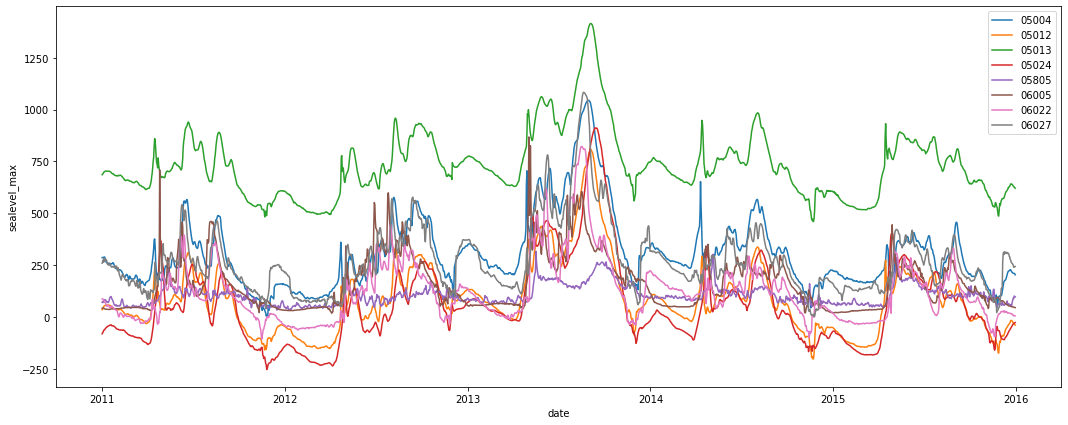

In [12]:
plt.figure(figsize=(18,7))
for grp_name,grp_df in full_df[(full_df['identifier'].isin(target_inds)) & 
            (full_df['date'] >= '2011-01-01') & (full_df['date'] <= '2015-12-31')].groupby('identifier'):
    print(grp_name,len(grp_df['sealevel_max'].dropna()))
    sns.lineplot(grp_df['date'],grp_df['sealevel_max'],label=grp_name)
plt.legend()
plt.show()

# Оценка спектральной плотности

In [13]:
def spectrum1(h, dt=1):
    """
    First cut at spectral estimation: very crude.
    
    Returns frequencies, power spectrum, and
    power spectral density.
    Only positive frequencies between (and not including)
    zero and the Nyquist are output.
    """
    nt = len(h)
    npositive = nt//2
    pslice = slice(1, npositive)
    freqs = np.fft.fftfreq(nt, d=dt)[pslice] 
    ft = np.fft.fft(h)[pslice]
    psraw = np.abs(ft) ** 2
    # Double to account for the energy in the negative frequencies.
    psraw *= 2
    # Normalization for Power Spectrum
    psraw /= nt**2
    # Convert PS to Power Spectral Density
    psdraw = psraw * dt * nt  # nt * dt is record length
    return freqs, psraw, psdraw

def spectrum2(h, dt=1, nsmooth=5):
    """
    Add simple boxcar smoothing to the raw periodogram.
    
    Chop off the ends to avoid end effects.
    """
    freqs, ps, psd = spectrum1(h, dt=dt)
    weights = np.ones(nsmooth, dtype=float) / nsmooth
    ps_s = np.convolve(ps, weights, mode='valid')
    psd_s = np.convolve(psd, weights, mode='valid')
    freqs_s = np.convolve(freqs, weights, mode='valid')
    return freqs_s, ps_s, psd_s

# Метод демодуляции
Метод частотно-фазовой демодуляции позволяет выделить контрольные периодические составляющие. Метод демодуляции исходит из предположения, что амплитуда и фаза периодичских составляющих являются случайными величинами и позволяет с большой степенью точности восстановить исходную периодическую составляющую.

Подробное описание метода можно найти в книге [1].

In [14]:
def mae(x1,x2):
    return np.mean(np.abs(x1-x2))

def mape (x1,x2):
    return np.mean(np.abs((x1-x2)/x1))


def demodul(x, T: int):
    '''
    Метод частотно-фазовой демодуляции для выделения периодических колебаний с периодом T
    Нужен для восстановления периодических составляющих с заданным периодом T из исходного ряда
    :param x: List[float], исходный ряд с наблюдениями
    :param T: int, период колебаний
    :return: tuple:
                  A - восстановленная динамическая амплитуда
                  tetta - восстановленная динамическая фаза
                  demodul - восстановленный ряд

    demodul == A*sin(tetta+(pi*2*T/365))
    '''
    m = int(1 / T)
    omega = T
    sealevelcos = np.array([x[i] * math.cos(omega * i * 2.0 * math.pi) for i in range(len(x))])
    sealevelsin = np.array([x[i] * math.sin(omega * i * 2.0 * math.pi) for i in range(len(x))])
    macos = np.zeros(len(x))
    masin = np.zeros(len(x))
    A = np.zeros(len(x))
    demodul = np.zeros(len(x))
    tetta = np.zeros(len(x))

    for i in range(len(x)):
        if i >= 2 * m - 2:
            a = 0.0
            b = 0.0
            for n, k in enumerate(range(i - 2 * m - 2, i)):
                if k == i - 2 * m - 2 or k == i - 1:
                    a += 0.5 * sealevelcos[k]
                    b += 0.5 * sealevelsin[k]
                elif k < len(x):
                    a += sealevelcos[k]
                    b += sealevelsin[k]
                elif k >= len(x):
                    a += sealevelcos[k - len(x)]
                    b += sealevelsin[k - len(x)]
        else:
            a = 0.0
            b = 0.0
            for n, k in enumerate(range(i, 2 * m + 2 + i)):
                if k == i or k == i + 1 + 2 * m:
                    a += 0.5 * sealevelcos[k]
                    b += 0.5 * sealevelsin[k]
                elif k >= 0:
                    a += sealevelcos[k]
                    b += sealevelsin[k]
                elif k < 0:
                    a += sealevelcos[len(x) + k]
                    b += sealevelsin[len(x) + k]
                    # print(n,2*m+1)
        macos[i] = a / (2 * m + 1)
        masin[i] = b / (2 * m + 1)
        A[i] = 2 * math.sqrt(macos[i] ** 2 + masin[i] ** 2)
        tetta[i] = np.arctan2(masin[i], macos[i])
        demodul[i] = 2.0 * masin[i] * math.sin(i * 2 * math.pi * omega) + 2.0 * macos[i] * math.cos(i * 2 * math.pi * omega)
    return A, tetta, demodul

def level_demodul_365(x):
    x = (x - x.mean()).interpolate(method='linear').fillna(method='bfill').fillna(method='ffill').values
    A,tetta,B = demodul(x,1/365,old=False)
    return B
    
def level_demodul_121(x):
    vals = (x - x.mean()).interpolate(method='linear').fillna(method='bfill').fillna(method='ffill').values
    A,tetta,B = demodul(vals,1/121,old=False)
    return pd.Series(B,index=x.index)

# Продемонстрируем работу метода на двух игрушечных примерах:
<ol>
    <li> накладываются две периодические составляющие с нестационарной амплитудой - периоды 500 и 1137; </li>
    <li> к получившемуся ряду из п.1 добавляется сильный шум с mean=0 и std=10 </li>
</ol>
     
Будем восстанавливать периодическую составляющую с периодом 1137

Метод демодуляции будем вычислять для двух разных вариантов - со смещенной амплитудой (чтобы была возможность моделировать эти ряды в проде, когда будущие измерения нам не известны) и с несмещенной амплитудой. В теории если амплитуда меняется несильно, то результаты со смещенной амплитудой не должны сильно отличаться

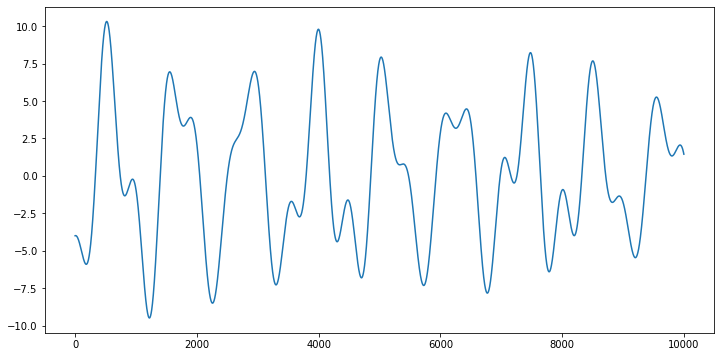

0.3593330169131057


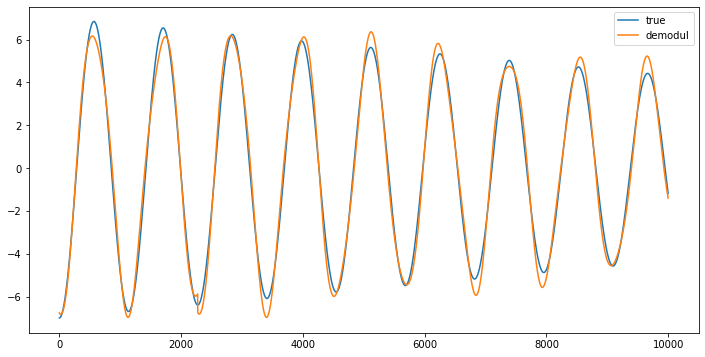

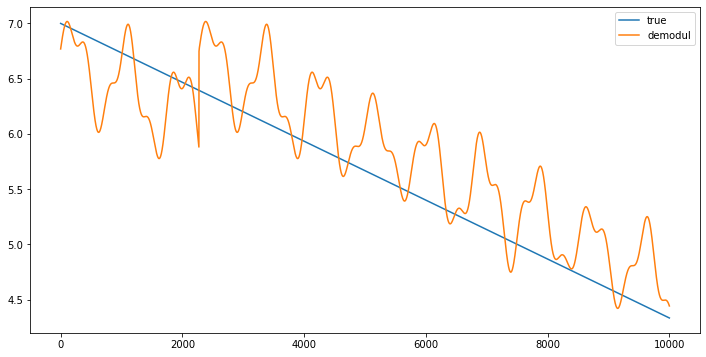

In [15]:
# пример 1
a1 = np.array([3 + math.sin(i*math.pi*2/3400) for i in range(10000)])
a2 = np.array([7 - (2 * i/7500) for i in range(10000)])
x = a1*np.array([np.sin(math.pi/2 + (i*math.pi*2)/500) for i in range(10000)])
x = x + a2*np.array([np.sin(-math.pi/2 + (i*math.pi*2)/1137) for i in range(10000)])
plt.figure(figsize=(12,6))
plt.plot(list(range(len(x))),x)
plt.show()

A,tetta,B = demodul(x,1/1137)
print(mae(a2*np.array([np.sin(-math.pi/2 + (i*math.pi*2)/1137) for i in range(10000)]),B))
plt.figure(figsize=(12,6))
plt.plot(list(range(len(x))),
         a2*np.array([np.sin(-math.pi/2 + (i*math.pi*2)/1137) for i in range(10000)]),label='true')
plt.plot(list(range(len(x))),B,label='demodul')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(list(range(len(x))),
         a2,label='true')
plt.plot(list(range(len(x))),A,label='demodul')
plt.legend()
plt.show()

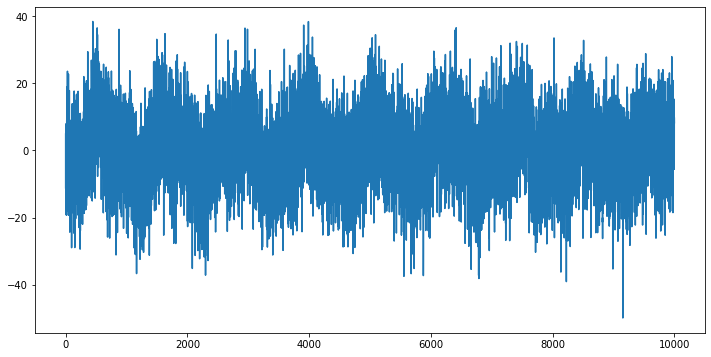

0.45549430372437855


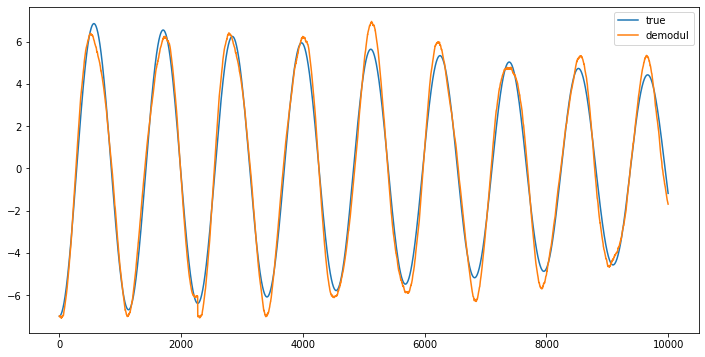

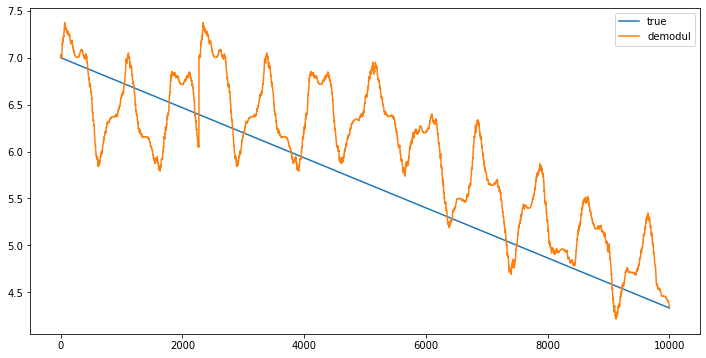

In [16]:
# пример 2
a1 = np.array([3 + math.sin(i*math.pi*2/3400) for i in range(10000)])
a2 = np.array([7 - (2 * i/7500) for i in range(10000)])
x = a1*np.array([np.sin(math.pi/2 + (i*math.pi*2)/500) for i in range(10000)])
x = x + a2*np.array([np.sin(-math.pi/2 + (i*math.pi*2)/1137) for i in range(10000)])
x = x + np.random.normal(scale=10, size=10000)
plt.figure(figsize=(12,6))
plt.plot(list(range(len(x))),x)
plt.show()

A,tetta,B = demodul(x,1/1137)
print(mae(a2*np.array([np.sin(-math.pi/2 + (i*math.pi*2)/1137) for i in range(10000)]),B))
plt.figure(figsize=(12,6))
plt.plot(list(range(len(x))),
         a2*np.array([np.sin(-math.pi/2 + (i*math.pi*2)/1137) for i in range(10000)]),label='true')
plt.plot(list(range(len(x))),B,label='demodul')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(list(range(len(x))),
         a2,label='true')
plt.plot(list(range(len(x))),A,label='demodul')
plt.legend()
plt.show()

# Выводы:
* даже в случае сильно зашумленных наблюдений метод демодуляции восстановить исходную периодическую составляющую, не смотря на то что амплитуда уменьшилась почти в два раза

# Оценка спектральной плотности у исходных рядов

2020-11-20 14:53:47,366 - [INFO] - NumExpr defaulting to 8 threads.
identifier - 05004
Спектральная плотность 205812737.32577866  Частота 0.002737740558821161 Период  365.2647058823529
Спектральная плотность 25942620.699528612  Частота 0.008213221676463482 Период  121.75490196078434
Спектральная плотность 18845797.63699536  Частота 0.0008857395925597873 Период  1129.0
Спектральная плотность 17138860.01536214  Частота 8.052178114179885e-05 Период  12419.0
Спектральная плотность 9832837.05552547  Частота 0.0005636524679925919 Период  1774.1428571428573
Спектральная плотность 7543966.052615368  Частота 0.005475481117642322 Период  182.63235294117646
Спектральная плотность 6081694.729377052  Частота 0.00281826233996296 Период  354.8285714285714
Спектральная плотность 5823558.404538297  Частота 0.0007246960302761897 Период  1379.888888888889
Спектральная плотность 5037333.510391618  Частота 0.0033013930268137527 Период  302.9024390243903
Спектральная плотность 4310264.29160975  Частота 0.00

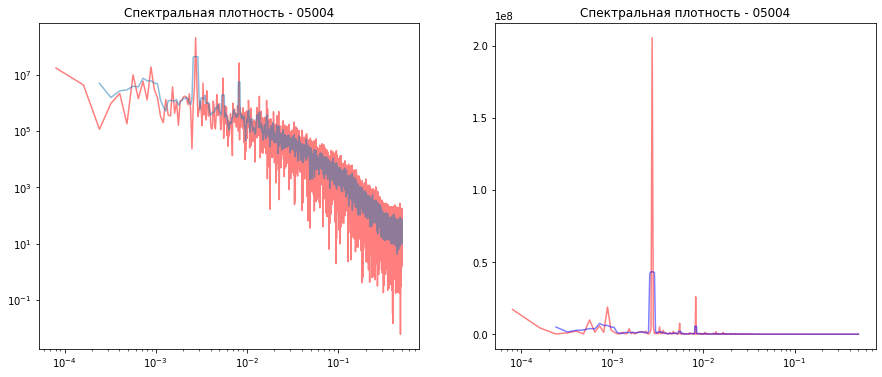

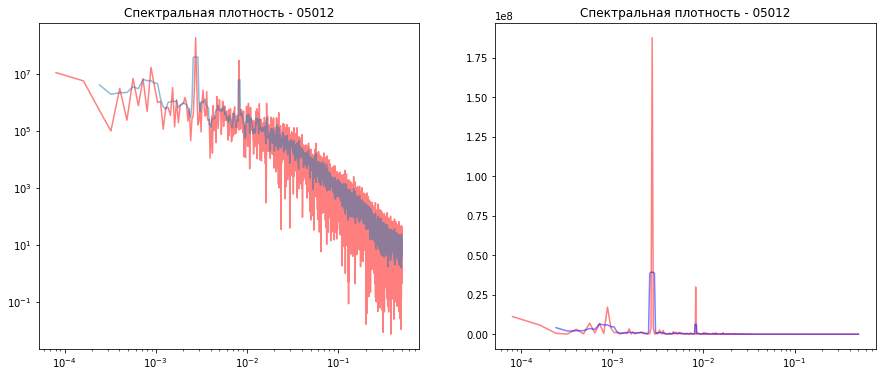

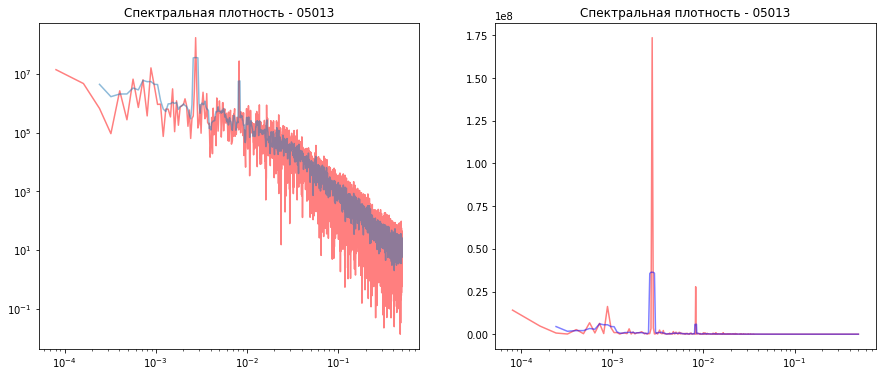

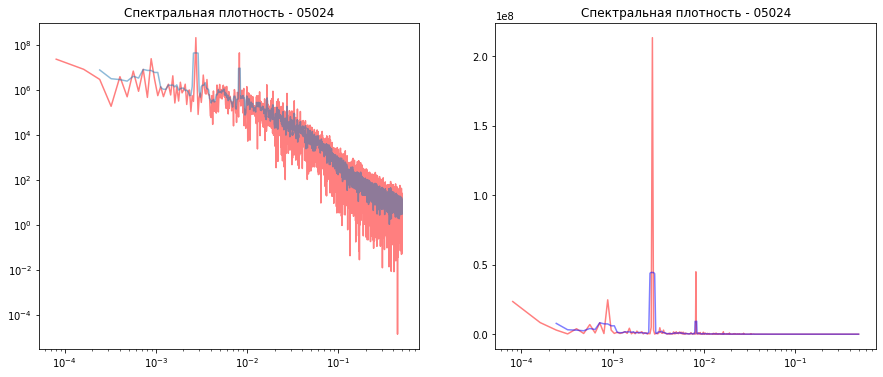

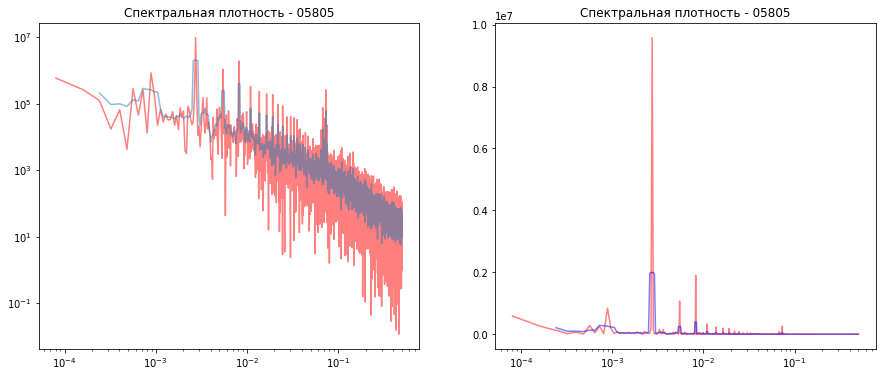

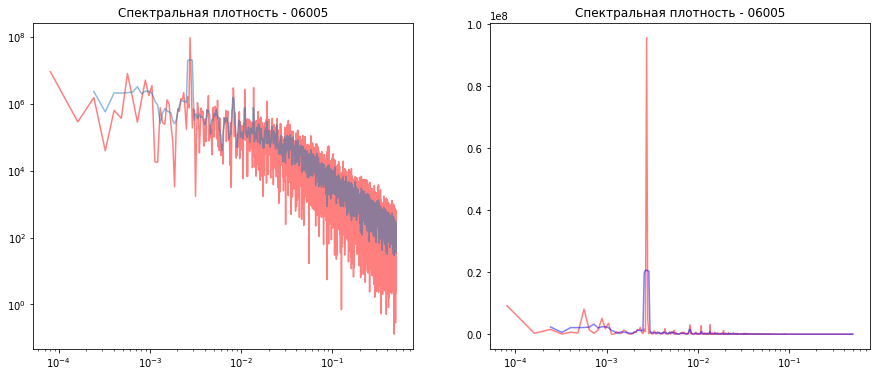

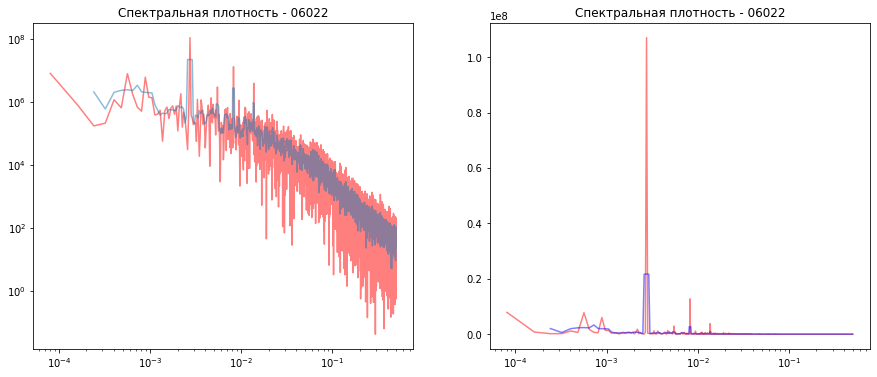

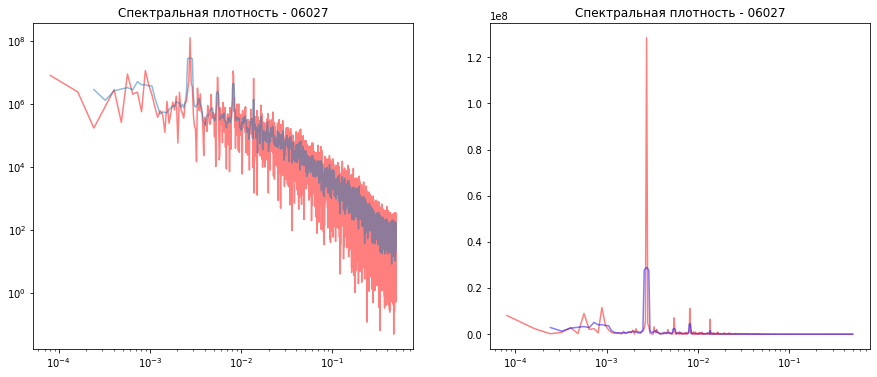

In [17]:
for identifier in target_inds:
    part_df = full_df[full_df['identifier'] == identifier].copy()
    x = (part_df.sort_values('date')['sealevel_max'] - part_df['sealevel_max'].mean()).fillna(method='ffill').values

    freqs1, ps1, psd1 = spectrum1(x, dt=1)
    freqs2, ps2, psd2 = spectrum2(x, dt=1)
    print(f'identifier - {identifier}')
    for i in np.argsort(-psd1)[0:10]:
        print('Спектральная плотность {}  Частота {} Период  {}'.format(psd1[i],freqs1[i],1/freqs1[i]))

    fig, axs = plt.subplots(figsize=(15,6),ncols=2, sharex=True)
    axs[0].loglog(freqs1, psd1, 'r',
                      freqs2, psd2, alpha=0.5)
    axs[0].set_title(f'Спектральная плотность - {identifier}')
    axs[1].plot(freqs1, psd1, 'r',
                      freqs2, psd2, 'b', alpha=0.5)
    axs[1].set_title(f'Спектральная плотность - {identifier}')

# Почти у всех рядов есть две самые сильные периодические составляющие - годовые (связаные с сезонностью) и 4х-месячные.
Попробуем методом демолуяции восстановить годовой и 4хмесячные тренды + попробуем предсказывать годовой тренд простой линейной регрессией

Оценим как сильно меняется исходный ряд при удалении трендов

In [18]:
def delete_year_trend(identifier):
    
    part_df = full_df[full_df['identifier'] == identifier].copy()
    
    x = (part_df.sort_values('date')['sealevel_max'] - part_df['sealevel_max'].mean()).fillna(method='ffill').values

    freqs1, ps1, psd1 = spectrum1(x, dt=1)
    freqs2, ps2, psd2 = spectrum2(x, dt=1)

    for i in np.argsort(-psd1)[0:10]:
        print('Спектральная плотность {}  частота {} период {}'.format(psd1[i],freqs1[i],1/freqs1[i]))

    fig, axs = plt.subplots(figsize=(15,6),ncols=2, sharex=True)
    axs[0].loglog(freqs1, psd1, 'r',
                  freqs2, psd2, alpha=0.5)
    axs[0].set_title('PСпектральная плотность')
    axs[1].plot(freqs1, psd1, 'r',
                  freqs2, psd2, 'b', alpha=0.5)
    axs[1].set_title('Спектральная плотность')
    
    A,tetta,B = demodul(x,1/365)
    omega = np.array(list(range(len(x))))
    part_df['B'] = B
    part_df['A'] = A
    part_df['tetta'] = tetta
    part_df['omega'] = omega
    
    
    plt.figure(figsize=(12,6))
    plt.title('identifier')
    plt.plot(part_df.sort_values('date')['date'],x,label='Исходный уровень')
    plt.plot(part_df.sort_values('date')['date'],B,label='Восстановленный годовой тренд')
    plt.plot(part_df.sort_values('date')['date'],A*np.sin(tetta+math.pi*2*omega/365),label='Восстановленный годовой тренд')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12,6))
    plt.title(f'{identifier}. Амплитуда годовой гармоники')
    plt.plot(part_df.sort_values('date')['date'],A)
    plt.show()
    
    plt.figure(figsize=(12,6))
    plt.title(f'{identifier}. Разность между исходным рядом и восстановленным годовым трендом')
    plt.plot(part_df.sort_values('date')['date'],x-B)
    plt.show()    
    
    freqs1, ps1, psd1 = spectrum1(x-B, dt=1)
    freqs2, ps2, psd2 = spectrum2(x-B, dt=1)

    for i in np.argsort(-psd1)[0:10]:
        print('Спектральная плотность {}  частота {} период {}'.format(psd1[i],freqs1[i],1/freqs1[i]))

    fig, axs = plt.subplots(figsize=(15,6),ncols=2, sharex=True)
    axs[0].loglog(freqs1, psd1, 'r',
                  freqs2, psd2, alpha=0.5)
    axs[0].set_title('Спектральная плотность без годовой гармоники')
    axs[1].plot(freqs1, psd1, 'r',
                  freqs2, psd2, 'b', alpha=0.5)
    axs[1].set_title('Спектральная плотность без годовой гармоники')
    
    all_features = []
    part_df.sort_values('date',inplace=True)
    part_df['doy'] = part_df['date'].apply(lambda x: x.timetuple().tm_yday)
    part_df['doy_sin'] = part_df['doy'].apply(lambda x: math.sin(2*math.pi*x/365))
    #part_df['doy_cos'] = part_df['doy'].apply(lambda x: math.cos(2*math.pi*x/365))
    #all_features = ['doy_sin','doy_cos']
    for shift in range(11,16):
        part_df[f'B_shift_{shift}'] = part_df['B'].shift(shift)
        part_df['shift_tetta'] = part_df['tetta'].shift(shift)
        #part_df[f'A_shift_{shift}'] = part_df['A'].shift(shift)*part_df[['omega','shift_tetta']].apply(lambda x: np.sin(x['shift_tetta']+math.pi*2*x['omega']/365),axis=1)
        #part_df[f'doy_sin_{shift}'] = part_df['doy_sin'].shift(shift)*part_df[f'sealevel_max_shift_{shift}']
        #part_df[f'doy_cos_{shift}'] = part_df['doy_cos'].shift(shift)*part_df[f'sealevel_max_shift_{shift}']
        all_features.extend([f'B_shift_{shift}'])
    print(len(all_features))
    #part_df['B_diff_13_11'] = part_df['B_shift_11'] - part_df['B_shift_13']
    #part_df['B_diff_12_11'] = part_df['B_shift_11'] - part_df['B_shift_12']
    #part_df['B_diff_13_12'] = part_df['B_shift_12'] - part_df['B_shift_13']
    #part_df['B_diff_14_11'] = part_df['B_shift_12'] - part_df['B_shift_14']
    #all_features.extend(['B_diff_13_11','B_diff_12_11','B_diff_13_12','B_diff_14_11'])
    lr = Ridge(alpha=10)
    lr.fit(part_df.iloc[16:10000][all_features],part_df.iloc[16:10000]['B'])
    part_df['pred'] = np.nan
    part_df.loc[part_df.iloc[16:].index,'pred'] = lr.predict(part_df[all_features].iloc[16:])
    
    plt.figure(figsize=(12,6))
    pred = lr.predict(part_df[all_features].iloc[10000:])
    print("MAE {} MAPE {}".format(mae(part_df.iloc[10000:]['B'],pred),mape(part_df.iloc[10000:]['B'],pred)))
    plt.plot(part_df['date'].iloc[10000:],part_df['B'].iloc[10000:],label='B')
    #plt.plot(part_df['date'].iloc[10000:],part_df['B_old'].iloc[10000:],label='B_old')
    plt.plot(part_df['date'].iloc[10000:],pred,label='predict')
    plt.legend()
    plt.show()
    
    
    
    x = ((part_df.sort_values('date')['sealevel_max'] - part_df['sealevel_max'].mean()).fillna(method='ffill') - part_df['B']).values

    freqs1, ps1, psd1 = spectrum1(x, dt=1)
    freqs2, ps2, psd2 = spectrum2(x, dt=1)

    for i in np.argsort(-psd1)[0:10]:
        print('Спектральная плотность {}  частота {} период {}'.format(psd1[i],freqs1[i],1/freqs1[i]))

    fig, axs = plt.subplots(figsize=(15,6),ncols=2, sharex=True)
    axs[0].loglog(freqs1, psd1, 'r',
                  freqs2, psd2, alpha=0.5)
    axs[0].set_title('Спектральная плотность без годовой гармоники')
    axs[1].plot(freqs1, psd1, 'r',
                  freqs2, psd2, 'b', alpha=0.5)
    axs[1].set_title('Спектральная плотность без годовой гармоники')
    
    A,tetta,B = demodul(x,1/121)
    omega = np.array(list(range(len(x))))
    part_df['B'] = B
    part_df['A'] = A
    part_df['tetta'] = tetta
    part_df['omega'] = omega
    
    
    plt.figure(figsize=(12,6))
    plt.title('identifier')
    plt.plot(part_df.sort_values('date')['date'],x,label='Исходный уровень')
    plt.plot(part_df.sort_values('date')['date'],B,label='Восстановленный 4х-месячный тренд')
    plt.plot(part_df.sort_values('date')['date'],A*np.sin(tetta+math.pi*2*omega/121),label='Восстановленный годовой тdренд')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12,6))
    plt.title(f'{identifier}. Амплитуда 4хмесячной гармоники')
    plt.plot(part_df.sort_values('date')['date'],A)
    plt.show()
    
    plt.figure(figsize=(12,6))
    plt.title(f'{identifier}. Разность между рядом без годового тренда \nи восстановленным 4хмесячным трендом')
    plt.plot(part_df.sort_values('date')['date'],x-B)
    plt.show()    
    
    freqs1, ps1, psd1 = spectrum1(x-B, dt=1)
    freqs2, ps2, psd2 = spectrum2(x-B, dt=1)

    for i in np.argsort(-psd1)[0:10]:
        print('Спектральная плотность {}  частота {} период {}'.format(psd1[i],freqs1[i],1/freqs1[i]))

    fig, axs = plt.subplots(figsize=(15,6),ncols=2, sharex=True)
    axs[0].loglog(freqs1, psd1, 'r',
                  freqs2, psd2, alpha=0.5)
    axs[0].set_title('Спектральная плотность без годовой и 4хмесячной гармоник')
    axs[1].plot(freqs1, psd1, 'r',
                  freqs2, psd2, 'b', alpha=0.5)
    axs[1].set_title('Спектральная плотность без годовой и 4хмесячной гармоник')
    
    all_features = []
    part_df.sort_values('date',inplace=True)
    part_df['doy'] = part_df['date'].apply(lambda x: x.timetuple().tm_yday)
    part_df['doy_sin'] = part_df['doy'].apply(lambda x: math.sin(2*math.pi*x/365))
    #part_df['doy_cos'] = part_df['doy'].apply(lambda x: math.cos(2*math.pi*x/365))
    #all_features = ['doy_sin','doy_cos']
    for shift in range(11,16):
        part_df[f'B_shift_{shift}'] = part_df['B'].shift(shift)
        part_df['shift_tetta'] = part_df['tetta'].shift(shift)
        #part_df[f'A_shift_{shift}'] = part_df['A'].shift(shift)*part_df[['omega','shift_tetta']].apply(lambda x: np.sin(x['shift_tetta']+math.pi*2*x['omega']/365),axis=1)
        #part_df[f'doy_sin_{shift}'] = part_df['doy_sin'].shift(shift)*part_df[f'sealevel_max_shift_{shift}']
        #part_df[f'doy_cos_{shift}'] = part_df['doy_cos'].shift(shift)*part_df[f'sealevel_max_shift_{shift}']
        all_features.extend([f'B_shift_{shift}'])
    print(len(all_features))
    #part_df['B_diff_13_11'] = part_df['B_shift_11'] - part_df['B_shift_13']
    #part_df['B_diff_12_11'] = part_df['B_shift_11'] - part_df['B_shift_12']
    #part_df['B_diff_13_12'] = part_df['B_shift_12'] - part_df['B_shift_13']
    #part_df['B_diff_14_11'] = part_df['B_shift_12'] - part_df['B_shift_14']
    #all_features.extend(['B_diff_13_11','B_diff_12_11','B_diff_13_12','B_diff_14_11'])
    lr = Ridge(alpha=10)
    lr.fit(part_df.iloc[16:10000][all_features],part_df.iloc[16:10000]['B'])
    part_df['pred'] = np.nan
    part_df.loc[part_df.iloc[16:].index,'pred'] = lr.predict(part_df[all_features].iloc[16:])
    
    plt.figure(figsize=(12,6))
    pred = lr.predict(part_df[all_features].iloc[10000:])
    print("MAE {} MAPE {}".format(mae(part_df.iloc[10000:]['B'],pred),mape(part_df.iloc[10000:]['B'],pred)))
    plt.plot(part_df['date'].iloc[10000:],part_df['B'].iloc[10000:],label='B')
    #plt.plot(part_df['date'].iloc[10000:],part_df['B_old'].iloc[10000:],label='B_old')
    plt.plot(part_df['date'].iloc[10000:],pred,label='predict')
    plt.legend()
    plt.show() 
    part_df['filtered_signal'] = x-B+ part_df['sealevel_max'].mean()

    plt.figure(figsize=(12,6))
    plt.title(f'Уровень и демодулированный уровень - {identifier}')
    plt.plot(part_df[(part_df['date'] >= '2011-01-01') & 
                     (part_df['date'] <= '2016-12-31')]['date'],
                     part_df[(part_df['date'] >= '2011-01-01') & 
                        (part_df['date'] <= '2016-12-31')]['sealevel_max'],label='Исходный уровень')
    plt.plot(part_df[(part_df['date'] >= '2011-01-01') & 
                     (part_df['date'] <= '2016-12-31')]['date'],
                     part_df[(part_df['date'] >= '2011-01-01') & 
                        (part_df['date'] <= '2016-12-31')]['filtered_signal'],label='Уровень без годовой и 4хмесячной гармоник')
    plt.legend()
    plt.show()

    
    part_df['year'] = part_df['date'].apply(lambda x: x.replace(day=1,month=1))
    mean_std = part_df.groupby(['year'])['sealevel_max'].std().mean()
    filtered_mean_std = part_df.groupby(['year'])['filtered_signal'].std().mean()
    print(f'STD of max level before {mean_std}\nSTD of max level after filtering {filtered_mean_std}')
    
    return part_df

Спектральная плотность 82145233.73545659  частота 0.002737740558821161 период 365.2647058823529
Спектральная плотность 22978493.05498567  частота 0.008213221676463482 период 121.75490196078434
Спектральная плотность 14959548.420296554  частота 0.0008857395925597873 период 1129.0
Спектральная плотность 14581748.714441469  частота 0.005475481117642322 период 182.63235294117646
Спектральная плотность 11825141.165549321  частота 8.052178114179885e-05 период 12419.0
Спектральная плотность 8033222.132314834  частота 0.0005636524679925919 период 1774.1428571428573
Спектральная плотность 7150673.396512255  частота 0.00281826233996296 период 354.8285714285714
Спектральная плотность 5544866.275654395  частота 0.0009662613737015862 период 1034.9166666666667
Спектральная плотность 5206685.094799066  частота 0.0001610435622835977 период 6209.5
Спектральная плотность 4719574.308939465  частота 0.0033013930268137527 период 302.9024390243903


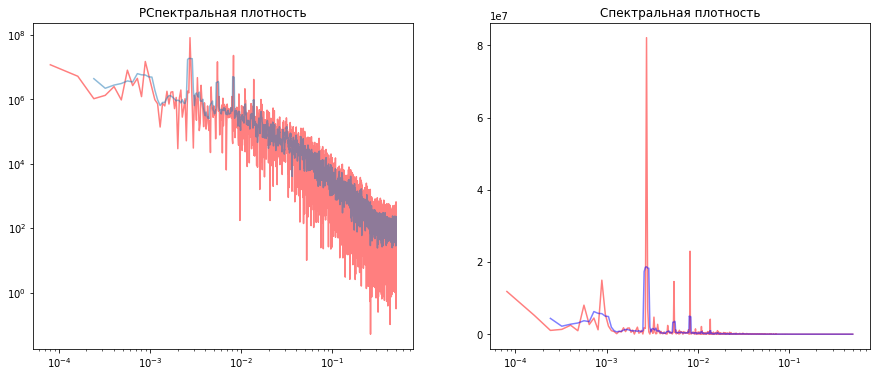

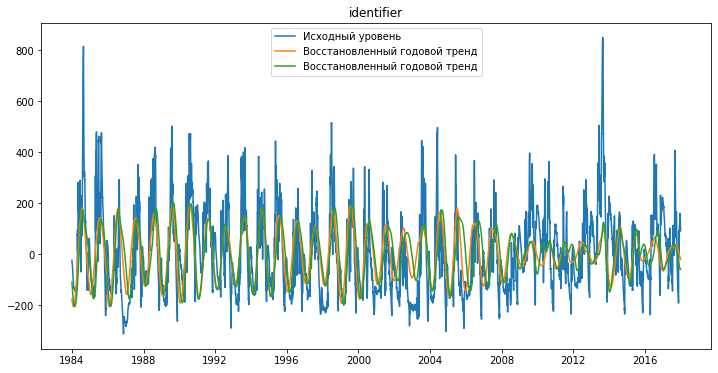

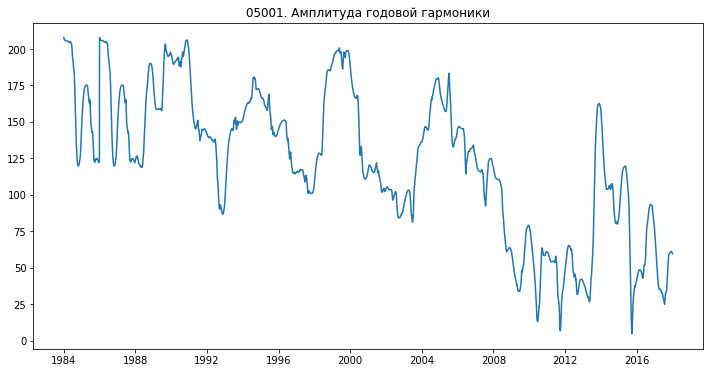

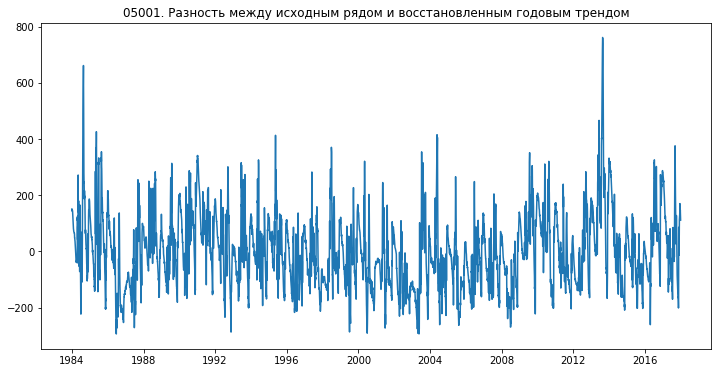

Спектральная плотность 23144044.885635838  частота 0.008213221676463482 период 121.75490196078434
Спектральная плотность 14965107.95551404  частота 0.005475481117642322 период 182.63235294117646
Спектральная плотность 13516283.70149742  частота 0.0008857395925597873 период 1129.0
Спектральная плотность 12337546.695431584  частота 8.052178114179885e-05 период 12419.0
Спектральная плотность 8583549.86226782  частота 0.0005636524679925919 период 1774.1428571428573
Спектральная плотность 5019514.52737048  частота 0.0001610435622835977 период 6209.5
Спектральная плотность 5011126.181644206  частота 0.0036234801513809482 период 275.9777777777778
Спектральная плотность 4738402.7313984595  частота 0.0007246960302761897 период 1379.888888888889
Спектральная плотность 4669861.131179236  частота 0.0009662613737015862 период 1034.9166666666667
Спектральная плотность 4031392.2715233727  частота 0.013688702794105804 период 73.0529411764706
5
MAE 1.8560162123334571 MAPE 0.3800324988336635


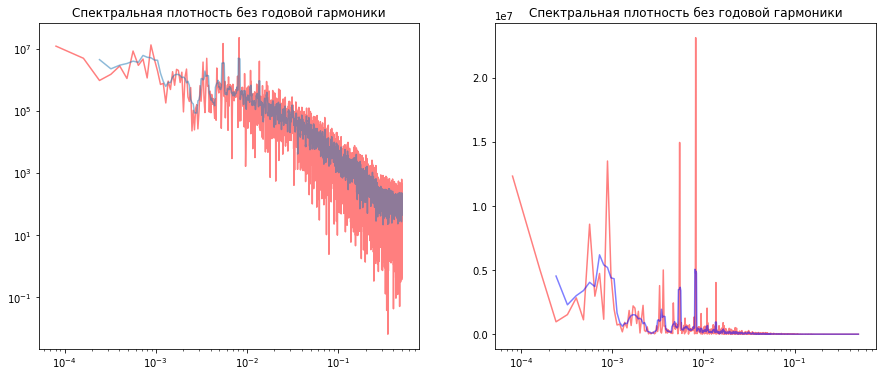

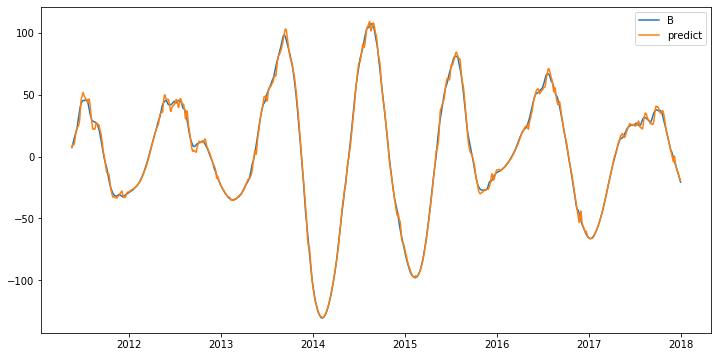

Спектральная плотность 23144044.885635838  частота 0.008213221676463482 период 121.75490196078434
Спектральная плотность 14965107.95551404  частота 0.005475481117642322 период 182.63235294117646
Спектральная плотность 13516283.70149742  частота 0.0008857395925597873 период 1129.0
Спектральная плотность 12337546.695431584  частота 8.052178114179885e-05 период 12419.0
Спектральная плотность 8583549.86226782  частота 0.0005636524679925919 период 1774.1428571428573
Спектральная плотность 5019514.52737048  частота 0.0001610435622835977 период 6209.5
Спектральная плотность 5011126.181644206  частота 0.0036234801513809482 период 275.9777777777778
Спектральная плотность 4738402.7313984595  частота 0.0007246960302761897 период 1379.888888888889
Спектральная плотность 4669861.131179236  частота 0.0009662613737015862 период 1034.9166666666667
Спектральная плотность 4031392.2715233727  частота 0.013688702794105804 период 73.0529411764706


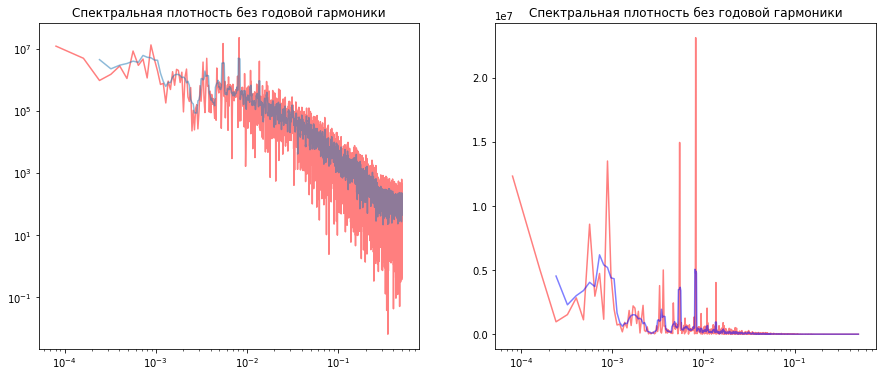

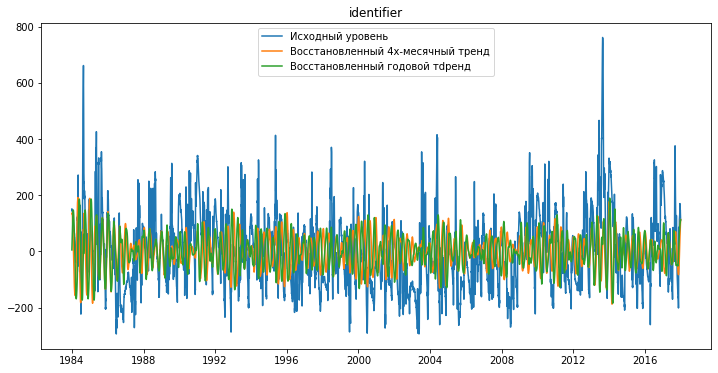

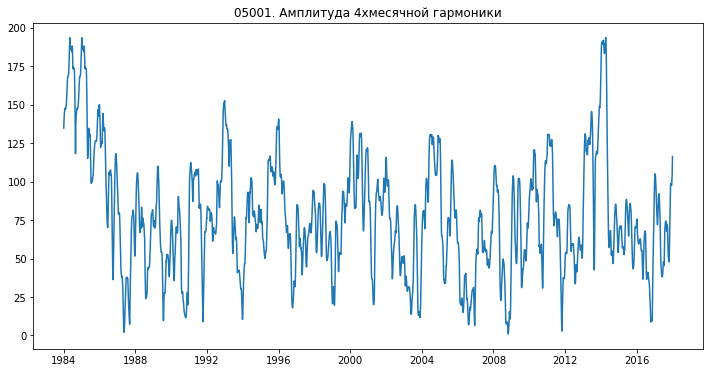

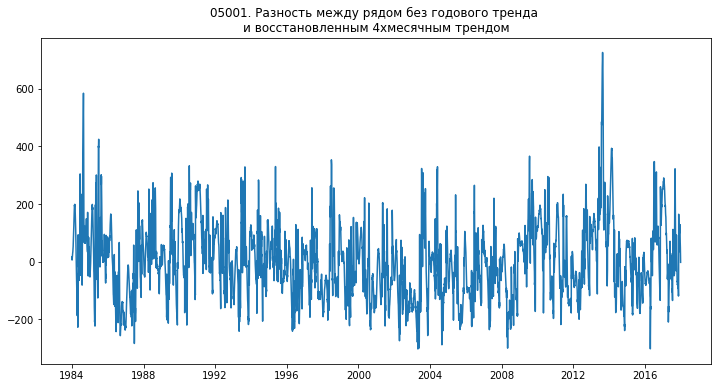

Спектральная плотность 22435266.87582166  частота 0.005475481117642322 период 182.63235294117646
Спектральная плотность 14042569.011926275  частота 0.0008857395925597873 период 1129.0
Спектральная плотность 12262727.271566883  частота 8.052178114179885e-05 период 12419.0
Спектральная плотность 8765813.724393405  частота 0.0005636524679925919 период 1774.1428571428573
Спектральная плотность 4914967.027923751  частота 0.0009662613737015862 период 1034.9166666666667
Спектральная плотность 4890593.566395899  частота 0.0001610435622835977 период 6209.5
Спектральная плотность 4877719.58876829  частота 0.0007246960302761897 период 1379.888888888889
Спектральная плотность 4428452.154743853  частота 0.0036234801513809482 период 275.9777777777778
Спектральная плотность 3681275.093126373  частота 0.010950962235284644 период 91.31617647058823
Спектральная плотность 3384744.123570777  частота 0.0033013930268137527 период 302.9024390243903
5
MAE 5.3096118241207195 MAPE 1.6543827430260534


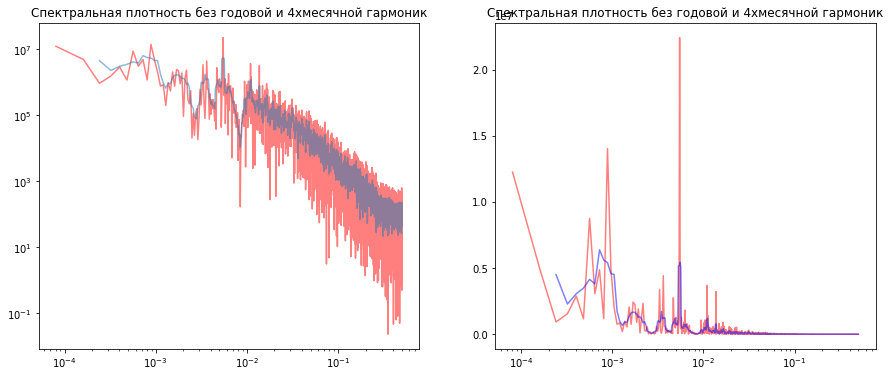

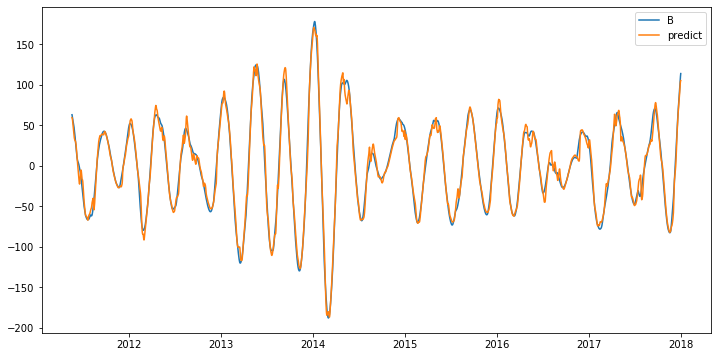

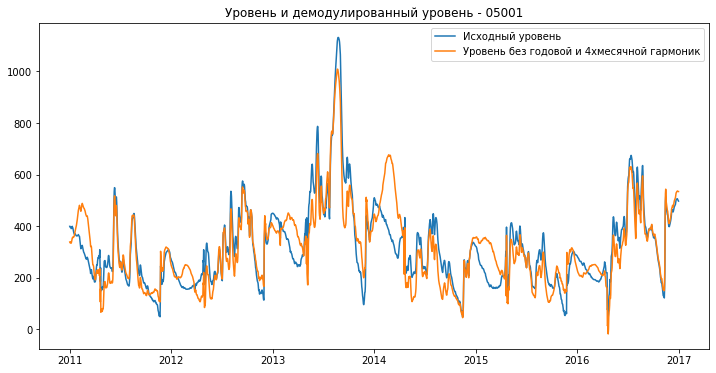

STD of max level before 139.82729754164097
STD of max level after filtering 109.67673724926524


In [19]:
part_df = delete_year_trend('05001')

Спектральная плотность 213520003.443442  частота 0.002737740558821161 период 365.2647058823529
Спектральная плотность 44909612.3682671  частота 0.008213221676463482 период 121.75490196078434
Спектральная плотность 24732526.401043367  частота 0.0008857395925597873 период 1129.0
Спектральная плотность 23500706.339480616  частота 8.052178114179885e-05 период 12419.0
Спектральная плотность 8335093.692354771  частота 0.0001610435622835977 период 6209.5
Спектральная плотность 8201418.3974173125  частота 0.0007246960302761897 период 1379.888888888889
Спектральная плотность 6924073.85831707  частота 0.0005636524679925919 период 1774.1428571428573
Спектральная плотность 5023095.988342591  частота 0.002657218777679362 период 376.33333333333337
Спектральная плотность 4622909.497515339  частота 0.0033013930268137527 период 302.9024390243903
Спектральная плотность 4270613.191301538  частота 0.0015299138416941783 период 653.6315789473684


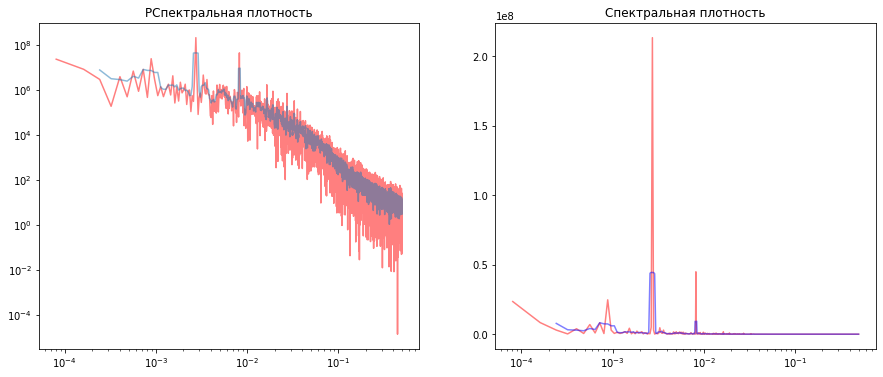

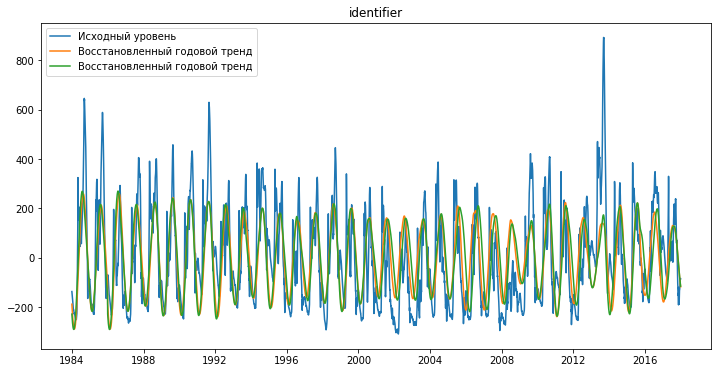

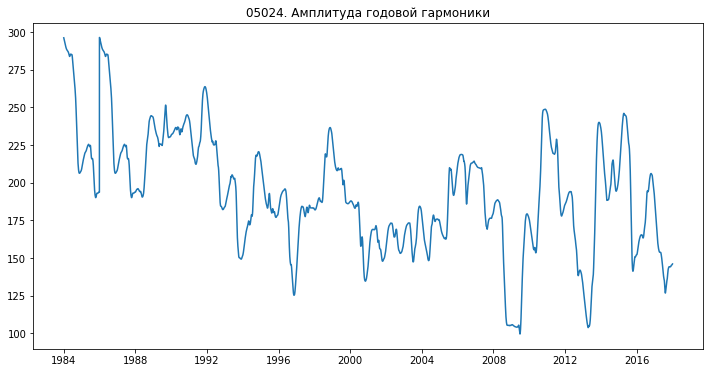

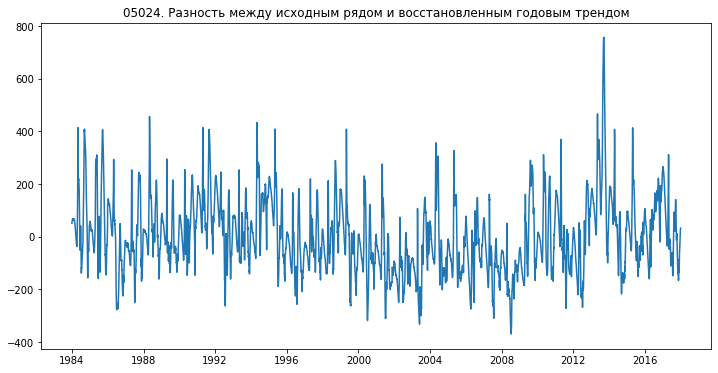

Спектральная плотность 44743167.40798844  частота 0.008213221676463482 период 121.75490196078434
Спектральная плотность 24877972.60170004  частота 8.052178114179885e-05 период 12419.0
Спектральная плотность 22219464.363280576  частота 0.0008857395925597873 период 1129.0
Спектральная плотность 8682888.488395326  частота 0.0007246960302761897 период 1379.888888888889
Спектральная плотность 8004544.959757339  частота 0.0001610435622835977 период 6209.5
Спектральная плотность 7561046.276571136  частота 0.0005636524679925919 период 1774.1428571428573
Спектральная плотность 5143766.099040821  частота 0.0036234801513809482 период 275.9777777777778
Спектральная плотность 4612785.668681624  частота 0.0033013930268137527 период 302.9024390243903
Спектральная плотность 4536146.196604271  частота 0.0004026089057089943 период 2483.8
Спектральная плотность 4377334.238751528  частота 0.0015299138416941783 период 653.6315789473684
5
MAE 1.5401744239295254 MAPE 0.08673897673427512


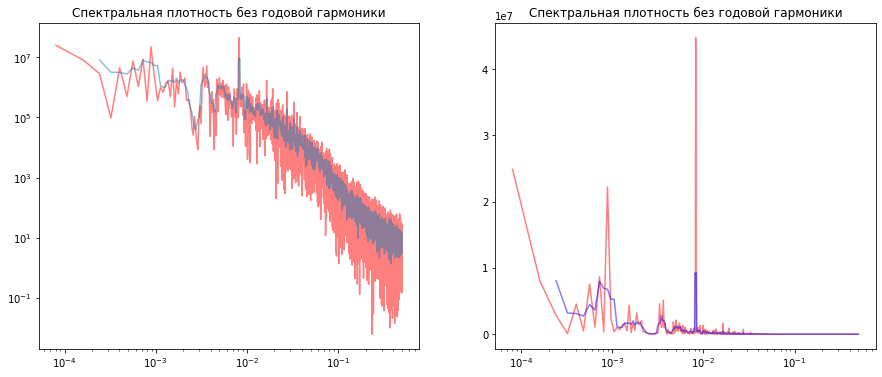

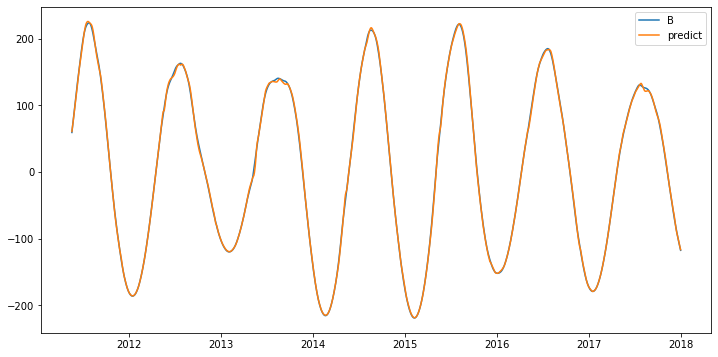

Спектральная плотность 44743167.40798844  частота 0.008213221676463482 период 121.75490196078434
Спектральная плотность 24877972.60170004  частота 8.052178114179885e-05 период 12419.0
Спектральная плотность 22219464.363280576  частота 0.0008857395925597873 период 1129.0
Спектральная плотность 8682888.488395326  частота 0.0007246960302761897 период 1379.888888888889
Спектральная плотность 8004544.959757339  частота 0.0001610435622835977 период 6209.5
Спектральная плотность 7561046.276571136  частота 0.0005636524679925919 период 1774.1428571428573
Спектральная плотность 5143766.099040821  частота 0.0036234801513809482 период 275.9777777777778
Спектральная плотность 4612785.668681624  частота 0.0033013930268137527 период 302.9024390243903
Спектральная плотность 4536146.196604271  частота 0.0004026089057089943 период 2483.8
Спектральная плотность 4377334.238751528  частота 0.0015299138416941783 период 653.6315789473684


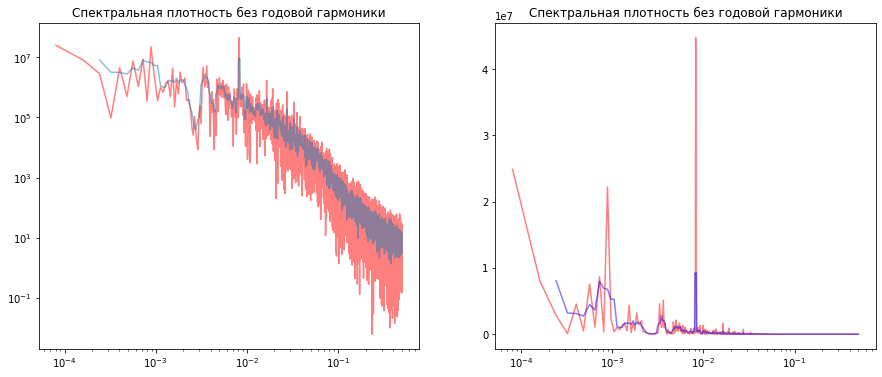

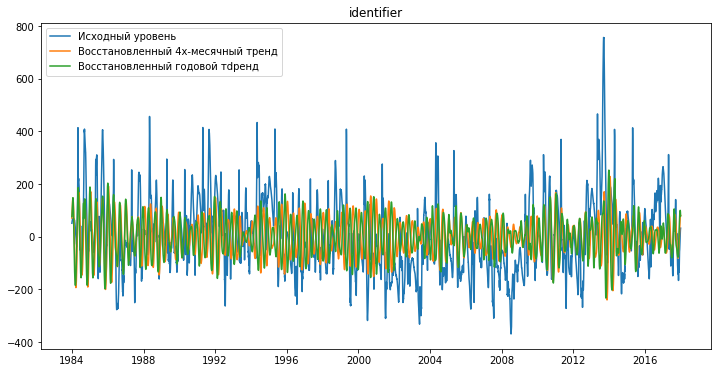

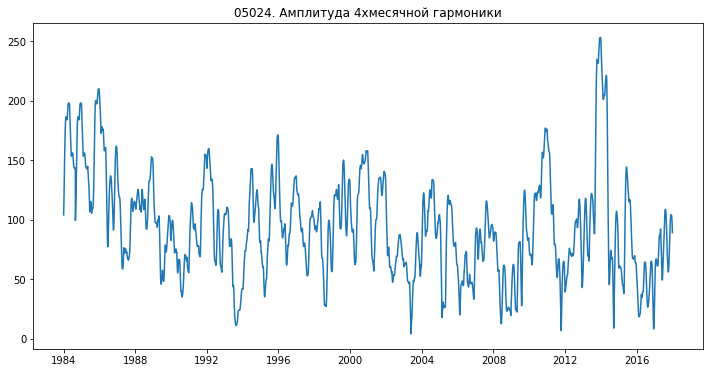

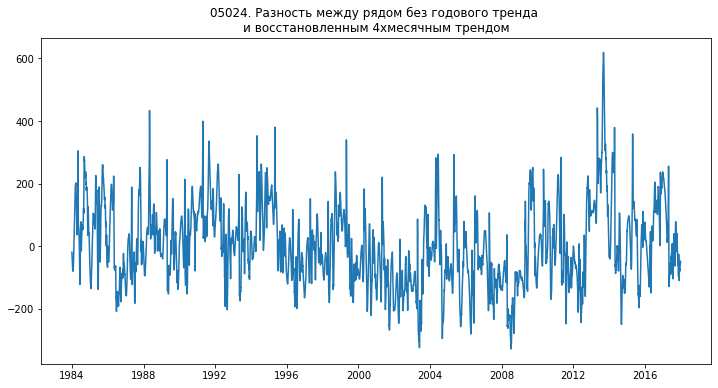

Спектральная плотность 24483668.24393007  частота 8.052178114179885e-05 период 12419.0
Спектральная плотность 23264944.24168419  частота 0.0008857395925597873 период 1129.0
Спектральная плотность 8853450.909926571  частота 0.0007246960302761897 период 1379.888888888889
Спектральная плотность 7881914.356780535  частота 0.0001610435622835977 период 6209.5
Спектральная плотность 7689852.389545013  частота 0.0005636524679925919 период 1774.1428571428573
Спектральная плотность 4827962.177324675  частота 0.0015299138416941783 период 653.6315789473684
Спектральная плотность 4545825.321978143  частота 0.0004026089057089943 период 2483.8
Спектральная плотность 4533784.0845559705  частота 0.0036234801513809482 период 275.9777777777778
Спектральная плотность 4021569.7982764477  частота 0.0033013930268137527 период 302.9024390243903
Спектральная плотность 3483825.2269849847  частота 0.0018520009662613736 период 539.9565217391305
5
MAE 3.974425176356314 MAPE 0.2633958453822942


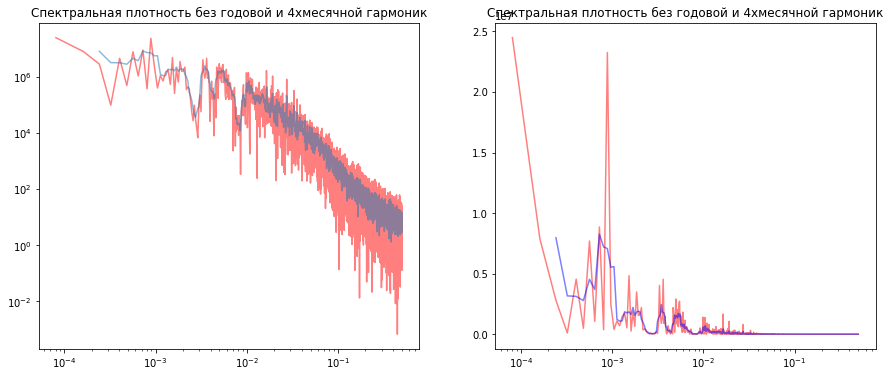

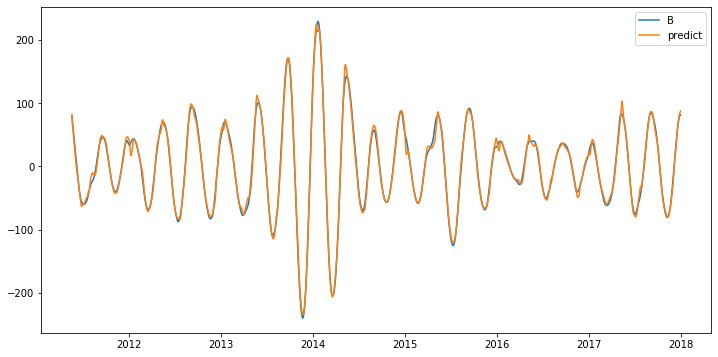

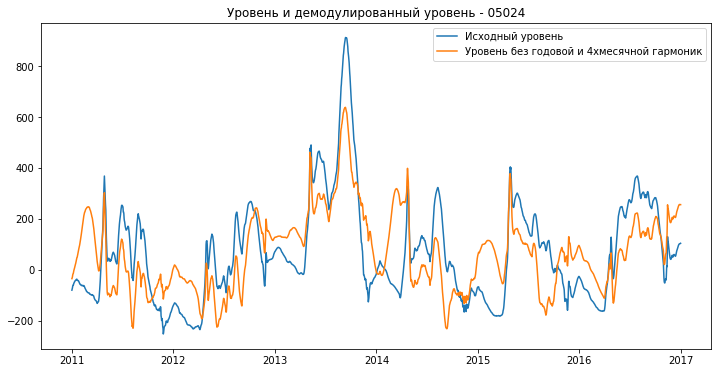

STD of max level before 170.71223771448945
STD of max level after filtering 98.45961924129651


In [20]:
part_df = delete_year_trend('05024')

Спектральная плотность 128482552.71236266  частота 0.0027512542482602364 период 363.4705882352941
Спектральная плотность 11582398.619367061  частота 0.0008901116685547824 период 1123.4545454545455
Спектральная плотность 11208379.573989313  частота 0.008172843502184819 период 122.35643564356437
Спектральная плотность 8960619.435473619  частота 0.0005664346981712251 период 1765.4285714285713
Спектральная плотность 8100458.581240539  частота 8.09192425958893e-05 период 12358.0
Спектральная плотность 7551205.858469022  частота 0.008253762744780709 период 121.15686274509804
Спектральная плотность 7067593.268870994  частота 0.005502508496520473 период 181.73529411764704
Спектральная плотность 6491304.844126457  частота 0.013675351998705293 период 73.12426035502958
Спектральная плотность 5485159.969330039  частота 0.002670335005664347 период 374.4848484848485
Спектральная плотность 4539803.0268867565  частота 0.0028321734908561256 период 353.0857142857143


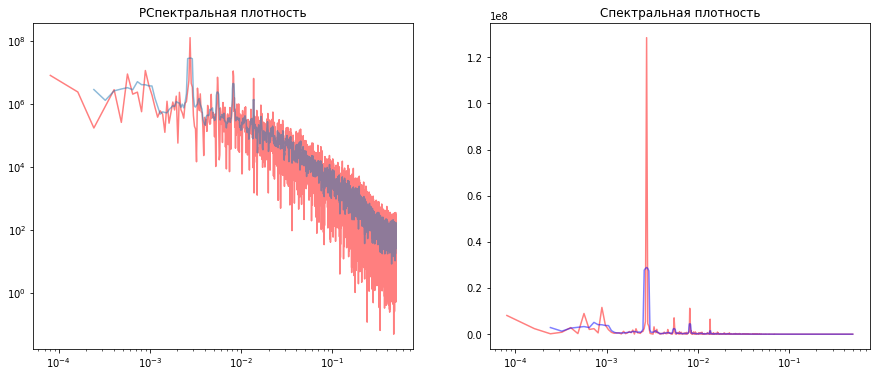

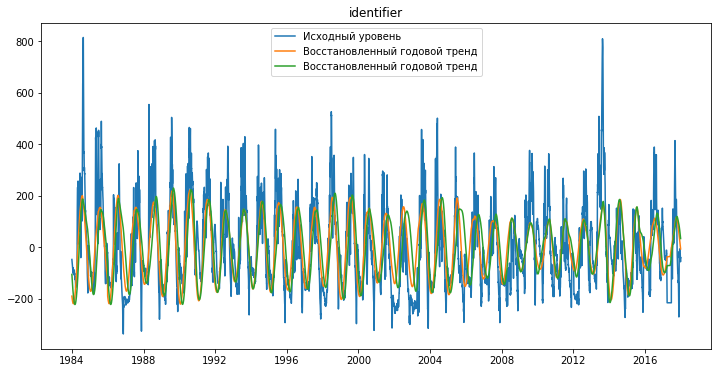

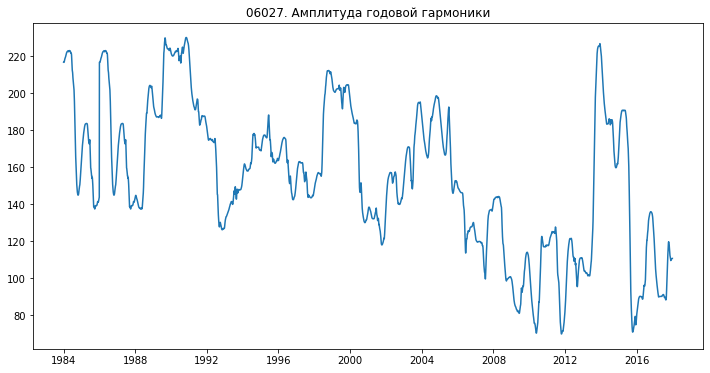

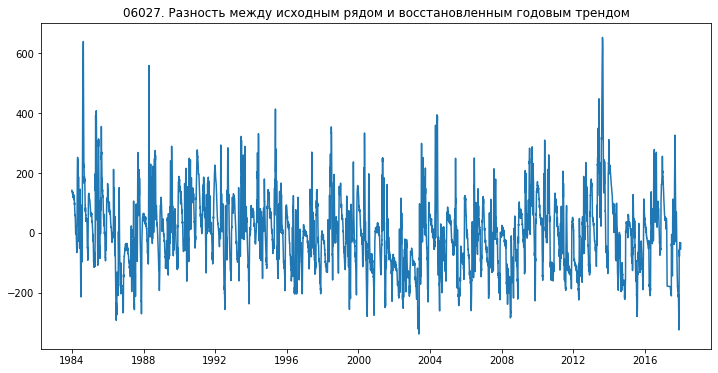

Спектральная плотность 10918341.772474563  частота 0.008172843502184819 период 122.35643564356437
Спектральная плотность 10722882.671055095  частота 0.0008901116685547824 период 1123.4545454545455
Спектральная плотность 9388718.659229565  частота 0.0005664346981712251 период 1765.4285714285713
Спектральная плотность 8231337.370726601  частота 8.09192425958893e-05 период 12358.0
Спектральная плотность 7919716.024751747  частота 0.008253762744780709 период 121.15686274509804
Спектральная плотность 7710485.828533538  частота 0.005502508496520473 период 181.73529411764704
Спектральная плотность 6299583.153193883  частота 0.013675351998705293 период 73.12426035502958
Спектральная плотность 3381638.3306133826  частота 0.0009710309111506716 период 1029.8333333333333
Спектральная плотность 3130241.83487103  частота 0.005583427739116362 период 179.1014492753623
Спектральная плотность 3050996.374295914  частота 0.0004045962129794465 период 2471.6000000000004
5
MAE 1.8700106064212008 MAPE 0.09194

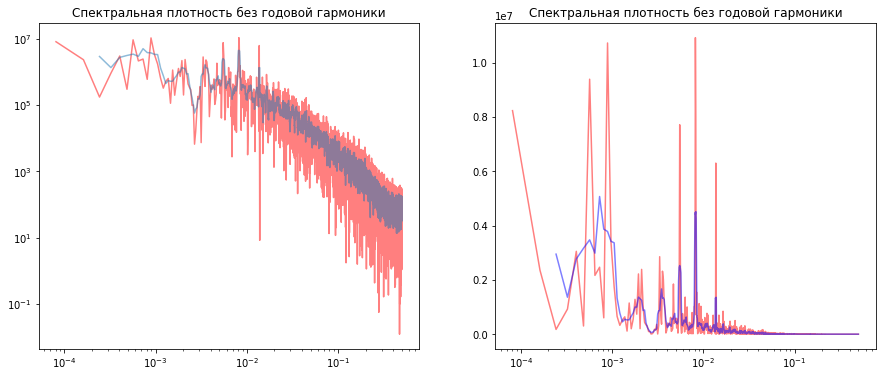

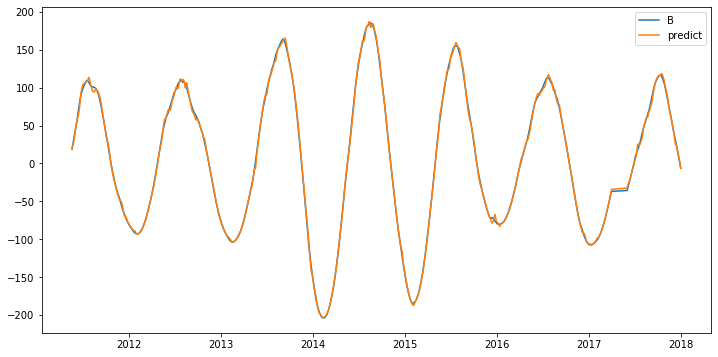

Спектральная плотность 10918341.772474563  частота 0.008172843502184819 период 122.35643564356437
Спектральная плотность 10722882.671055095  частота 0.0008901116685547824 период 1123.4545454545455
Спектральная плотность 9388718.659229565  частота 0.0005664346981712251 период 1765.4285714285713
Спектральная плотность 8231337.370726601  частота 8.09192425958893e-05 период 12358.0
Спектральная плотность 7919716.024751747  частота 0.008253762744780709 период 121.15686274509804
Спектральная плотность 7710485.828533538  частота 0.005502508496520473 период 181.73529411764704
Спектральная плотность 6299583.153193883  частота 0.013675351998705293 период 73.12426035502958
Спектральная плотность 3381638.3306133826  частота 0.0009710309111506716 период 1029.8333333333333
Спектральная плотность 3130241.83487103  частота 0.005583427739116362 период 179.1014492753623
Спектральная плотность 3050996.374295914  частота 0.0004045962129794465 период 2471.6000000000004


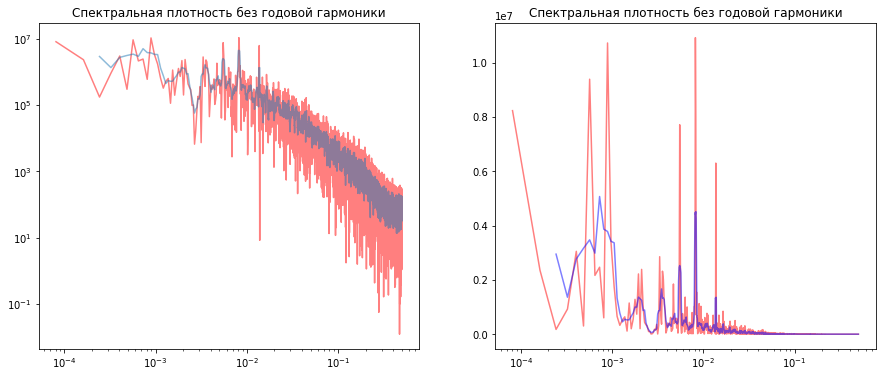

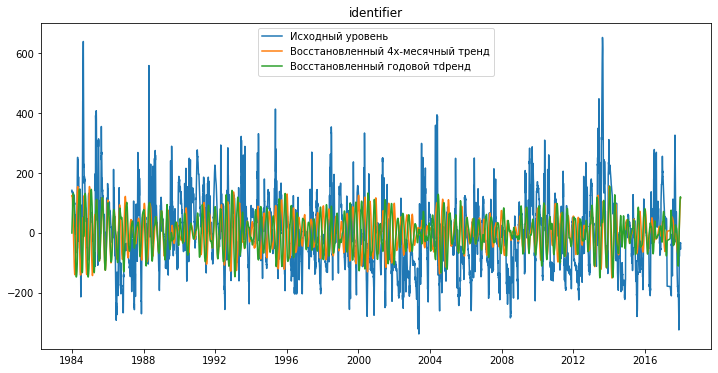

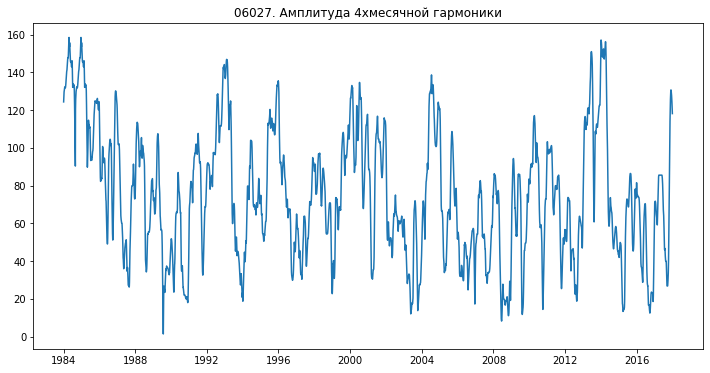

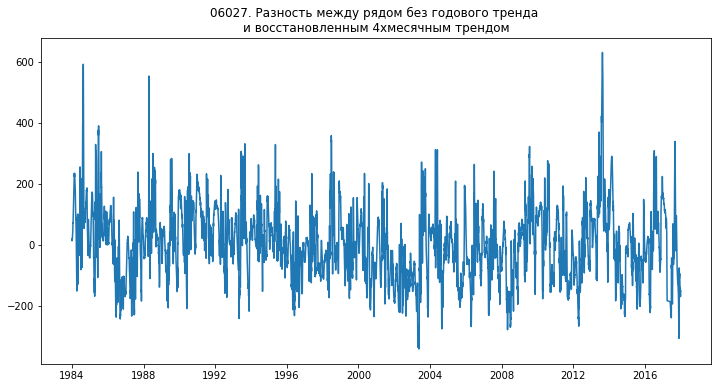

Спектральная плотность 11138024.361440053  частота 0.0008901116685547824 период 1123.4545454545455
Спектральная плотность 11043706.466679037  частота 0.005502508496520473 период 181.73529411764704
Спектральная плотность 9535634.382822912  частота 0.0005664346981712251 период 1765.4285714285713
Спектральная плотность 8151594.567739817  частота 8.09192425958893e-05 период 12358.0
Спектральная плотность 5059256.317010586  частота 0.013675351998705293 период 73.12426035502958
Спектральная плотность 4397065.224685573  частота 0.005583427739116362 период 179.1014492753623
Спектральная плотность 3548297.3508184263  частота 0.0009710309111506716 период 1029.8333333333333
Спектральная плотность 3077829.145418539  частота 0.0004045962129794465 период 2471.6000000000004
Спектральная плотность 2553922.695790518  частота 0.0007282731833630037 период 1373.111111111111
Спектральная плотность 2546977.183874262  частота 0.0033176889464314615 период 301.4146341463415
5
MAE 5.214215496405218 MAPE 0.68950

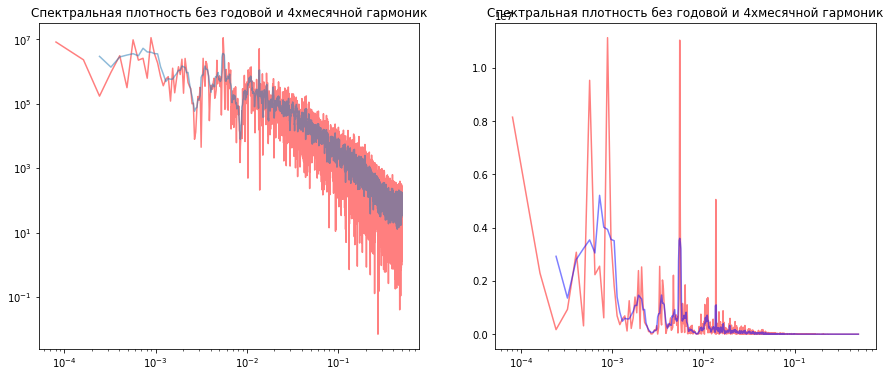

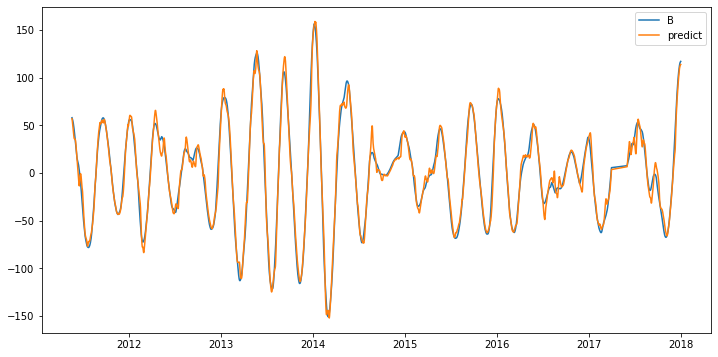

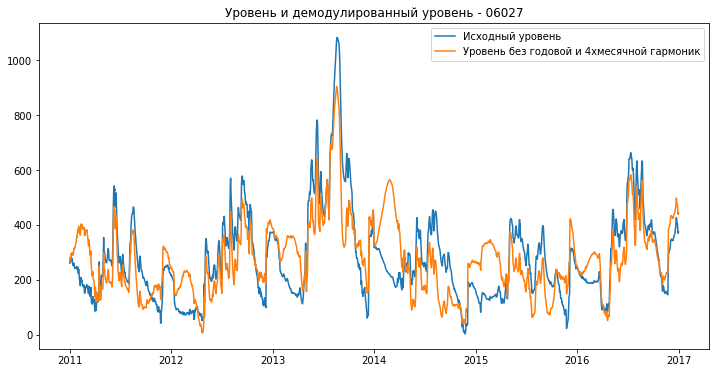

STD of max level before 148.1629967478385
STD of max level after filtering 100.1868538047331


In [21]:
part_df = delete_year_trend('06027')

Спектральная плотность 95644289.71199208  частота 0.002751031636863824 период 363.5
Спектральная плотность 9208878.110414248  частота 8.091269520187717e-05 период 12359.0
Спектральная плотность 8049272.998513994  частота 0.0005663888664131402 период 1765.571428571429
Спектральная плотность 5128620.731668043  частота 0.0008900396472206488 период 1123.5454545454547
Спектральная плотность 4804615.327410126  частота 0.002831944332065701 период 353.1142857142857
Спектральная плотность 3535412.2825110205  частота 0.0010518650376244033 период 950.6923076923076
Спектральная плотность 3044159.709383744  частота 0.013674245489117241 период 73.1301775147929
Спектральная плотность 3006990.4345672796  частота 0.008172182215389595 период 122.36633663366337
Спектральная плотность 2707460.276628193  частота 0.010923213852253418 период 91.54814814814816
Спектральная плотность 2564905.487198084  частота 0.008253094910591471 период 121.16666666666667


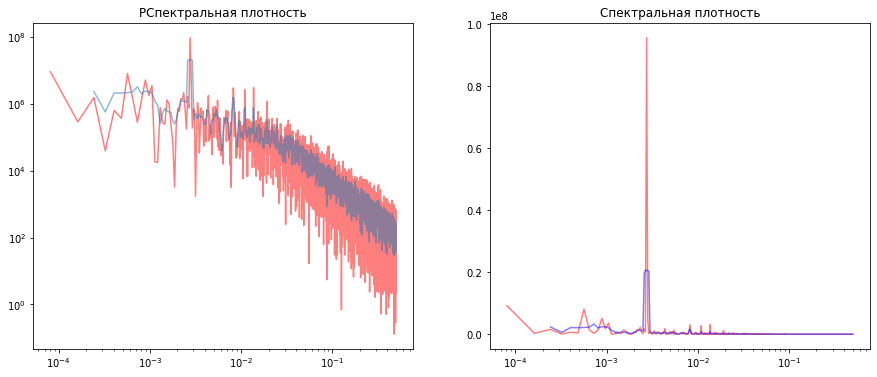

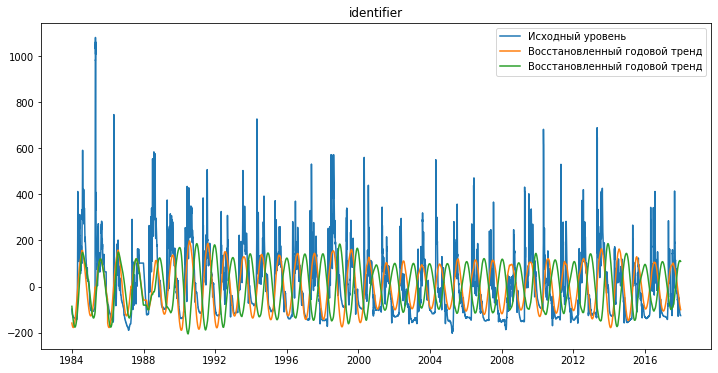

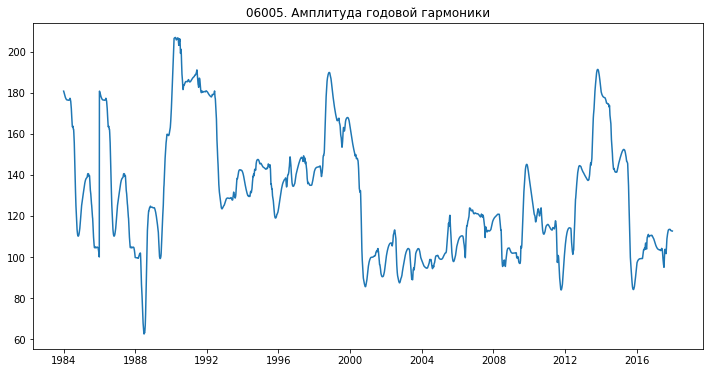

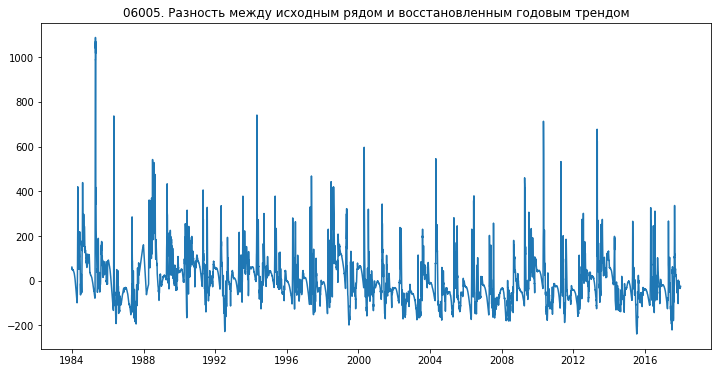

Спектральная плотность 9218627.489389792  частота 8.091269520187717e-05 период 12359.0
Спектральная плотность 8749722.426144676  частота 0.0005663888664131402 период 1765.571428571429
Спектральная плотность 4575054.98775264  частота 0.0008900396472206488 период 1123.5454545454547
Спектральная плотность 3307493.564507891  частота 0.008172182215389595 период 122.36633663366337
Спектральная плотность 2993008.685482229  частота 0.013674245489117241 период 73.1301775147929
Спектральная плотность 2868244.2540876567  частота 0.0010518650376244033 период 950.6923076923076
Спектральная плотность 2706046.3485374646  частота 0.010923213852253418 период 91.54814814814816
Спектральная плотность 2352690.8969313954  частота 0.008253094910591471 период 121.16666666666667
Спектральная плотность 1627533.239553678  частота 0.0006473015616150174 период 1544.875
Спектральная плотность 1549279.643615537  частота 0.0009709523424225261 период 1029.9166666666667
5
MAE 2.1167760527410775 MAPE 0.0839716803604730

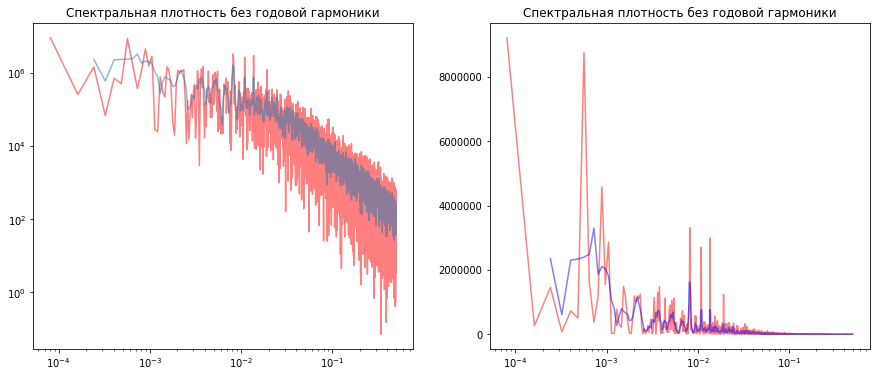

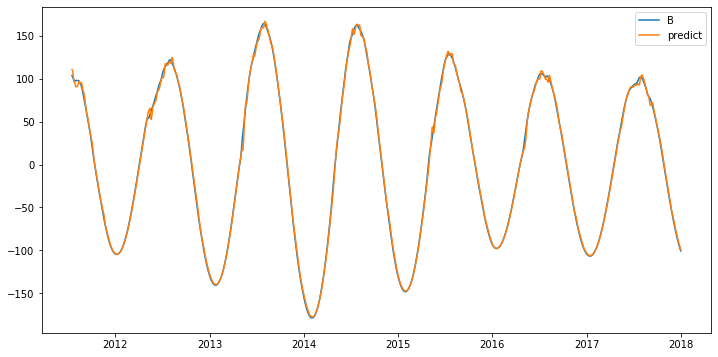

Спектральная плотность 9218627.489389792  частота 8.091269520187717e-05 период 12359.0
Спектральная плотность 8749722.426144676  частота 0.0005663888664131402 период 1765.571428571429
Спектральная плотность 4575054.98775264  частота 0.0008900396472206488 период 1123.5454545454547
Спектральная плотность 3307493.564507891  частота 0.008172182215389595 период 122.36633663366337
Спектральная плотность 2993008.685482229  частота 0.013674245489117241 период 73.1301775147929
Спектральная плотность 2868244.2540876567  частота 0.0010518650376244033 период 950.6923076923076
Спектральная плотность 2706046.3485374646  частота 0.010923213852253418 период 91.54814814814816
Спектральная плотность 2352690.8969313954  частота 0.008253094910591471 период 121.16666666666667
Спектральная плотность 1627533.239553678  частота 0.0006473015616150174 период 1544.875
Спектральная плотность 1549279.643615537  частота 0.0009709523424225261 период 1029.9166666666667


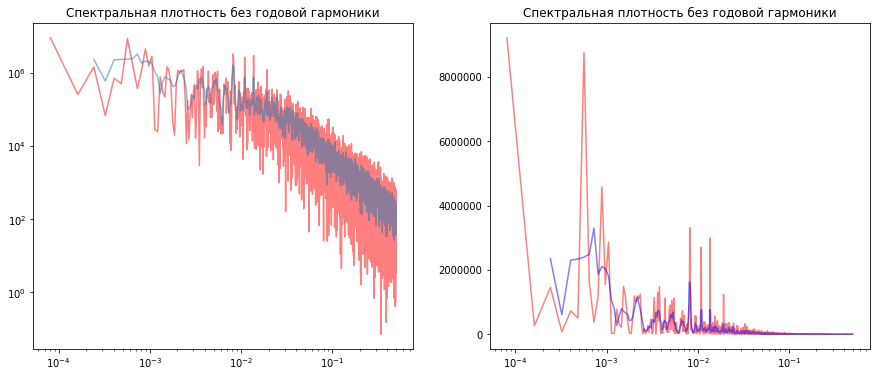

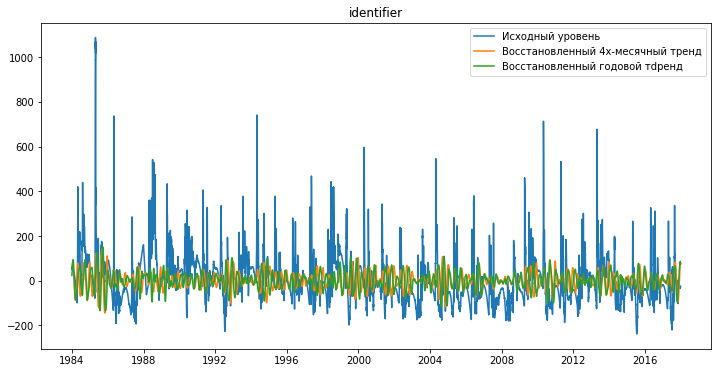

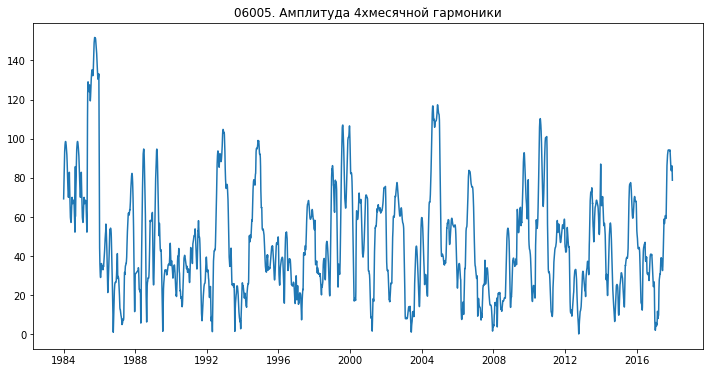

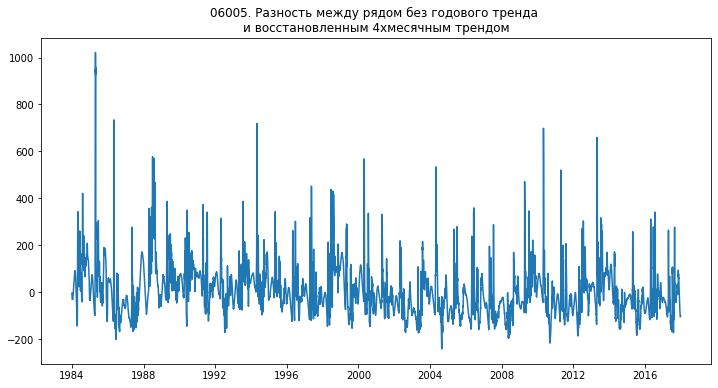

Спектральная плотность 9052404.428705068  частота 8.091269520187717e-05 период 12359.0
Спектральная плотность 8815255.558113288  частота 0.0005663888664131402 период 1765.571428571429
Спектральная плотность 4768126.442881698  частота 0.0008900396472206488 период 1123.5454545454547
Спектральная плотность 4651722.312295328  частота 0.010923213852253418 период 91.54814814814816
Спектральная плотность 3050396.1148705482  частота 0.0010518650376244033 период 950.6923076923076
Спектральная плотность 2342390.376853445  частота 0.013674245489117241 период 73.1301775147929
Спектральная плотность 1721130.130048876  частота 0.005502063273727648 период 181.75
Спектральная плотность 1643102.4422548006  частота 0.0006473015616150174 период 1544.875
Спектральная плотность 1620631.2218543966  частота 0.0009709523424225261 период 1029.9166666666667
Спектральная плотность 1610204.4676707918  частота 0.0015373412088356662 период 650.4736842105264
5
MAE 4.344388225038448 MAPE 0.8855262752897146


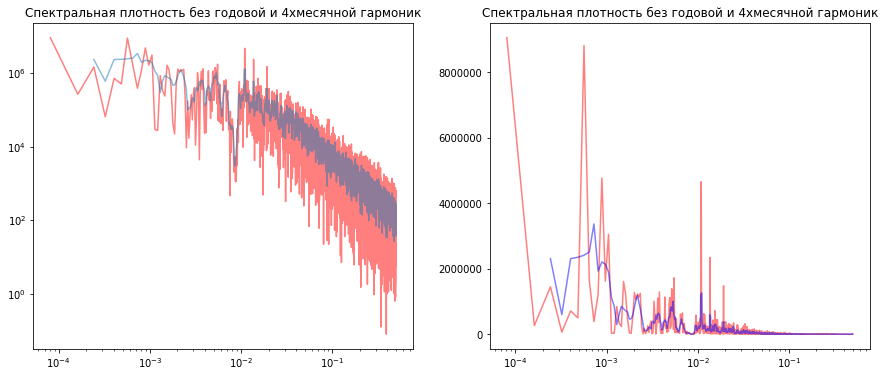

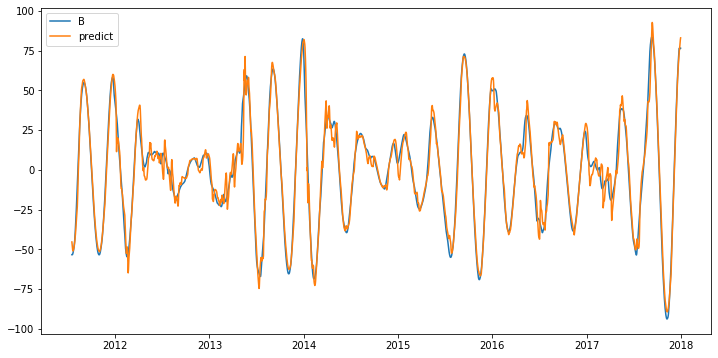

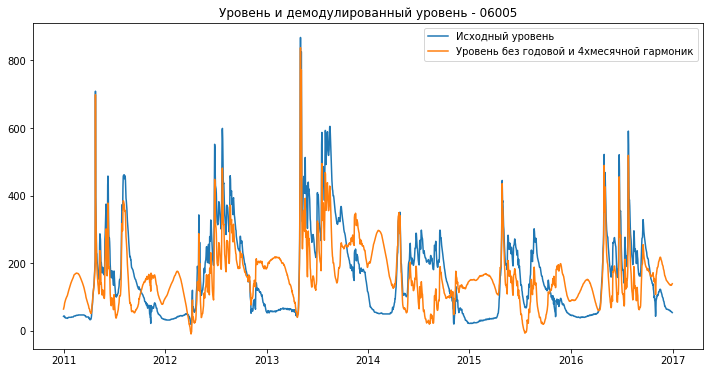

STD of max level before 126.14459895048306
STD of max level after filtering 88.04324881061534


In [22]:
part_df = delete_year_trend('06005')

C:\Users\dmitriy.raevskiy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\dmitriy.raevskiy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'Демодулированный уровень')

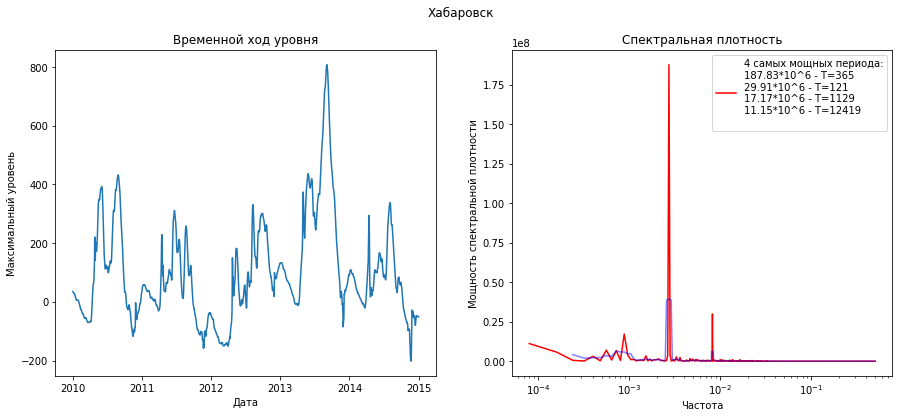

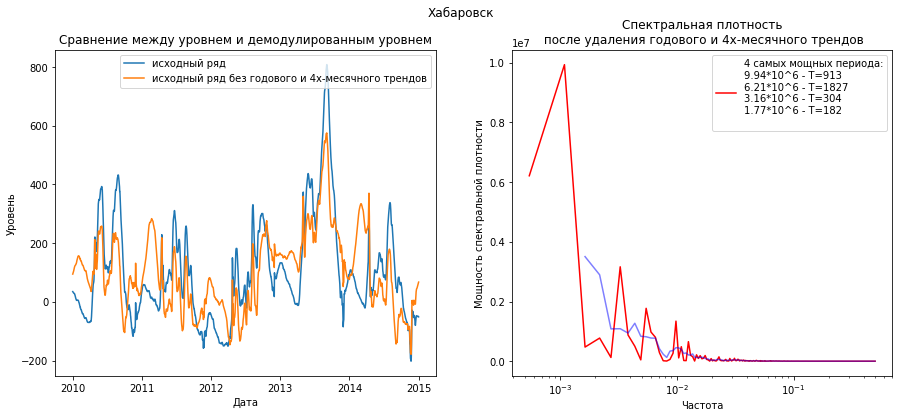

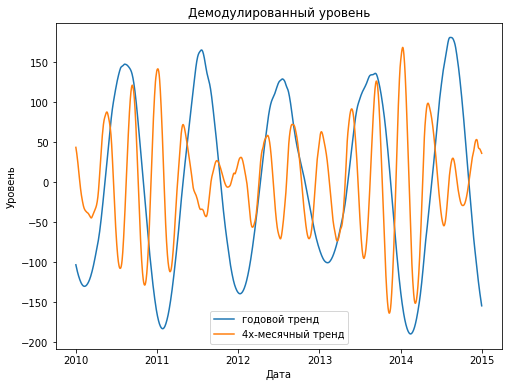

In [23]:
# отдельно для хабаровска - чтобы взять в презентацию

part_df = full_df[(full_df['identifier'] == '05012')]

x = (part_df.sort_values('date')['sealevel_max'] - part_df['sealevel_max'].mean()).fillna(method='ffill').values

freqs1, ps1, psd1 = spectrum1(x, dt=1)
freqs2, ps2, psd2 = spectrum2(x, dt=1)
label_str = '4 самых мощных периода:\n'
for i in np.argsort(-psd1)[0:4]:
    label_str += f'{psd1[i]/10**6:.2f}*10^6 - T={int(1/freqs1[i])}\n'

A,tetta,B = demodul(x,1/365)
part_df['B_365'] = B

x = ((part_df.sort_values('date')['sealevel_max'] - part_df['sealevel_max'].mean()).fillna(method='ffill') - part_df['B_365']).values

A,tetta,B = demodul(x,1/121)
part_df['B_121'] = B

part_df = part_df[(part_df['date'] >= '2010-01-01') & (part_df['date'] <= '2015-01-01')]


fig, axs = plt.subplots(figsize=(15,6),ncols=2)
plt.suptitle('Хабаровск')
axs[1].plot(freqs1, psd1, 'r',label=label_str)
axs[1].plot(freqs2, psd2, 'b', alpha=0.5)
axs[1].legend()
axs[1].set_title('Спектральная плотность')
axs[1].set_xscale('log')
axs[1].set_xlabel('Частота')
axs[1].set_ylabel('Мощность спектральной плотности')

axs[0].plot(part_df['date'],
            part_df['sealevel_max'])
axs[0].set_xlabel('Дата')
axs[0].set_ylabel('Максимальный уровень')
axs[0].set_title('Временной ход уровня')


x = ((part_df.sort_values('date')['sealevel_max'] - part_df['sealevel_max'].mean()).fillna(method='ffill') - part_df['B_365'] - part_df['B_121']).values
freqs1, ps1, psd1 = spectrum1(x, dt=1)
freqs2, ps2, psd2 = spectrum2(x, dt=1)

label_str = '4 самых мощных периода:\n'
for i in np.argsort(-psd1)[0:4]:
    label_str += f'{psd1[i]/10**6:.2f}*10^6 - T={int(1/freqs1[i])}\n'

fig, axs = plt.subplots(figsize=(15,6),ncols=2)
plt.suptitle('Хабаровск')
axs[1].plot(freqs1, psd1, 'r',label=label_str)
axs[1].plot(freqs2, psd2, 'b', alpha=0.5)
axs[1].legend()
axs[1].set_title('Спектральная плотность\n после удаления годового и 4х-месячного трендов')
axs[1].set_xscale('log')
axs[1].set_xlabel('Частота')
axs[1].set_ylabel('Мощность спектральной плотности')

axs[0].plot(part_df['date'],
            part_df['sealevel_max'],label='исходный ряд')
axs[0].plot(part_df['date'],
            part_df['sealevel_max']-part_df['B_365']-part_df['B_121'],label='исходный ряд без годового и 4х-месячного трендов')
axs[0].set_xlabel('Дата')
axs[0].set_ylabel('Уровень')
axs[0].legend()
axs[0].set_title('Сравнение между уровнем и демодулированным уровнем')

plt.figure(figsize=(8,6))
plt.plot(part_df['date'],
            part_df['B_365'],label='годовой тренд')
plt.plot(part_df['date'],
            part_df['B_121'],label='4х-месячный тренд')
plt.xlabel('Дата')
plt.ylabel('Уровень')
plt.legend()
plt.title('Демодулированный уровень')

# Выводы о применимости метода демодуляции:
* метод демодуляции адекватно отфильтровывает периодические составляющие (4,12 месяцев) - спектральная плотность на соответствующих частотах почти нулевая;

<b>Решение: полученные коэффициенты тренда можно использовать как дополнительные признаки в модели для учета тренда, но удалять при помощи такого алгоритма тренд ненадежно, так как можно внести дополнительный шум. К тому же если использовать нейросетевые алгоритмы для решения задачи, то это просто линейная комбинация, и удаление тренда несущественно </b>

# Исследование корреляций

In [24]:
good_posts = full_df[full_df['sealevel_max'].notnull()].groupby('identifier')['sealevel_max'].count()/full_df['identifier'].value_counts().max()
good_posts = good_posts[good_posts >= 0.8].index
print(len(good_posts))

33


In [25]:
merged_df = pd.DataFrame()
for ind in good_posts:
    print(ind)
    part_df = full_df[full_df['identifier'] == ind][['sealevel_max','date']].copy()
    if merged_df.empty:
        merged_df = part_df.rename(columns={'sealevel_max':'sealevel_max_' + ind}).copy()
    else:
        merged_df = merged_df.merge(part_df.rename(columns={'sealevel_max':'sealevel_max_' + ind}),on='date',how='left')

05001
05002
05004
05009
05012
05013
05016
05019
05020
05024
05026
05029
05031
05033
05044
05336
05352
05354
05454
05803
05805
06005
06010
06020
06022
06024
06026
06027
06030
06256
06259
06296
06549


In [26]:
for ind in target_inds:
    print(ind)
    print(merged_df.corrwith(merged_df['sealevel_max_' + ind]).sort_values().tail(10))

05004
sealevel_max_05024    0.875143
sealevel_max_06027    0.881746
sealevel_max_05020    0.901679
sealevel_max_06030    0.903909
sealevel_max_05019    0.906327
sealevel_max_05002    0.917529
sealevel_max_05016    0.931605
sealevel_max_05013    0.953386
sealevel_max_05012    0.953802
sealevel_max_05004    1.000000
dtype: float64
05012
sealevel_max_05002    0.886924
sealevel_max_05026    0.901807
sealevel_max_05024    0.931388
sealevel_max_05009    0.944239
sealevel_max_05020    0.945555
sealevel_max_05004    0.953802
sealevel_max_05019    0.954143
sealevel_max_05016    0.975352
sealevel_max_05013    0.998446
sealevel_max_05012    1.000000
dtype: float64
05013
sealevel_max_05029    0.890750
sealevel_max_05026    0.905256
sealevel_max_05024    0.935289
sealevel_max_05009    0.939761
sealevel_max_05020    0.950507
sealevel_max_05004    0.953386
sealevel_max_05019    0.960426
sealevel_max_05016    0.980654
sealevel_max_05012    0.998446
sealevel_max_05013    1.000000
dtype: float64
05024
s

In [27]:
for ind in target_inds:
    print(ind)
    print(merged_df.corrwith(merged_df['sealevel_max_' + ind]).sort_values().tail(10))
    print('shifted')
    print(merged_df.corrwith(merged_df['sealevel_max_' + ind].shift(-5)).sort_values().tail(10))

05004
sealevel_max_05024    0.875143
sealevel_max_06027    0.881746
sealevel_max_05020    0.901679
sealevel_max_06030    0.903909
sealevel_max_05019    0.906327
sealevel_max_05002    0.917529
sealevel_max_05016    0.931605
sealevel_max_05013    0.953386
sealevel_max_05012    0.953802
sealevel_max_05004    1.000000
dtype: float64
shifted
sealevel_max_05001    0.866739
sealevel_max_06024    0.873724
sealevel_max_06022    0.881071
sealevel_max_05016    0.886032
sealevel_max_05002    0.907639
sealevel_max_05013    0.907746
sealevel_max_05012    0.908890
sealevel_max_06027    0.909993
sealevel_max_06030    0.916093
sealevel_max_05004    0.953296
dtype: float64
05012
sealevel_max_05002    0.886924
sealevel_max_05026    0.901807
sealevel_max_05024    0.931388
sealevel_max_05009    0.944239
sealevel_max_05020    0.945555
sealevel_max_05004    0.953802
sealevel_max_05019    0.954143
sealevel_max_05016    0.975352
sealevel_max_05013    0.998446
sealevel_max_05012    1.000000
dtype: float64
shift

# Уровни на разных участках очень сильно коррелируют между собой.
Это свидетельствует о том, что уровень воды зависит от процессов, происходящих на всем бассейне Амура. Это означает, что в идеале нужно учитывать информацию со всех гидропостов

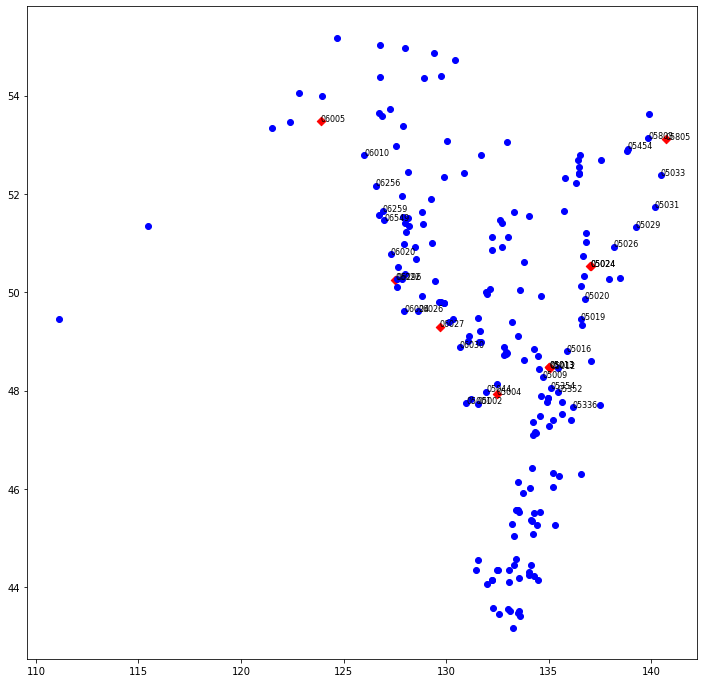

In [28]:
plt.figure(figsize=(12,12))

plt.scatter(posts.loc[target_inds,'lon'],posts.loc[target_inds,'lat'],marker='D',c='r')
plt.scatter(posts.loc[posts.index.difference(target_inds),'lon'],
            posts.loc[posts.index.difference(target_inds),'lat'],marker='o',c='b')
for _id, row in posts.iterrows():
    if _id in good_posts:
        plt.annotate(str(_id), (row['lon'],row['lat']),size=8)
        

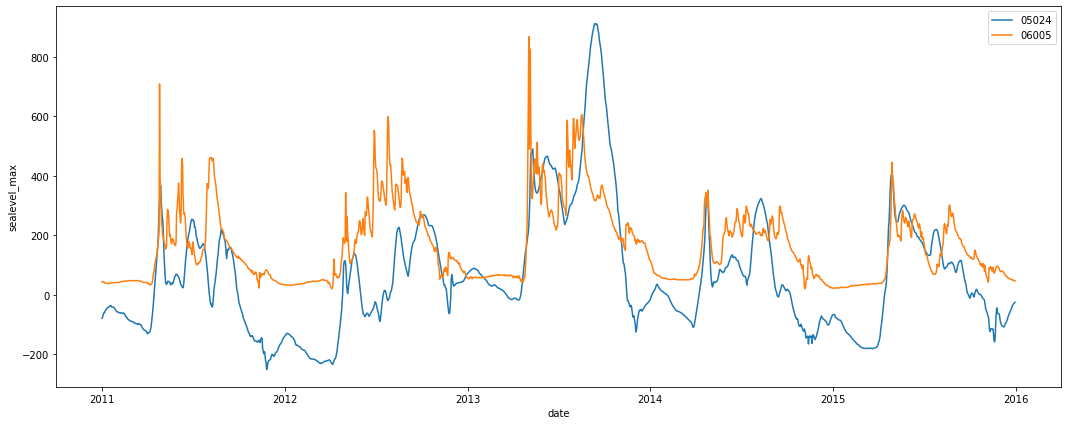

In [29]:
test_inds = ['06005','05116','05311','05027','05024','06364','06023','05349','06302','06453','05250','05458']
plt.figure(figsize=(18,7))
for grp_name,grp_df in full_df[(full_df['identifier'].isin(test_inds)) & 
            (full_df['date'] >= '2011-01-01') & (full_df['date'] <= '2015-12-31')].groupby('identifier'):
    sns.lineplot(grp_df['date'],grp_df['sealevel_max'],label=grp_name)
plt.legend()
plt.show()

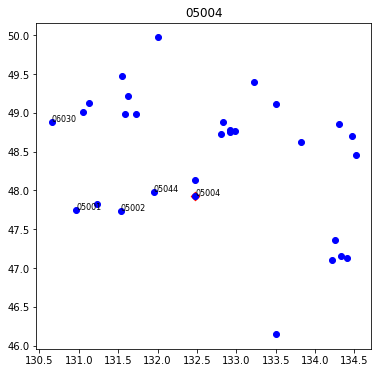

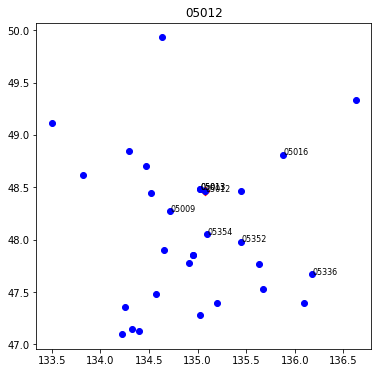

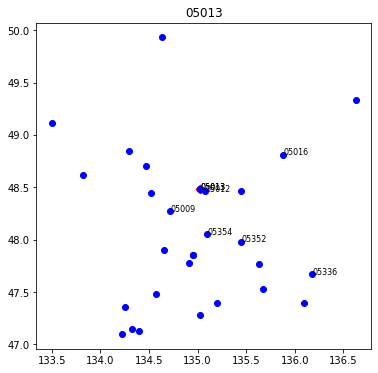

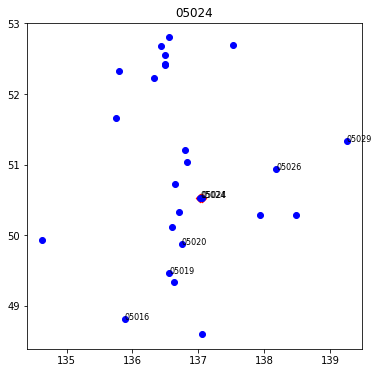

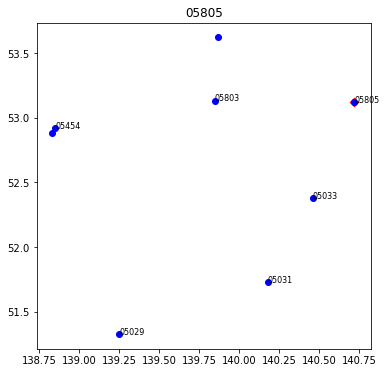

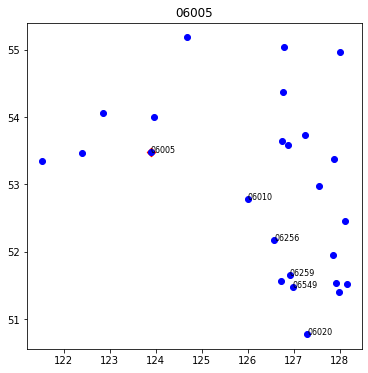

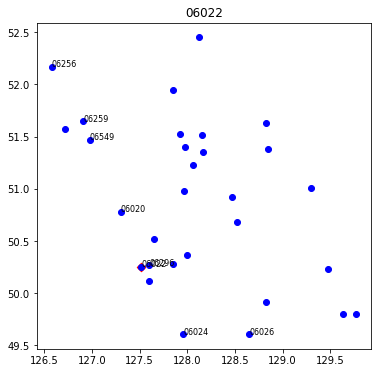

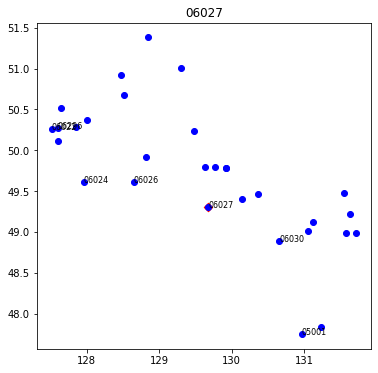

In [30]:
for ind in target_inds:
    plt.figure(figsize=(6,6))
    plt.title(ind)
    lat,lon = posts.loc[ind,'lat'],posts.loc[ind,'lon']
    if isinstance(lat,pd.Series):
        lat = lat.iloc[0]
        lon = lon.iloc[0]
    posts['distance'] = ((posts['lat'] - lat)**2+(posts['lon']-lon)**2)**0.5
    if ind == '06005':
        dist_posts = posts[posts['distance'] <= 5].sort_values('distance').head(25)
    else:
        dist_posts = posts[posts['distance'] <= 2.5].sort_values('distance').head(30)
    plt.scatter(dist_posts.loc[ind,'lon'],posts.loc[ind,'lat'],marker='D',c='r')
    plt.scatter(dist_posts['lon'],dist_posts['lat'],marker='o',c='b')
    for _id, row in dist_posts.iterrows():
        if _id in good_posts:
            plt.annotate(str(_id), (row['lon'],row['lat']),size=8)
    plt.show()

In [31]:
nearest_stations = {'06005':['06010','06256','06259','06549','06020','06016'],
                   '06022':['06296','06024','06026','06020','06549','06026'],
                   '06027':['06024','06026','06030','05001','05002'],
                   '05004':['05001','05002','05016','05044','05008'],
                   '05012':['05013','05008','05016','05009','05354','05352','05336'],
                   '05024':['05020','05026','05029','05019','05016'],
                   '05805':['05803','05454','05033','05031','05029']}


In [32]:
all_stations = []
all_stations.extend(list(nearest_stations.keys()))
for val in nearest_stations.values():
    all_stations.extend(val)
all_stations = list(set(all_stations))
print(len(all_stations))

35


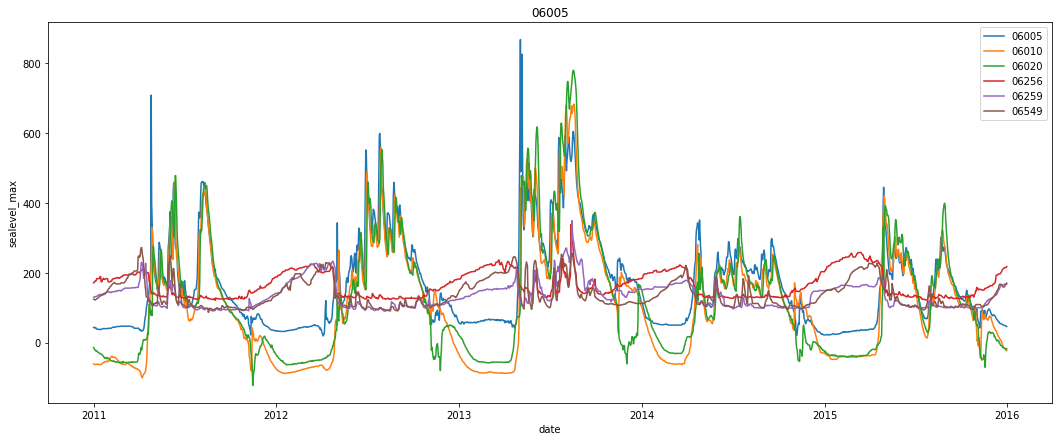

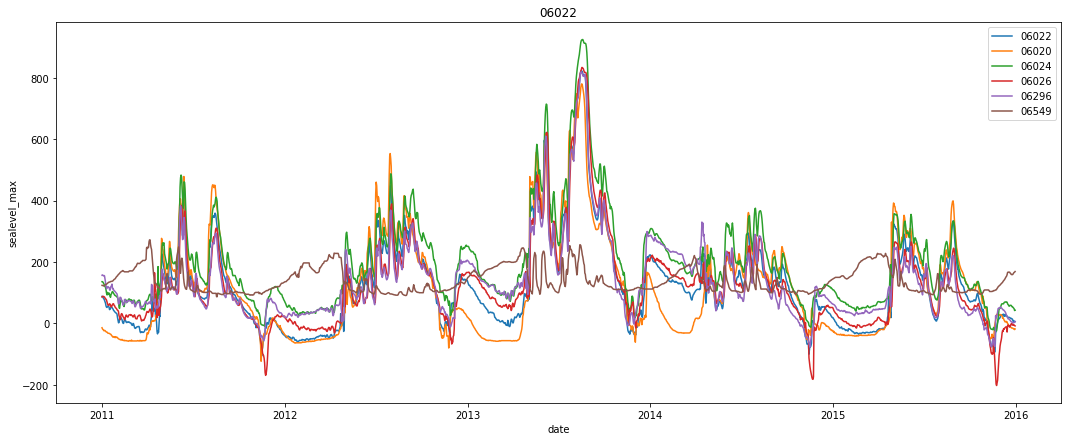

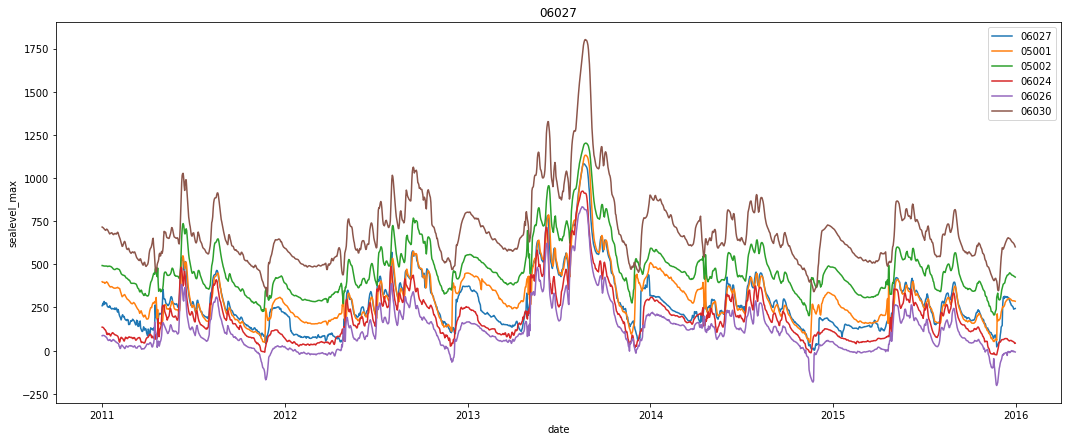

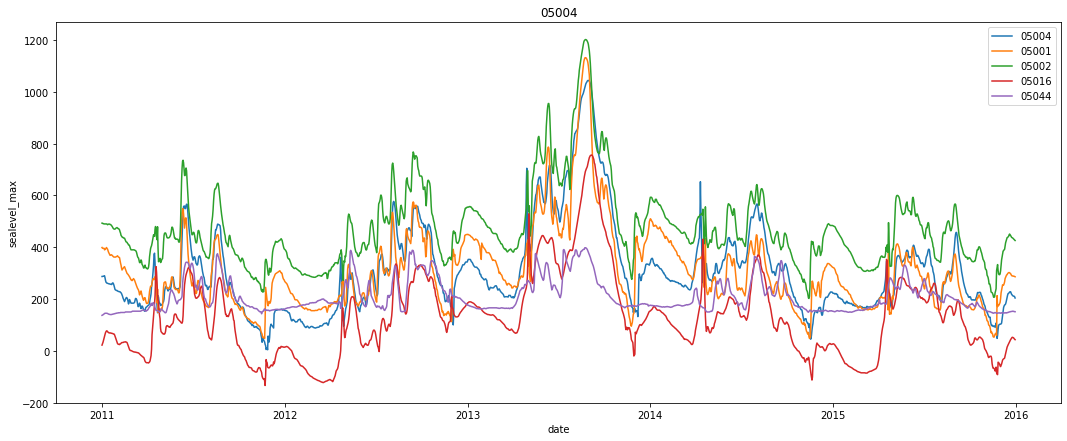

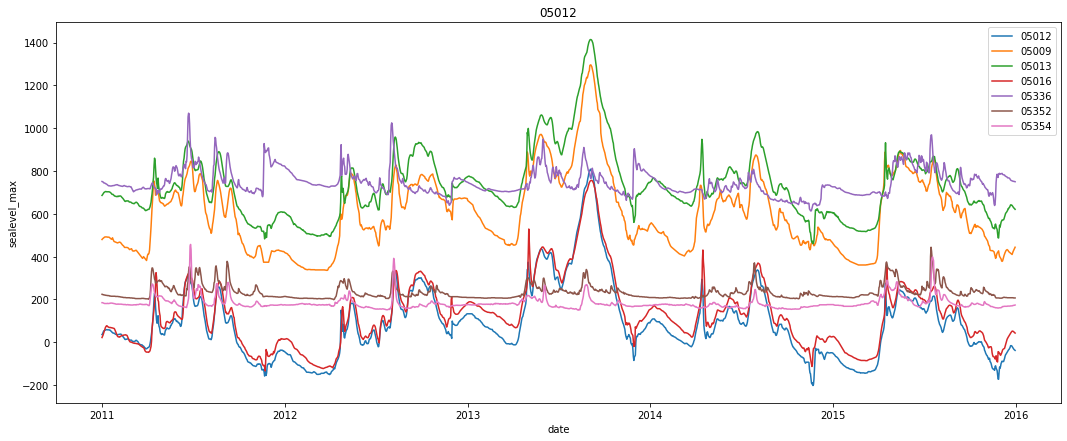

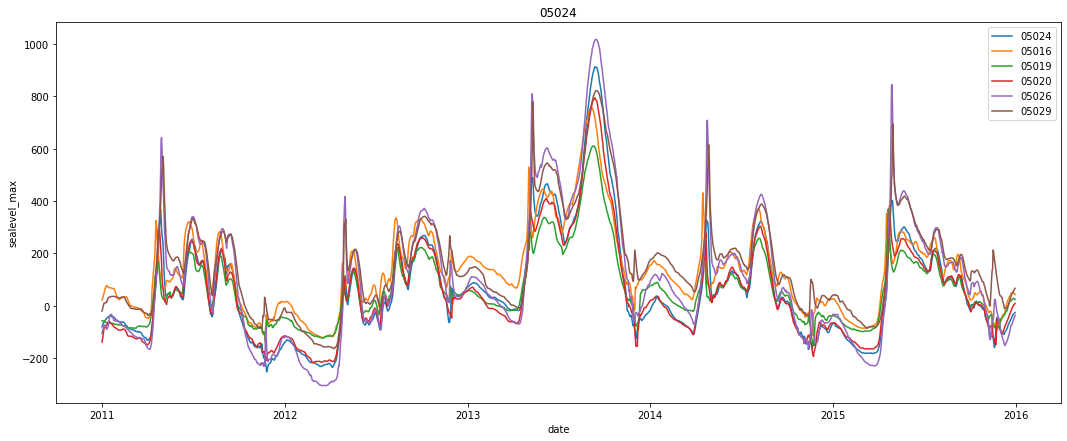

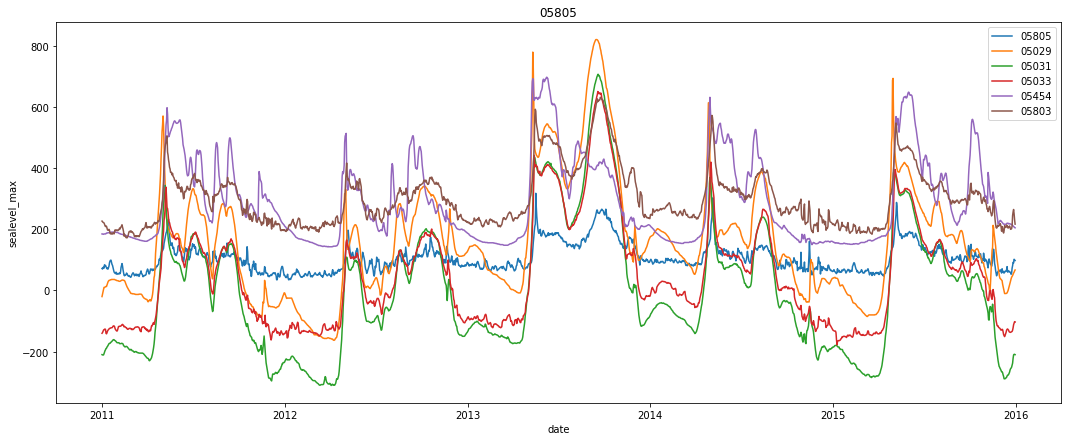

In [33]:
for key_station,stations in nearest_stations.items():
    plt.figure(figsize=(18,7))
    plt.title(key_station)
    key_df = full_df[(full_df['identifier'] == key_station) & 
                     (full_df['date'] >= '2011-01-01') & (full_df['date'] <= '2015-12-31')]
    sns.lineplot(key_df['date'],key_df['sealevel_max'],label=key_station)
    for grp_name,grp_df in full_df[(full_df['identifier'].isin(stations)) & 
                (full_df['date'] >= '2011-01-01') & (full_df['date'] <= '2015-12-31')].groupby('identifier'):
        sns.lineplot(grp_df['date'],grp_df['sealevel_max'],label=grp_name)
    plt.legend()
    plt.show()    

# Для каждого ключевого гидропоста будут учитываться:
* посты на различных участках реки Амур (с. Джалинда (06005), с. Венюково (05116), 0.3км ниже устья р. Амкан (06302), Комсомольск-на-Амуре (05024), с. Стойба (06364), Благовещенск (06022,06296), Иннокентьевка (0.6027), Усть-Мальта (06453), Ленинск (05004), Хабаровск (05012,05013), Николаевск-на-Амуре (05805), с. Апкороши (05458);
* ближайшие 5-10 постов к каждому ключевому гидропосту

# Анализ расхода воды.
На каких станциях из всех анализирующихся он есть

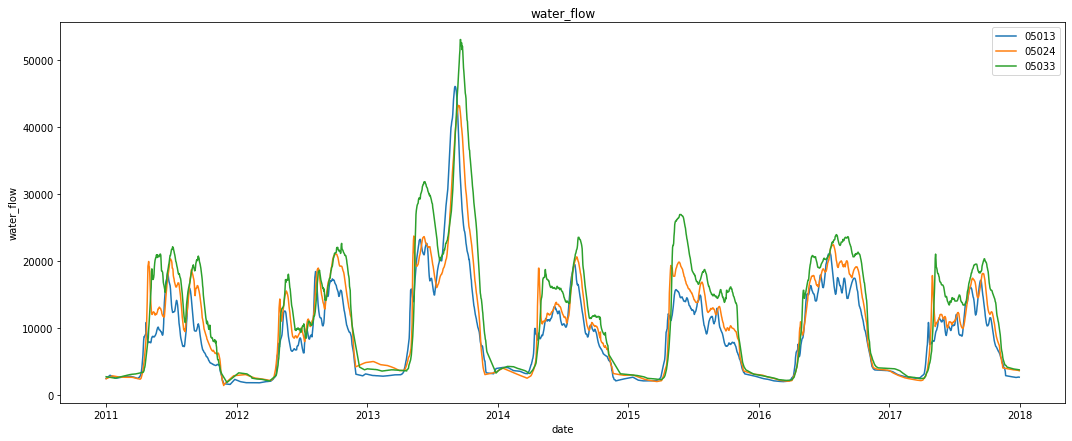

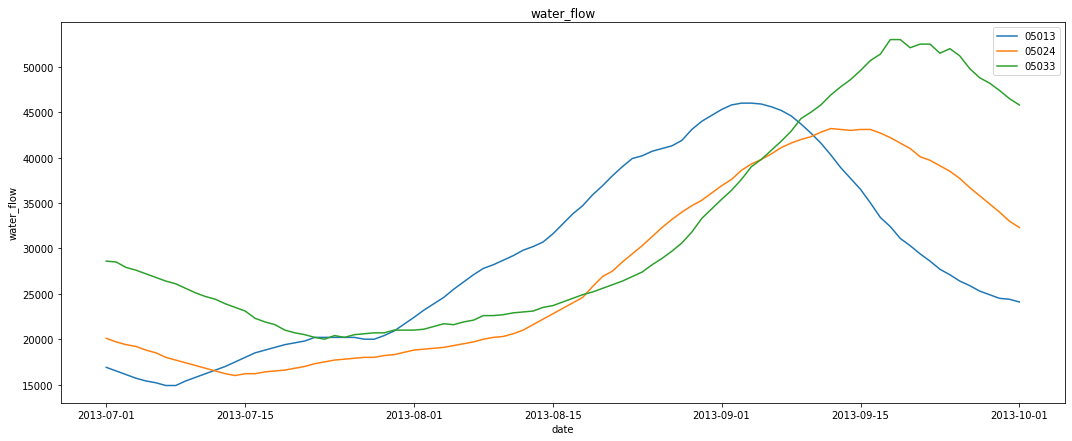

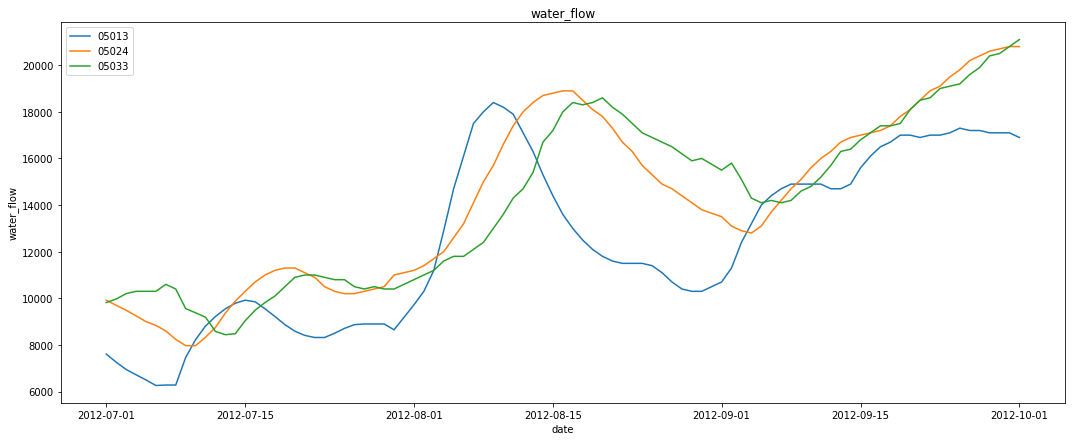

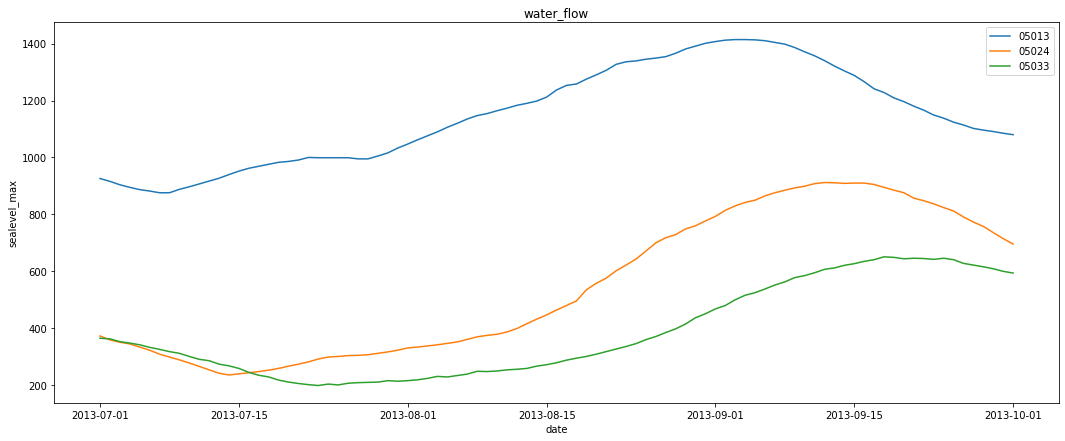

In [34]:
plt.figure(figsize=(18,7))
plt.title('water_flow')
for grp_name,grp_df in full_df[(full_df['identifier'].isin(all_stations)) & 
            (full_df['date'] >= '2011-01-01') & (full_df['date'] <= '2017-12-31')].groupby('identifier'):
    if grp_df['water_flow'].max() >= 5000:
        sns.lineplot(grp_df['date'],grp_df['water_flow'],label=grp_name)
plt.legend()
plt.show()

plt.figure(figsize=(18,7))
plt.title('water_flow')
for grp_name,grp_df in full_df[(full_df['identifier'].isin(all_stations)) & 
            (full_df['date'] >= '2013-07-01') & (full_df['date'] <= '2013-10-01')].groupby('identifier'):
    if grp_df['water_flow'].max() >= 5000:
        sns.lineplot(grp_df['date'],grp_df['water_flow'],label=grp_name)
plt.legend()
plt.show()

plt.figure(figsize=(18,7))
plt.title('water_flow')
for grp_name,grp_df in full_df[(full_df['identifier'].isin(all_stations)) & 
            (full_df['date'] >= '2012-07-01') & (full_df['date'] <= '2012-10-01')].groupby('identifier'):
    if grp_df['water_flow'].max() >= 5000:
        sns.lineplot(grp_df['date'],grp_df['water_flow'],label=grp_name)
plt.legend()
plt.show()

plt.figure(figsize=(18,7))
plt.title('water_flow')
for grp_name,grp_df in full_df[(full_df['identifier'].isin(['05013','05024','05033'])) & 
            (full_df['date'] >= '2013-07-01') & (full_df['date'] <= '2013-10-01')].groupby('identifier'):
    if grp_df['water_flow'].max() >= 5000:
        sns.lineplot(grp_df['date'],grp_df['sealevel_max'],label=grp_name)
plt.legend()
plt.show()

# Из анализа расхода и уровня четко видно, что между станциями 05013,05024 и 05033 есть корреляция с некоторым временным лагом в несколько дней (около 4-6 суток).
Что еще раз доказывает, что учет данных со станций из разных участков бассейна Амур увеличит прогностическую и обобщающую способность модели - это будет обобщенным аналогом метода соответственных уровней и множежственной корреляции.

См., например, [4]

# Ледовый покров и высота снега

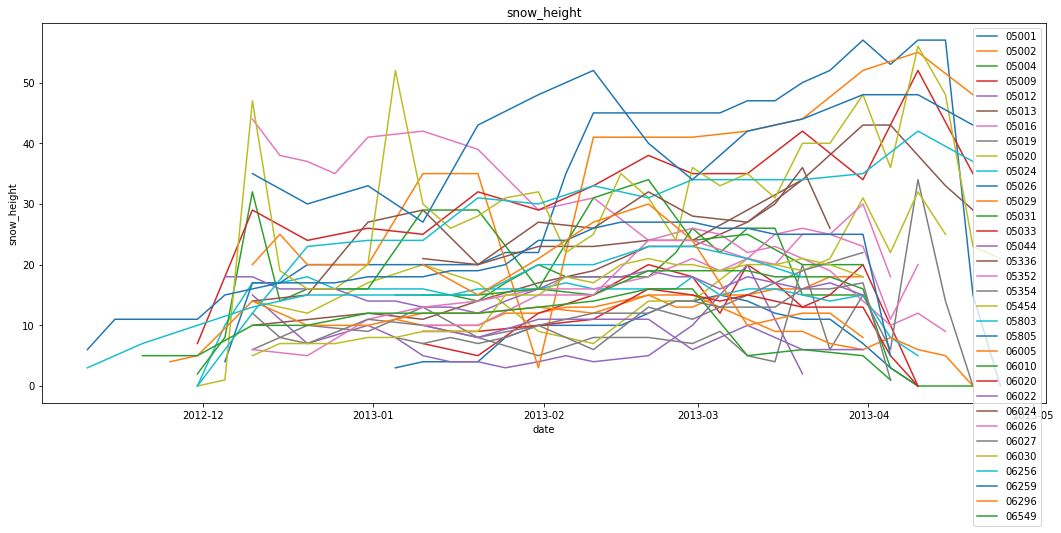

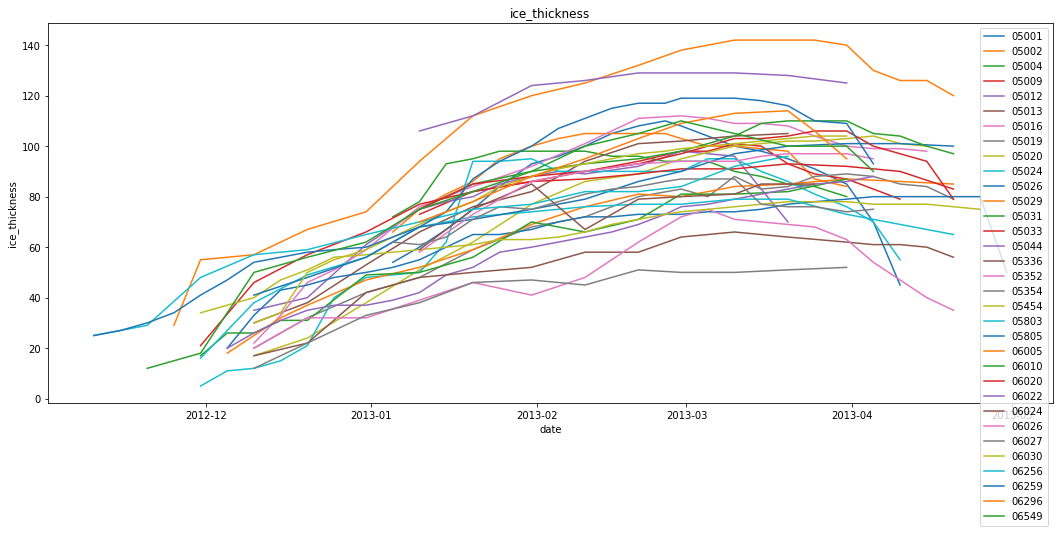

In [35]:
plt.figure(figsize=(18,7))
plt.title('snow_height')
for grp_name,grp_df in full_df[(full_df['identifier'].isin(all_stations)) & 
            (full_df['date'] >= '2012-10-01') & (full_df['date'] <= '2013-05-01')].groupby('identifier'):
    sns.lineplot(grp_df['date'],grp_df['snow_height'],label=grp_name)
plt.legend()
plt.show()

plt.figure(figsize=(18,7))
plt.title('ice_thickness')
for grp_name,grp_df in full_df[(full_df['identifier'].isin(all_stations)) & 
            (full_df['date'] >= '2012-10-01') & (full_df['date'] <= '2013-05-01')].groupby('identifier'):
    sns.lineplot(grp_df['date'],grp_df['ice_thickness'],label=grp_name)
plt.legend()
plt.show()

In [36]:
full_df = full_df[full_df['identifier'].isin(all_stations)]

hydro = posts.loc[full_df['identifier'].unique()]
hydro = hydro[~hydro.index.duplicated(keep='first')]
full_df = full_df.merge(hydro[['lat','lon']],left_on='identifier',right_index=True)
full_df.count()

date             409615
sealevel_avg     409296
sealevel_max     409288
sealevel_min     409299
water_temp       261464
identifier       409615
water_code       409615
ice_thickness     13440
snow_height       12246
water_flow       107708
year             409615
lat              409615
lon              409615
dtype: int64

# Данные не очень качественные:
* измерения не ежедненые
* измерения есть не на всех станциях
* данные обрываются и начинаются с некоторого периода - явно толщина льда не может со 120 сразу уходить в 0, т.е. в какой-то момент времени измерения просто перестают делаться

# Добавление метео

In [37]:
def read_all_meteo(asunp):
    full_df = pd.DataFrame()
    for _f in os.listdir('data/meteo_new'):
        if _f.endswith('.csv'):
            print(_f[0:-4])
            time_cols = ['localYear','localMonth','localDay','localTimePeriod']
            meteo_cols = ['cloudCoverTotal','pastWeather','presentWeather',
                        'windDirection','windSpeed','maximumWindGustSpeed',
                       'totalAccumulatedPrecipitation','soilTemperature','airTemperature',
                         'relativeHumidity','pressureReducedToMeanSeaLevel',
                         'pressure']
            quality_cols = [col + 'Quality' for col in meteo_cols]
            a = pd.read_csv('data/meteo_new/' + _f, sep=',',
                           usecols=time_cols+meteo_cols+quality_cols)
            
            for col in meteo_cols:
                if len(a[a[col].isnull()])/len(a) >= 0.9:
                    print(col)
                    a.drop(col,axis=1,inplace=True)
                    meteo_cols.remove(col)
                    quality_cols.remove(col+'Quality')
            
            #по температуре - берем и мин и макс
            #for col in ['airTemperature']:
            if 'airTemperature' in meteo_cols:
                col = 'airTemperature'
                a[col + '_min'] = a[col].copy()
                a[col + '_minQuality'] = a[col + 'Quality'].copy()    
                a.rename(columns={col:col + '_max',col + 'Quality':col + '_maxQuality'},inplace=True)
                meteo_cols.remove(col)
                meteo_cols.extend([col + '_min',col + '_max'])
            
            
            # для всех значений с сомнительным качеством - зануляем и делаем линейную интерполяцию для численных, для категориальных - ffill
            a['datetime'] = pd.to_datetime(a.apply(lambda x: datetime(int(x['localYear']),int(x['localMonth']),
                                                int(x['localDay']),int(x['localTimePeriod'])),axis=1))
            a.sort_values('datetime',inplace=True)
            for col in meteo_cols:
                bad_ind = a[a[col+'Quality'].astype(np.int).isin([3,4,6,7])].index
                a.loc[bad_ind,col] = np.nan
                if col in ['pastWeather','presentWeather','cloudCoverTotal']:
                    a[col] = a[col].fillna(method='ffill').fillna(method='bfill')
                else:
                    a[col] = a[col].interpolate(method='linear')
            a['datetime'] = pd.to_datetime(a.apply(lambda x: datetime(int(x['localYear']),int(x['localMonth']),
                                                            int(x['localDay']),int(x['localTimePeriod'])),axis=1))
            a.set_index('datetime',inplace=True)
            resample_dict = {
                    'cloudCoverTotal':'max',
                    'pastWeather': 'max',
                    'presentWeather': 'max',
                'windDirection':'median',
                'windSpeed':'max',
                'maximumWindGustSpeed':'max',
                'totalAccumulatedPrecipitation':'sum',
                'airTemperature_max':'max',
                'airTemperature_min':'min',
                'soilTemperature':'mean',
                'relativeHumidity':'max',
                'pressureReducedToMeanSeaLevel':'mean',
                'pressure':'mean'
                }
            for col in ['cloudCoverTotal','pastWeather','presentWeather']:
                a[col] = a[col].round().astype(np.int)
            
            dict_keys = list(resample_dict.keys())
            for col in dict_keys:
                if col not in meteo_cols:
                    del resample_dict[col]
                    
            a = a.resample('D').agg(resample_dict)
            a.reset_index(inplace=True)
            a['identifier'] = _f[0:-4]
            a.sort_values('datetime',inplace=True)
            for col in meteo_cols:
                if col in ['pastWeather','presentWeather','cloudCoverTotal']:
                    a[col] = a[col].fillna(method='ffill').fillna(method='bfill')
                else:
                    a[col] = a[col].interpolate(method='linear').fillna(method='bfill')
            full_df = full_df.append(a)
    full_df.sort_values('datetime',inplace=True)
    
    meteo_stations = asunp[asunp.meteo.isin(full_df['identifier'])].drop_duplicates('meteo',keep='last')
    full_df = full_df.merge(meteo_stations[['lat','lon','meteo']],left_on='identifier',right_on='meteo')
    return full_df


In [38]:
meteo_df = read_all_meteo(asunp)

4443141
4483311
4553551
4593371
4653531
4713431
4773101
4853521
4863381
4883591
4923811
soilTemperature
4943011
4961191
4962801
4971271
5013211
5032761
5041651
5093231
5093821
5111461
5131961
5162881
5231771
5233401
5242991
5243651
5244051
5282601
5313301
5352391
5371981
5402401
5472891


In [39]:
max(datetime(2018,9,3),datetime(2018,10,2))

datetime.datetime(2018, 10, 2, 0, 0)

In [40]:
meteo_df.count()/len(meteo_df)

datetime                         1.000000
cloudCoverTotal                  1.000000
pastWeather                      1.000000
presentWeather                   1.000000
windDirection                    1.000000
windSpeed                        1.000000
maximumWindGustSpeed             1.000000
totalAccumulatedPrecipitation    1.000000
airTemperature_max               1.000000
airTemperature_min               1.000000
soilTemperature                  0.970624
relativeHumidity                 1.000000
pressureReducedToMeanSeaLevel    1.000000
pressure                         1.000000
identifier                       1.000000
lat                              1.000000
lon                              1.000000
meteo                            1.000000
dtype: float64

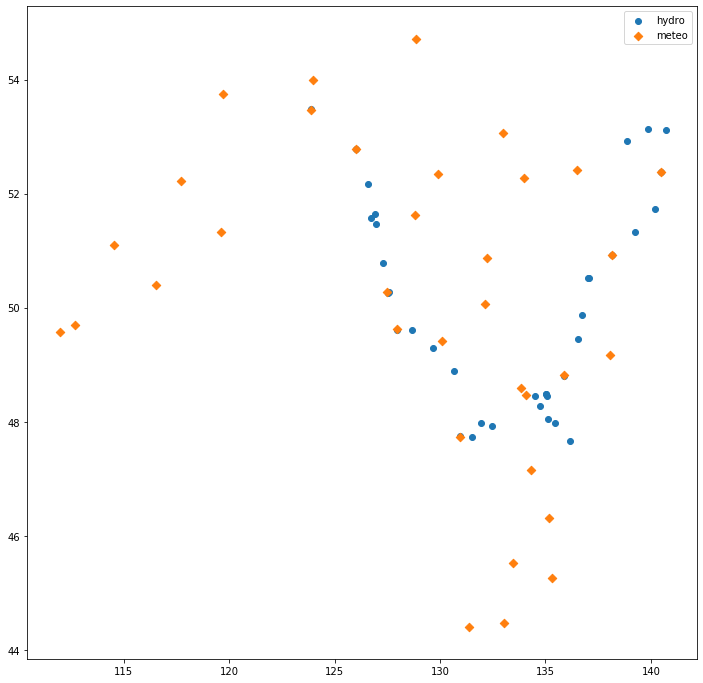

In [41]:
plt.figure(figsize=(12,12))
plt.scatter(posts.loc[all_stations]['lon'],posts.loc[all_stations]['lat'],label='hydro')
plt.scatter(meteo_df.drop_duplicates('identifier')['lon'],
            meteo_df.drop_duplicates('identifier')['lat'],label='meteo',marker='D')
plt.legend()
plt.show()

In [42]:
def merge_hydro_with_meteo(full_df,meteo_df,hydro):
    hydro_df = full_df.copy()
    
    #---- добавляем категориальные признаки - их заменяаем по ближайшему соседу
    meteo_df['ts'] = (meteo_df['datetime'].astype(np.int64) / 10 ** 10)*2
    hydro_df['ts'] = (hydro_df['date'].values.astype(np.int64) / 10 ** 10)*2

    kd = KDTree(meteo_df[['lon', 'lat', 'ts']])
    union_ind = hydro_df[hydro_df['ts'].astype(np.int).astype(str).isin(meteo_df['ts'].astype(np.int).astype(str))].index
    indices = kd.query(hydro_df.loc[union_ind][['lon', 'lat', 'ts']], 1, return_distance=False)[:, 0]

    for col in ['pastWeather', 'presentWeather', 'cloudCoverTotal']:
        hydro_df[col] = np.nan
        hydro_df.loc[union_ind,col] = meteo_df.iloc[indices][col].values

    del kd
    gc.collect()
    
    #---- численные признаки с помощью киргинга по 3 ближайшим соседям (как в примере решения)
    new_df = pd.DataFrame(columns=['identifier','date','windDirection','windSpeed','maximumWindGustSpeed',
                        'totalAccumulatedPrecipitation','soilTemperature','airTemperature_min','airTemperature_max',
                            'relativeHumidity','pressureReducedToMeanSeaLevel','pressure'])
    for day, day_meteo in tqdm(meteo_df.groupby('datetime'),total=len(meteo_df['datetime'].unique())):
        part_df = pd.DataFrame(columns=['identifier','date','windDirection','windSpeed','maximumWindGustSpeed',
                        'totalAccumulatedPrecipitation','soilTemperature','airTemperature_min','airTemperature_max',
                            'relativeHumidity','pressureReducedToMeanSeaLevel','pressure'])
        part_df['identifier'] = hydro.index.values
        part_df['date'] = [day]*len(part_df)
        for prop in ['windDirection','windSpeed','maximumWindGustSpeed',
                        'totalAccumulatedPrecipitation','soilTemperature','airTemperature_min','airTemperature_max',
                            'relativeHumidity','pressureReducedToMeanSeaLevel','pressure']:
            longitudes = day_meteo[day_meteo[prop].notnull()].lon
            latitudes = day_meteo[day_meteo[prop].notnull()].lat
            values = day_meteo[day_meteo[prop].notnull()][prop].values

            if values.max() == values.min():
                interpolated_values = np.full(len(hydro), values.mean())
            else:
                OK = OrdinaryKriging(
                    longitudes,
                    latitudes,
                    values,
                    variogram_model='spherical',
                    coordinates_type="geographic")
                interpolated_values, ss1 = OK.execute("points", hydro.lon, hydro.lat, backend="C", n_closest_points=3)
            part_df[prop] = interpolated_values
        new_df = new_df.append(part_df)
        gc.collect()
    hydro_df = hydro_df.merge(new_df,on=['identifier','date'],how='left')
    return hydro_df

In [43]:
full_df = merge_hydro_with_meteo(full_df,meteo_df,hydro)

In [44]:
(full_df.count()/len(full_df)).sort_values()

snow_height                      0.029896
ice_thickness                    0.032811
water_flow                       0.262949
water_temp                       0.638316
sealevel_max                     0.999202
sealevel_avg                     0.999221
sealevel_min                     0.999229
date                             1.000000
relativeHumidity                 1.000000
airTemperature_max               1.000000
airTemperature_min               1.000000
soilTemperature                  1.000000
totalAccumulatedPrecipitation    1.000000
maximumWindGustSpeed             1.000000
windSpeed                        1.000000
windDirection                    1.000000
ts                               1.000000
presentWeather                   1.000000
pastWeather                      1.000000
pressureReducedToMeanSeaLevel    1.000000
lon                              1.000000
lat                              1.000000
year                             1.000000
water_code                       1

In [45]:
full_df.to_csv('prepared_csv.csv')

# Признаки:

### Исторические данные по уровню:
* макс. уровень воды 10,20,30 дней назад - хорошо работает, информации в уровни воды за прошедшие периоды очень много, т.к. он может сказать какие протекали метеорологические и гидрофизические процессы ранее, что повлияло на уровень;
* код состояния водного объекта 10 дней назад;
* демодулированный уровень воды 10 дней назад для учета цикличности (для периодов в 12 и 4 месяцев);
* макс. уровень воды год назад;
* макс. уровень воды год назад, усредненный за 3 дня;

### <font color='red'>Расход воды - пока не используем, нет данных до 2020 </font>:
на значительную связь расхода воды с уровнем воды указывают несколько источников, к примеру [1] и [2].
* расход воды 10 дней назад (если нет наблюдений, то 0); - <font color='red'> в итоге не используем, неизвестно будут ли данные обновлены; </font>

### Учет гидрометеорологической информации
для учета гидрометеорологической информации используются:
* относительная влажность воздуха на текущий день (для прогноза на 10 дней вперед используем прогноз погоды);
* сумма осадков на текущий день (для прогноза на 10 дней вперед используем прогноз погоды);
* макс. и мин. температура воздуха на текущий день (для прогноза на 10 дней вперед используем прогноз погоды);
* атмосферное давление на текущий день (для прогноза на 10 дней вперед используем прогноз погоды)
* средняя скорость и направление ветра на текущий день (для прогноза на 10 дней вперед используем прогноз погоды);
* относительная влажность воздуха за вчерашний день (для прогноза на 10 дней вперед используем прогноз погоды);
* сумма осадков за день за вчерашний день (для прогноза на 10 дней вперед используем прогноз погоды);
* макс. и мин. температура воздуха за вчерашний день (для прогноза на 10 дней вперед используем прогноз погоды);
* атмосферное давление за вчерашний день (для прогноза на 10 дней вперед используем прогноз погоды)
* средняя скорость и направление ветра за вчерашний день (для прогноза на 10 дней вперед используем прогноз погоды);
* макс. и мин. температура за 10 дней на текущий день
* относительная влажность воздуха 10 дней назад;
* сумма осадков за день 10 дней назад;
* атмосферное давление 10 дней назад
* средняя скорость и направление ветра, 10 дней назад;
* температура почвы 10 дней назад;
* средняя относительная влажность за последние 3,7 дней;
* средняя сумма осадков за последние 3,7 дней;
* средняя относительная влажность за последни 3,7 дней 10 дней назад;
* средняя сумма осадков за последние 3,7 дней 10 дней назад;
* средняя сумма осадков за последние 45 дней (для зимних периодов хорошо);
* средняя относительная влажность за последние 45 дней (для зимних периодов хорошо);


### Учет времени:
* sin,cos преобразование от текущего дня в году с частотй 1/365 (позволяет учитывать цикличность - что после 365 дня идет 1);

### <font color='red'> Учет данных по ледовому покрою и снегу - не используем, данные не очень адекватного качества (прерываются, начинаются неравномерно), мало измерений</font>:
* высота снежного покрова 10 дней назад - <font color='red'>  - не используем, данные не очень адекватного качества (прерываются, начинаются неравномерно), мало измерений </font>;
* толщина льда 10 дней назад - <font color='red'> учитываем, что измерения не ежедневные и есть не на всех станциях </font>;
* запас воды в снежном покрове 10 дней назад (по формуле из [1]) - <font color='red'>  - не используем, данные не очень адекватного качества (прерываются, начинаются неравномерно), мало измерений </font>

In [48]:
#img = mpimg.imread('map.jpg')
#plt.figure(figsize=(24,60))
#plt.plot(hydro.loc[list(ALL_STATIONS[8:])]['lon'],hydro.loc[list(ALL_STATIONS[8:])]['lat'],'rD',markersize=10,label='Вспомогательные гидропосты')
#plt.plot(hydro.loc[list(ALL_STATIONS[0:8])]['lon'],hydro.loc[list(ALL_STATIONS[0:8])]['lat'],'wo',markersize=12,label='Основные гидропосты')
#plt.imshow(img,extent=[106.2,146.3,41.8,56.45])
#plt.legend()
#plt.show()

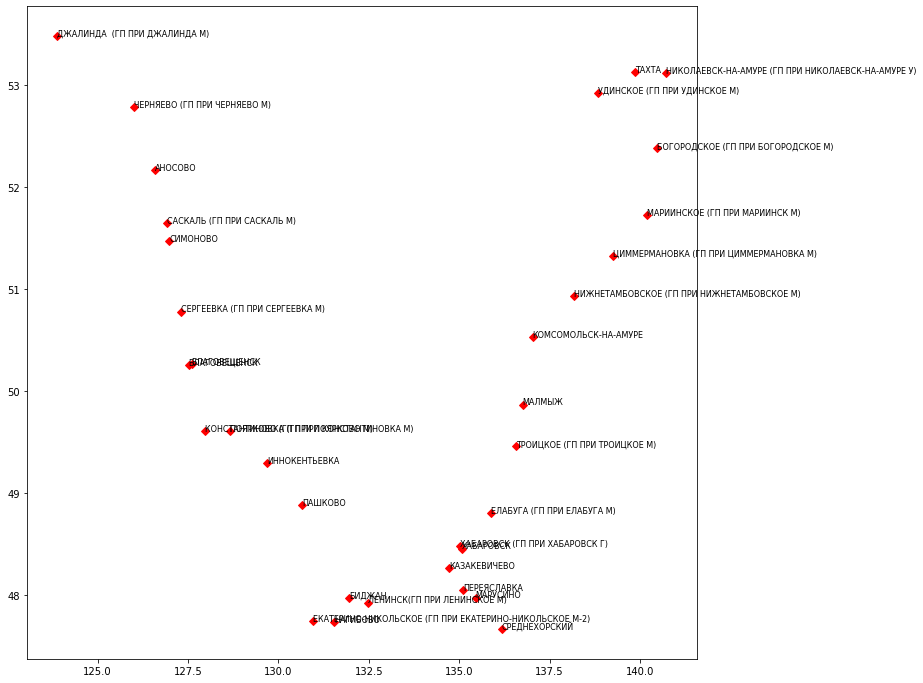

In [49]:
hydro = posts[~posts.index.duplicated(keep='first')].copy()

plt.figure(figsize=(12,12))
plt.plot(hydro.loc[list(ALL_STATIONS)]['lon'],hydro.loc[list(ALL_STATIONS)]['lat'],'rD')

for _id in ALL_STATIONS:
    plt.annotate(hydro.loc[_id,'name'], (hydro.loc[_id,'lon'],hydro.loc[_id,'lat']),size=8)

In [50]:
full_df = pd.read_csv('prepared_csv.csv')
full_df['date'] = pd.to_datetime(full_df['date'])
full_df['identifier'] = '0' + full_df['identifier'].astype('str')

In [51]:
amur_df = make_dataset(full_df,train=True)

2020-11-20 16:09:56,166 - [INFO] - ~~~START MAKING FEATURES~~~
2020-11-20 16:09:56,167 - [INFO] - 	sin-cos dates
2020-11-20 16:10:00,822 - [INFO] - 	days without precipitation
2020-11-20 16:10:01,235 - [INFO] - 	10 days before
2020-11-20 16:10:05,306 - [INFO] - 	20,30 days before
2020-11-20 16:10:08,171 - [INFO] - 	demodulation
2020-11-20 16:15:27,133 - [INFO] - 	1 day before
2020-11-20 16:15:29,229 - [INFO] - 	meteo
2020-11-20 16:15:29,230 - [INFO] - 	7,3,45 days mean
2020-11-20 16:15:47,221 - [INFO] - 	last year
2020-11-20 16:17:04,530 - [INFO] - ~~~END MAKING FEATURES~~~


In [52]:
amur_df.to_csv('amur_dataset.csv')

# Модель:
<ol>
<li> в качестве модели будем использовать Bidirectional LSTM - это позволит легко учитывать временную зависимость данных и внесет нелинейность в модель; Для линейной комбинации будем до и после Bi-LSTM использовать полносвязный слой - это позволит комбинировать исходные признаки, не прибегая к ручному формированию признаков;</li>
    <li> на выходе предсказываем уровень <b> сразу для всех станций </b> - из-за высокой корреляции между уровнями это позволит учитывать бОльшую часть особенностей всего бассейна (учет неоднородностей, учет движения водного потока, учет метеорологических данных и физико-географических особенностей со всех станций и т.д.);
<li> для того, чтобы учитывать физико-географические особенности всего бассейна, предсказываем целевую переменную (макс. уровень) для всех 33 станций, а не только целевых - из-за высокой корреляции между рядом расположенными станциями модель будет работать достовернее; </li>
    <li> для прогнозирования уровня на 10 дней вперед на исторических срезах используем актуальные данные, для будущего - используем прогноз погоды из 3 источников (API gismeteo, яндекс.погода и openweathermap) - из трех источников результаты по атмосферному давлению, температуре усредняются , по параметрам ветра, осадкам и относительной влажности берутся максимальные - <b> таким образом прогноз уровня осуществляется на основе пессимистического сценария погоды; </b>
    <li> итоговая размерность датасета - (n_samples,n_features,days_forecast), где n_samples - общее число семплов, при разбении по 10 дней, n_features - количество признаков на каждый день, days_forecast - количество дней для прогнозирования; </li>
    <li> на выходе из модель получаем тензор размера (n_samples,days_forecast,stations), где stations - кол-во станций, для которых предсказываем макс. уровень.
</ol>

# Построенный таким образом пайплайн обладает рядом преимуществ:
* за счет одновременного прогнозирования уровня в нескольких точках по данным со множества станций более полно и адекватно учитываются основные процессы в бассейне;
* можно легко настроить необходимое количество дней для прогноза и сравнивать результаты;
* можно обобщить на бОльшее количество станций и предсказывать уровни на многих станциях (сейчас это делается буквально в две строчки - меняем названия станций в конфиге и запускаем пайплайн обучения);
* бассейн реки можно разделить на части и строить различные модели;
* можно строить разные сценарии прогноза на основе использования нескольких источников прогноза погоды - пессимистичный (из всех прогнозов выбираются наихудшие значения), оптимистичный (из всех прогнозов выбираются наилучшие значения) и нейтральный (усреднять или брать медиану). Исходя из этих сценариев можно сравнивать вероятные сценарии изменения уровня.

In [57]:
X_train,y_train,X_test,y_test = train_test_split(amur_df,'2013-01-01','2014-01-05',fname='data/mean_std_stats.json')

(369, 1552)


# <font color='red'>Внимание! Обучал на kaggle с gpu, локально обучается довольно долго (часов 6), если обучить заново результаты могут немного отличаться </font>

In [58]:
model_fn = 'data/weights-aij2020amurlevel-2012-local.h5'

model = build_model()
sv_model = tf.keras.callbacks.ModelCheckpoint(model_fn, save_best_only=True, monitor='val_mae_inference')
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(factor=0.3)

if TRAIN:
    history_model = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            batch_size=8,
            epochs=100,
            callbacks=[lr_callback, sv_model],
            verbose=2
    )

In [59]:
amur_df = pd.read_csv('amur_dataset.csv')
amur_df.shape

(12419, 1553)

In [60]:
for target_col in ALL_STATIONS[0:NUMBER_OF_INFERENCE_STATIONS]:
    print(target_col + ' - correlations')
    print(amur_df[NUMERICAL_FEATURES].corrwith(amur_df['sealevel_max_' + target_col]).abs().sort_values(ascending=False).head(10))

05004 - correlations
shift_10_days_sealevel_max_05004    0.896574
shift_10_days_sealevel_max_06030    0.865906
shift_10_days_sealevel_max_06027    0.865672
shift_10_days_sealevel_max_06022    0.860476
shift_10_days_sealevel_max_05012    0.859492
shift_10_days_sealevel_max_05013    0.858315
shift_10_days_sealevel_max_05002    0.856662
shift_10_days_sealevel_max_06020    0.840026
shift_10_days_sealevel_max_06024    0.839361
shift_10_days_sealevel_max_05016    0.838209
dtype: float64
05012 - correlations
shift_10_days_sealevel_max_05012    0.910587
shift_10_days_sealevel_max_05013    0.906610
shift_10_days_sealevel_max_05004    0.898888
shift_10_days_sealevel_max_05009    0.883043
shift_10_days_sealevel_max_05016    0.876322
shift_10_days_sealevel_max_05002    0.868613
shift_10_days_sealevel_max_06030    0.868332
shift_10_days_sealevel_max_06027    0.864261
shift_10_days_sealevel_max_05019    0.857922
shift_10_days_sealevel_max_06022    0.848996
dtype: float64
05013 - correlations
shift_1

In [61]:
for target_col in ALL_STATIONS[0:NUMBER_OF_INFERENCE_STATIONS]:
    print(target_col + ' - correlations')
    print(amur_df[[col for col in NUMERICAL_FEATURES if col.find('shift_10_days_sealevel_max_') < 0 and col.find('shift_20_days_sealevel_max_') < 0 and col.find('shift_30_days_sealevel_max_') < 0]].corrwith(amur_df['sealevel_max_' + target_col]).abs().sort_values(ascending=False).head(10))

05004 - correlations
accumulate_45_days_totalAccumulatedPrecipitation_sum_06030    0.767407
accumulate_45_days_totalAccumulatedPrecipitation_sum_06026    0.763456
accumulate_45_days_totalAccumulatedPrecipitation_sum_06027    0.763389
accumulate_45_days_totalAccumulatedPrecipitation_sum_06024    0.756318
accumulate_45_days_totalAccumulatedPrecipitation_sum_05044    0.748894
accumulate_45_days_totalAccumulatedPrecipitation_sum_05004    0.748748
accumulate_45_days_totalAccumulatedPrecipitation_sum_05002    0.747141
accumulate_45_days_totalAccumulatedPrecipitation_sum_06549    0.746931
accumulate_45_days_totalAccumulatedPrecipitation_sum_06259    0.746252
accumulate_45_days_totalAccumulatedPrecipitation_sum_05001    0.744687
dtype: float64
05012 - correlations
accumulate_45_days_totalAccumulatedPrecipitation_sum_06030    0.778708
accumulate_45_days_totalAccumulatedPrecipitation_sum_05044    0.772167
accumulate_45_days_totalAccumulatedPrecipitation_sum_05004    0.772111
accumulate_45_days_t

# По корреляции самые важные признаки:
* уровень 10,20 дней назад;
* накопленные осадки за 45 дней;
* демодулированный уровень с периодом 365,121 дней;
* мин. температура 10 дней назад.

#### Важна и история по уровню и метео признаки

In [62]:
def mae(y_true,y_pred):
    return np.mean(np.abs(y_true-y_pred))

In [63]:
SEED = 42
old_targets = ['sealevel_max_' + col for col in ALL_STATIONS[0:NUMBER_OF_INFERENCE_STATIONS]]

params = {'objective': 'regression',
          'boosting': 'gbdt',
          'metric': 'mae',
          'learning_rate': 0.004,
          'num_leaves':20,
          'lambda_l2':1,
          'min_data_in_leaf':5,
          'bagging_fraction':0.8,
          'bagging_freq':10,
          'feature_fraction':0.5,
          'seed' : SEED,
         'num_threads' : 6}
  
X_train_lgb = amur_df[amur_df['date'] < '2013-01-01'][NUMERICAL_FEATURES+CATEGORICAL_FEATURES]
y_train_lgb = amur_df[amur_df['date'] < '2013-01-01'][old_targets]

X_test_lgb = amur_df[(amur_df['date'] >= '2013-01-01') & (amur_df['date'] < '2014-01-02')][NUMERICAL_FEATURES+CATEGORICAL_FEATURES]
y_test_lgb = amur_df[(amur_df['date'] >= '2013-01-01') & (amur_df['date'] < '2014-01-02')][old_targets]

print(X_train_lgb.shape,X_test_lgb.shape)
    
for target in old_targets:
    print(target)
    
    y_tr = y_train_lgb[target]
    y_vl= y_test_lgb[target]
    
    train_data = lgb.Dataset(X_train_lgb, label=y_tr,
                                feature_name=NUMERICAL_FEATURES+CATEGORICAL_FEATURES,
                                categorical_feature = CATEGORICAL_FEATURES)
    test_data = lgb.Dataset(X_test_lgb, label=y_vl,
                                feature_name=NUMERICAL_FEATURES+CATEGORICAL_FEATURES,
                                categorical_feature = CATEGORICAL_FEATURES)
    
    lgb_model = lgb.train(params,train_data,num_boost_round=10000,verbose_eval=250,
                                     early_stopping_rounds=400,
                                valid_sets = [train_data,test_data],valid_names=['train','test'])
    lgb_model.save_model(f'lgb-{target[13:]}.lgb')

(10593, 1518) (366, 1518)
sealevel_max_05004


C:\Users\dmitriy.raevskiy\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 400 rounds
[250]	train's l1: 68.6856	test's l1: 152.505
[500]	train's l1: 39.7259	test's l1: 119.024
[750]	train's l1: 29.4794	test's l1: 104.832
[1000]	train's l1: 24.9922	test's l1: 97.8904
[1250]	train's l1: 22.2892	test's l1: 95.0321
[1500]	train's l1: 20.3505	test's l1: 93.9958
[1750]	train's l1: 18.7947	test's l1: 93.8547
[2000]	train's l1: 17.4928	test's l1: 93.5318
[2250]	train's l1: 16.4148	test's l1: 93.289
[2500]	train's l1: 15.4609	test's l1: 92.9414
[2750]	train's l1: 14.5925	test's l1: 92.815
[3000]	train's l1: 13.8199	test's l1: 92.6426
[3250]	train's l1: 13.1355	test's l1: 92.519
[3500]	train's l1: 12.5129	test's l1: 92.5487
[3750]	train's l1: 11.9462	test's l1: 92.4303
[4000]	train's l1: 11.4204	test's l1: 92.1779
[4250]	train's l1: 10.9249	test's l1: 92.0947
[4500]	train's l1: 10.4795	test's l1: 92.1263
Early stopping, best iteration is:
[4320]	train's l1: 10.791	test's l1: 92.064
sealevel_max_05012
Training until val

[2750]	train's l1: 18.2988	test's l1: 69.6194
[3000]	train's l1: 17.3867	test's l1: 69.6466
Early stopping, best iteration is:
[2834]	train's l1: 17.9704	test's l1: 69.52


In [64]:
def prepare_data_new(amur_df: pd.DataFrame,
                     start_date,
                     end_date) -> np.array:
    '''
    Преоразование из датафрейма в 3d-array для формата модели

    Итоговый шейп [n,DAYS_FORECAST,n_features] - n - объем выборки (для инференса 1)
                                            DAYS_FORECAST - количество дней предсказания (10),
                                           n_features - количество признаков

    :param amur_df: pd.DataFrame
    :param start_date: date,str - начало по времени тестовой выборки
    :param end_date: date,str - конец по времени тестовой выборки
    :return: np.array, выборка по формату для модели
    '''

    x_df = amur_df[(amur_df['date'] >= start_date) &
                   (amur_df['date'] < end_date)].copy()

    stats = get_normalizer_stats()
    for col in NUMERICAL_FEATURES:
        _mean = stats[col]['mean']
        _std = stats[col]['std']
        x_df[col] = (x_df[col] - _mean) / _std

    x_df.sort_values('date', inplace=True)

    x_array = []
    step = 0
    while True:
        x_array.append(x_df.iloc[step:step + 10][NUMERICAL_FEATURES + CATEGORICAL_FEATURES].values)
        if step + 10 >= len(x_df):
            break
        step += 1

    X = np.transpose(np.dstack(x_array), (2, 0, 1))

    return X


inputs = prepare_data_new(amur_df, start_date='2013-01-01', end_date='2014-01-05')

model = build_model()
try:
    model.load_weights('git\\data\\weights-aij2020amurlevel-2012.h5')
except:
    model.load_weights('data\\weights-aij2020amurlevel-2012.h5')
preds = model.predict(inputs)
results_1_df = pd.DataFrame({'date': pd.date_range('2013-01-01', pd.to_datetime('2013-12-27') - timedelta(days=1), freq='1D')})

for i in range(NUMBER_OF_INFERENCE_STATIONS):
    results_1_df[ALL_STATIONS[i]+'_nn-day-1'] = preds[:, 0,i]
    
results_5_df = pd.DataFrame({'date': pd.date_range('2013-01-05', pd.to_datetime('2013-12-31') - timedelta(days=1), freq='1D')})

for i in range(NUMBER_OF_INFERENCE_STATIONS):
    results_5_df[ALL_STATIONS[i]+'_nn-day-5'] = preds[:, 4,i]

results_10_df = pd.DataFrame({'date': pd.date_range('2013-01-10', pd.to_datetime('2014-01-05') - timedelta(days=1), freq='1D')})
for i in range(NUMBER_OF_INFERENCE_STATIONS):
    results_10_df[ALL_STATIONS[i]+'_nn-day-10'] = preds[:, 9,i]
    
results_df = results_1_df.merge(results_5_df,on='date')
results_df = results_df.merge(results_10_df,on='date')
    

    
lgb_results_df = pd.DataFrame({'date': pd.date_range('2013-01-01', pd.to_datetime('2013-12-27') - timedelta(days=1), freq='1D')})

for i in range(NUMBER_OF_INFERENCE_STATIONS):
    print(i)
    model = lgb.Booster(model_file=f'lgb-{ALL_STATIONS[i]}.lgb')
    preds = model.predict(amur_df[(amur_df['date'] >= '2013-01-01') & 
                                 (amur_df['date'] < '2013-12-27')][NUMERICAL_FEATURES+CATEGORICAL_FEATURES])
    lgb_results_df[ALL_STATIONS[i]+'_lgb'] = preds


results_df = results_df.merge(lgb_results_df,on='date')
    
true_df = amur_df[['sealevel_max_' + col for col in ALL_STATIONS[0:NUMBER_OF_INFERENCE_STATIONS]] + ['date']].copy()
true_df = true_df[(true_df['date'] >= '2013-01-01') & (true_df['date'] < '2013-12-27')]
true_df['date'] = pd.to_datetime(true_df['date'])
results_df = results_df.merge(true_df,on='date')

0
1
2
3
4
5
6
7


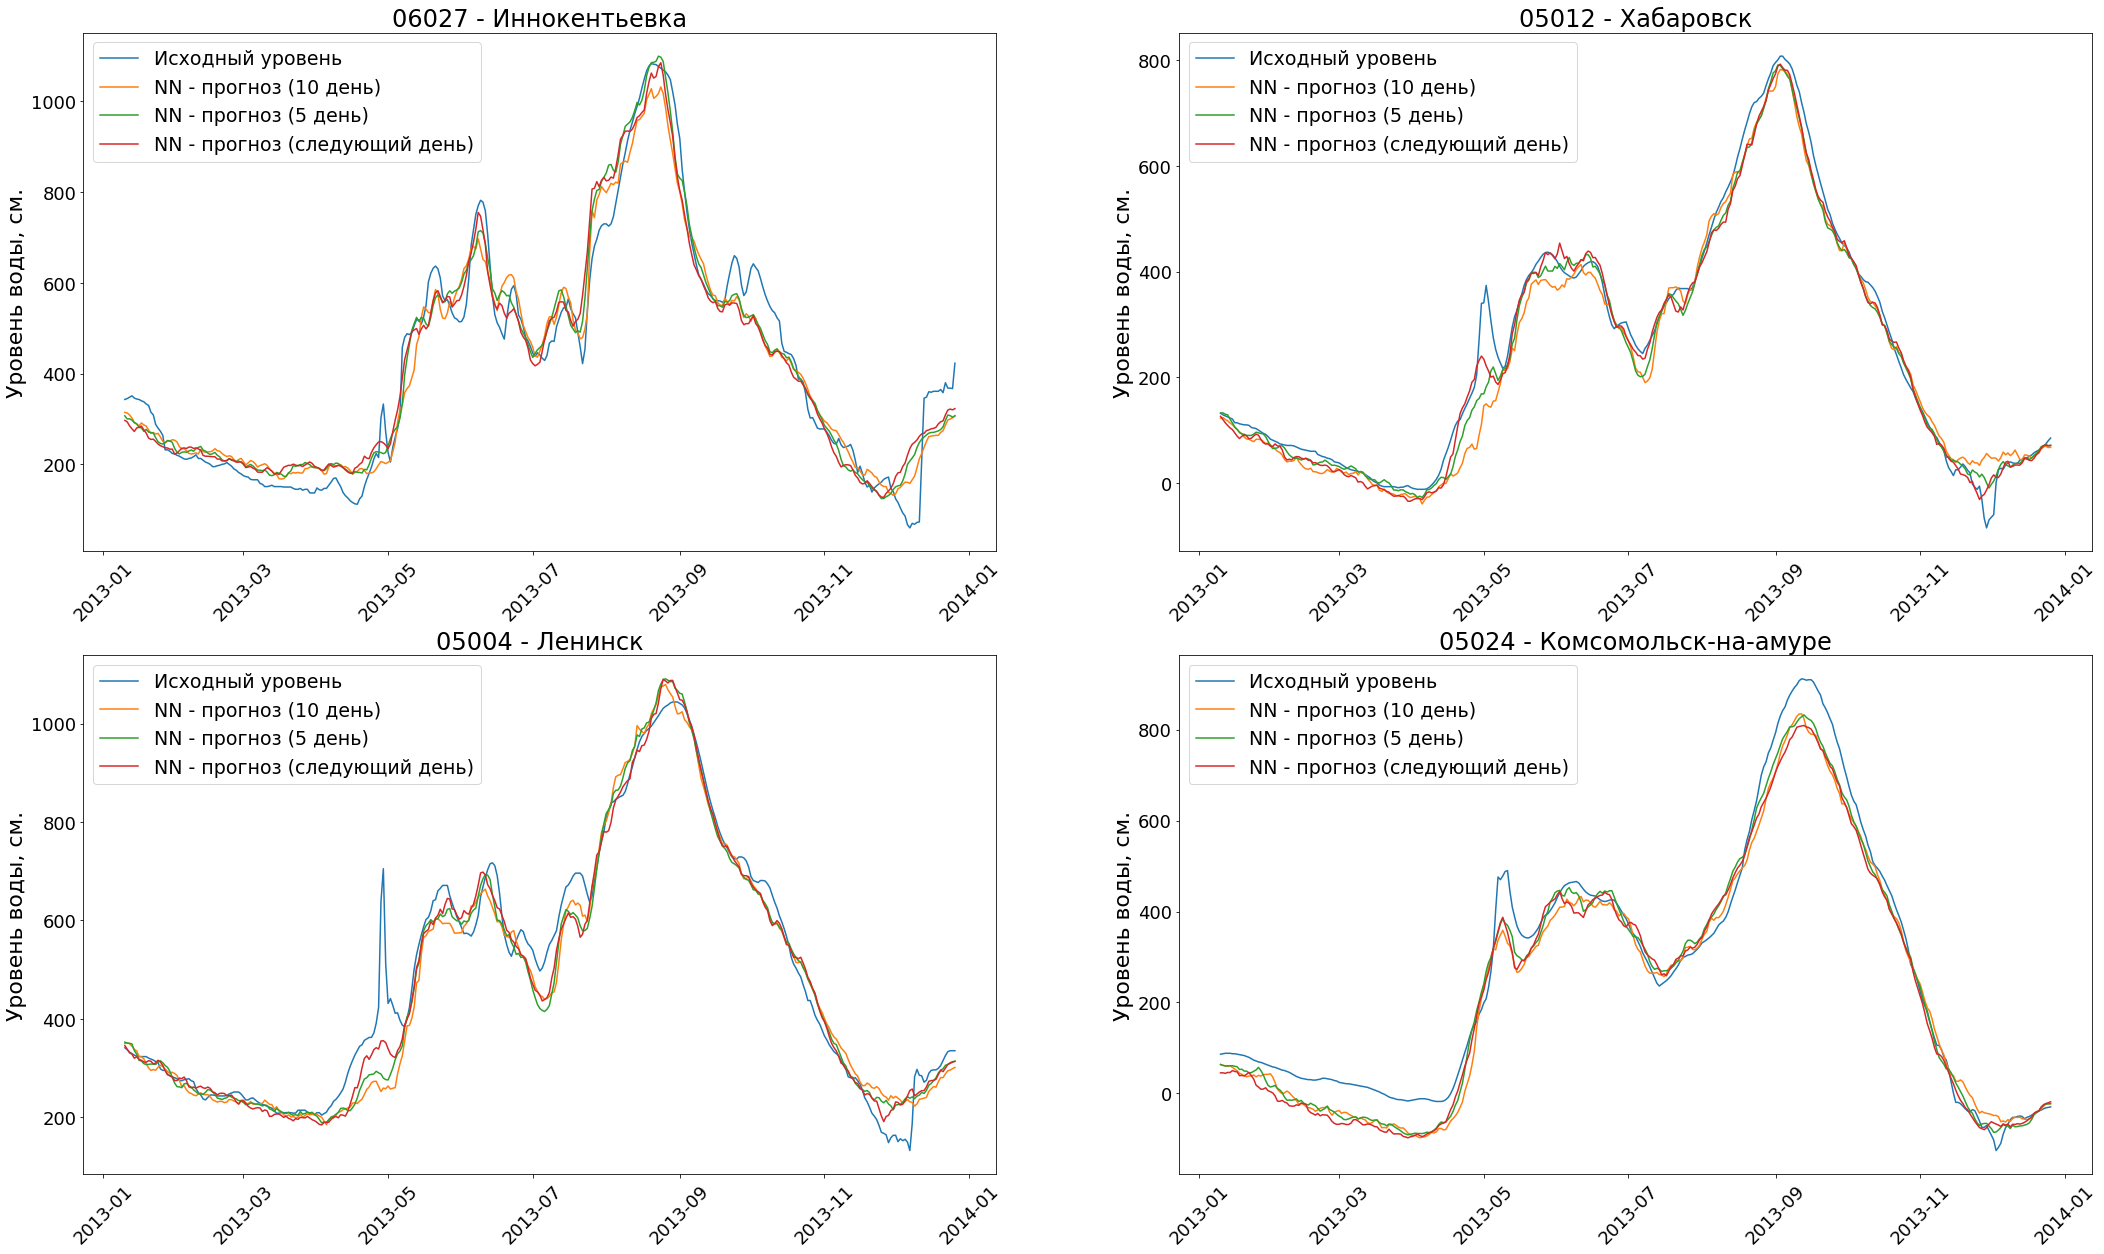

In [65]:
fig,axes = plt.subplots(2,2,figsize=(36,21))
plot_df = results_df.copy()
plot_df.sort_values('date',inplace=True)

x_n = 0
y_n = 0
for i in ['06027','05012','05004','05024']:
    ax = axes[x_n,y_n]
    name = i + ' - ' + hydro.loc[i,'name'][0:hydro.loc[i,'name'].find('(')].capitalize()
    if i == '06027':
        name += 'а'
    elif i == '05012':
        name += 'к'
    elif i == '05024':
        name += 'е'
    ax.set_title(name,fontsize=24)
    ax.plot(plot_df['date'],plot_df['sealevel_max_' + i],label='Исходный уровень')
    ax.plot(plot_df['date'],plot_df[i + '_nn-day-10'],label='NN - прогноз (10 день)')
    ax.plot(plot_df['date'],plot_df[i + '_nn-day-5'],label='NN - прогноз (5 день)')
    ax.plot(plot_df['date'],plot_df[i + '_nn-day-1'],label='NN - прогноз (следующий день)')
    ax.tick_params(axis='x', rotation=45,labelsize=18)
    ax.set_ylabel('Уровень воды, см.',fontsize=22)
    ax.tick_params(axis='y', labelsize=18)
    ax.legend(fontsize=19)
    y_n += 1
    if y_n >= 2:
        y_n = 0
        x_n += 1
plt.savefig('NN - результаты 2013.png')

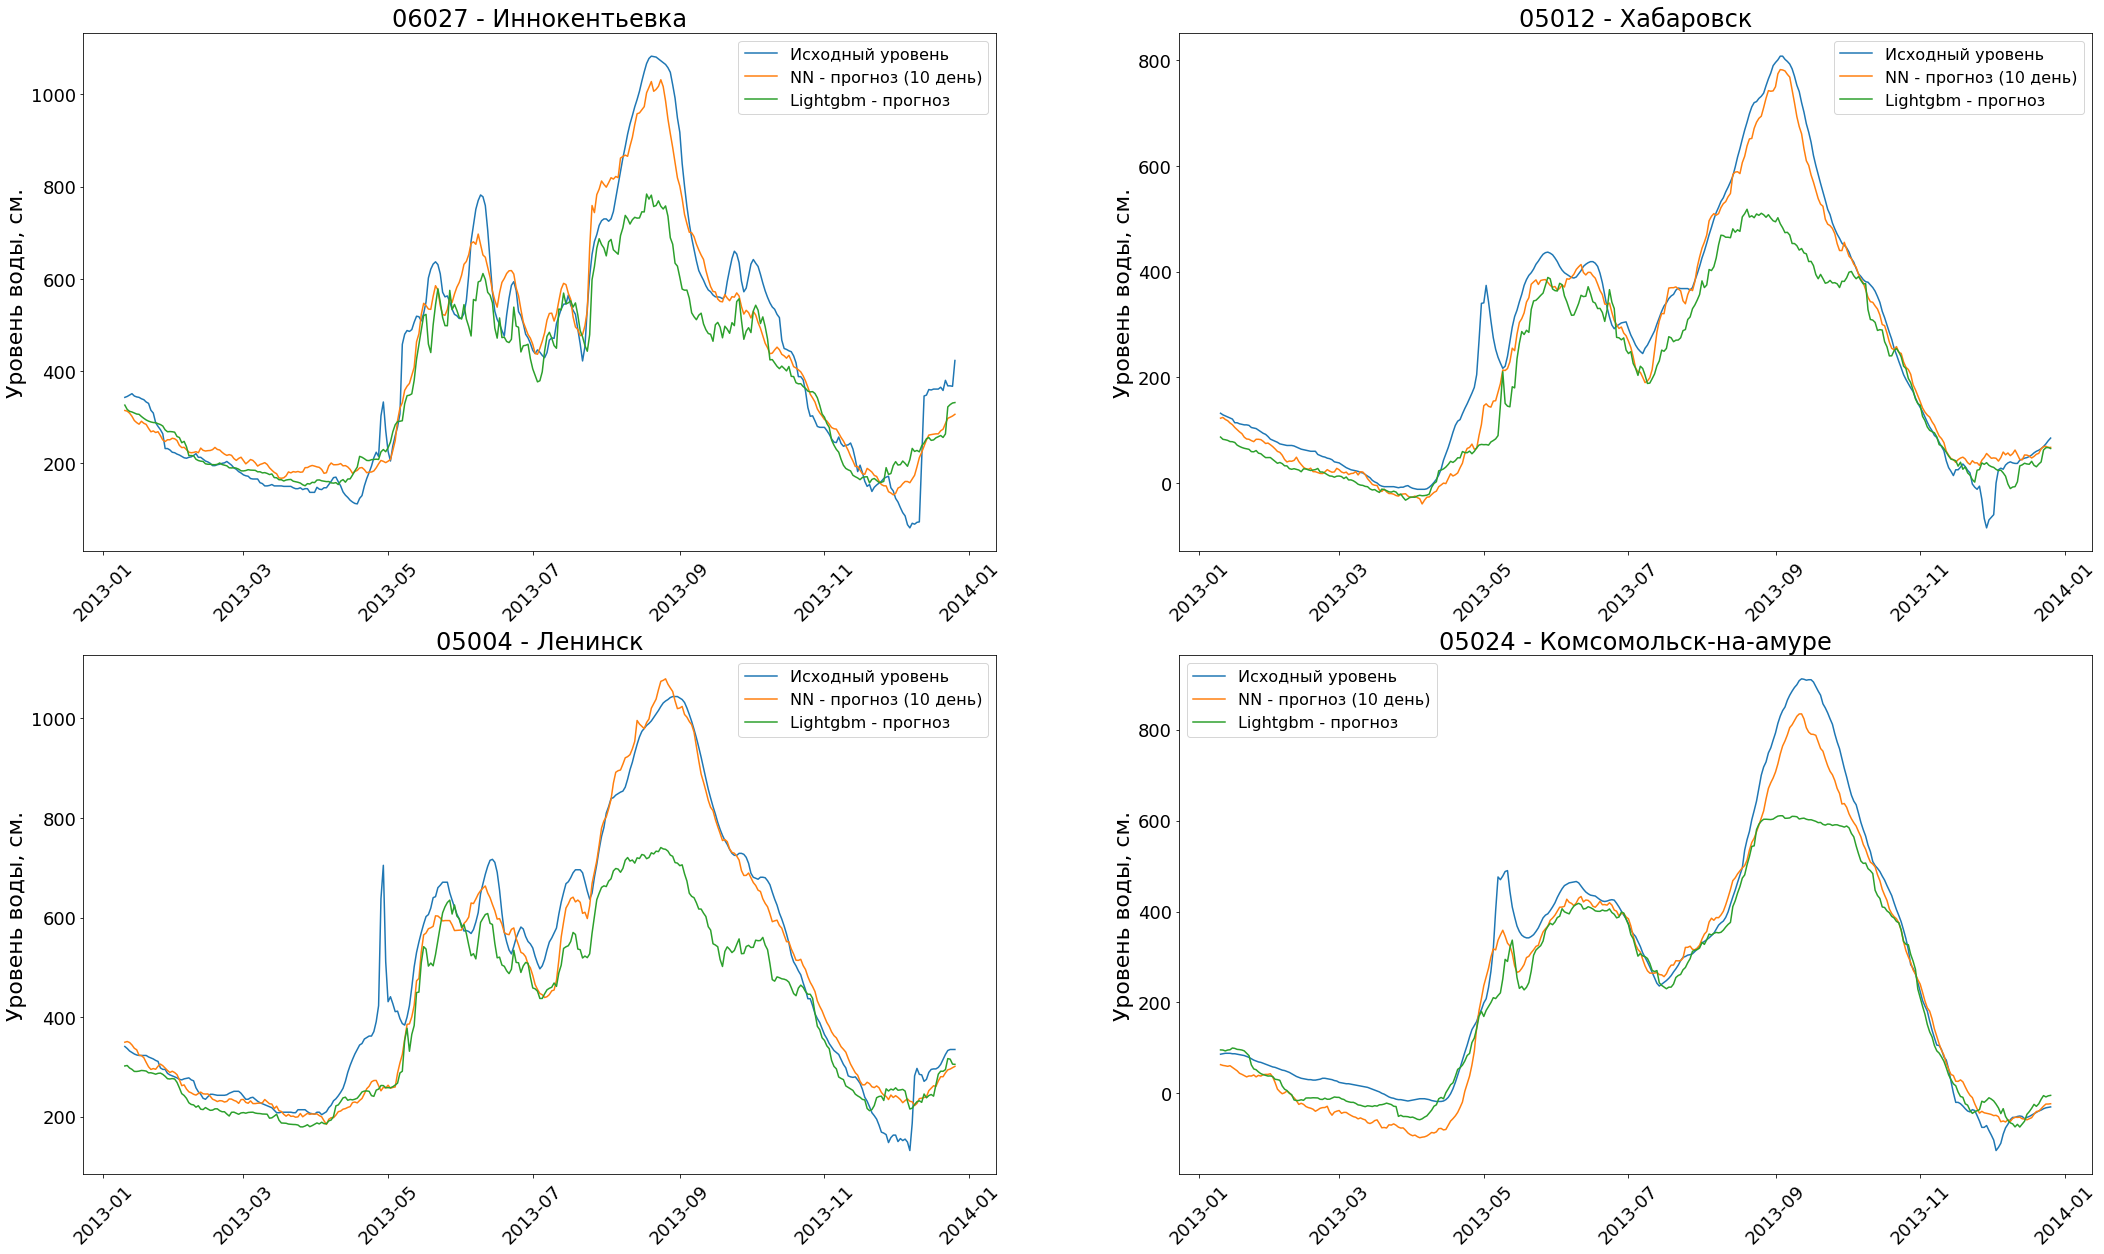

In [66]:
fig,axes = plt.subplots(2,2,figsize=(36,21))
plot_df = results_df.copy()
plot_df.sort_values('date',inplace=True)

x_n = 0
y_n = 0
for i in ['06027','05012','05004','05024']:
    ax = axes[x_n,y_n]
    name = i + ' - ' + hydro.loc[i,'name'][0:hydro.loc[i,'name'].find('(')].capitalize()
    if i == '06027':
        name += 'а'
    elif i == '05012':
        name += 'к'
    elif i == '05024':
        name += 'е'
    ax.set_title(name,fontsize=24)
    ax.plot(plot_df['date'],plot_df['sealevel_max_' + i],label='Исходный уровень')
    ax.plot(plot_df['date'],plot_df[i + '_nn-day-10'],label='NN - прогноз (10 день)')
    ax.plot(plot_df['date'],plot_df[i + '_lgb'],label='Lightgbm - прогноз')
    ax.tick_params(axis='x', rotation=45,labelsize=18)
    ax.set_ylabel('Уровень воды, см.',fontsize=22)
    ax.tick_params(axis='y', labelsize=18)
    ax.legend(fontsize=16)
    y_n += 1
    if y_n >= 2:
        y_n = 0
        x_n += 1
plt.savefig('Сравнение - NN-lightgbm.png')


In [67]:
inputs = prepare_data_new(amur_df, start_date='2013-01-01', end_date='2017-12-31')

model = build_model()
try:
    model.load_weights('git\\data\\weights-aij2020amurlevel-2012.h5')
except:
    model.load_weights('data\\weights-aij2020amurlevel-2012.h5')
preds = model.predict(inputs)
results_1_df = pd.DataFrame({'date': pd.date_range('2013-01-01', pd.to_datetime('2017-12-22') - timedelta(days=1), freq='1D')})

for i in range(NUMBER_OF_INFERENCE_STATIONS):
    results_1_df[ALL_STATIONS[i]+'_nn-day-1'] = preds[:, 0,i]
    
results_5_df = pd.DataFrame({'date': pd.date_range('2013-01-05', pd.to_datetime('2017-12-26') - timedelta(days=1), freq='1D')})

for i in range(NUMBER_OF_INFERENCE_STATIONS):
    results_5_df[ALL_STATIONS[i]+'_nn-day-5'] = preds[:, 4,i]

results_10_df = pd.DataFrame({'date': pd.date_range('2013-01-10', pd.to_datetime('2017-12-31') - timedelta(days=1), freq='1D')})
for i in range(NUMBER_OF_INFERENCE_STATIONS):
    results_10_df[ALL_STATIONS[i]+'_nn-day-10'] = preds[:, 9,i]
    
results_df = results_1_df.merge(results_5_df,on='date')
results_df = results_df.merge(results_10_df,on='date')
    

    
lgb_results_df = pd.DataFrame({'date': pd.date_range('2013-01-01', pd.to_datetime('2017-12-22') - timedelta(days=1), freq='1D')})

for i in range(NUMBER_OF_INFERENCE_STATIONS):
    print(i)
    model = lgb.Booster(model_file=f'lgb-{ALL_STATIONS[i]}.lgb')
    preds = model.predict(amur_df[(amur_df['date'] >= '2013-01-01') & 
                                 (amur_df['date'] < '2017-12-22')][NUMERICAL_FEATURES+CATEGORICAL_FEATURES])
    lgb_results_df[ALL_STATIONS[i]+'_lgb'] = preds


results_df = results_df.merge(lgb_results_df,on='date')
    
true_df = amur_df[['sealevel_max_' + col for col in ALL_STATIONS[0:NUMBER_OF_INFERENCE_STATIONS]] + ['date']].copy()
true_df = true_df[(true_df['date'] >= '2013-01-01') & (true_df['date'] < '2017-12-27')]
true_df['date'] = pd.to_datetime(true_df['date'])
results_df = results_df.merge(true_df,on='date')

0
1
2
3
4
5
6
7


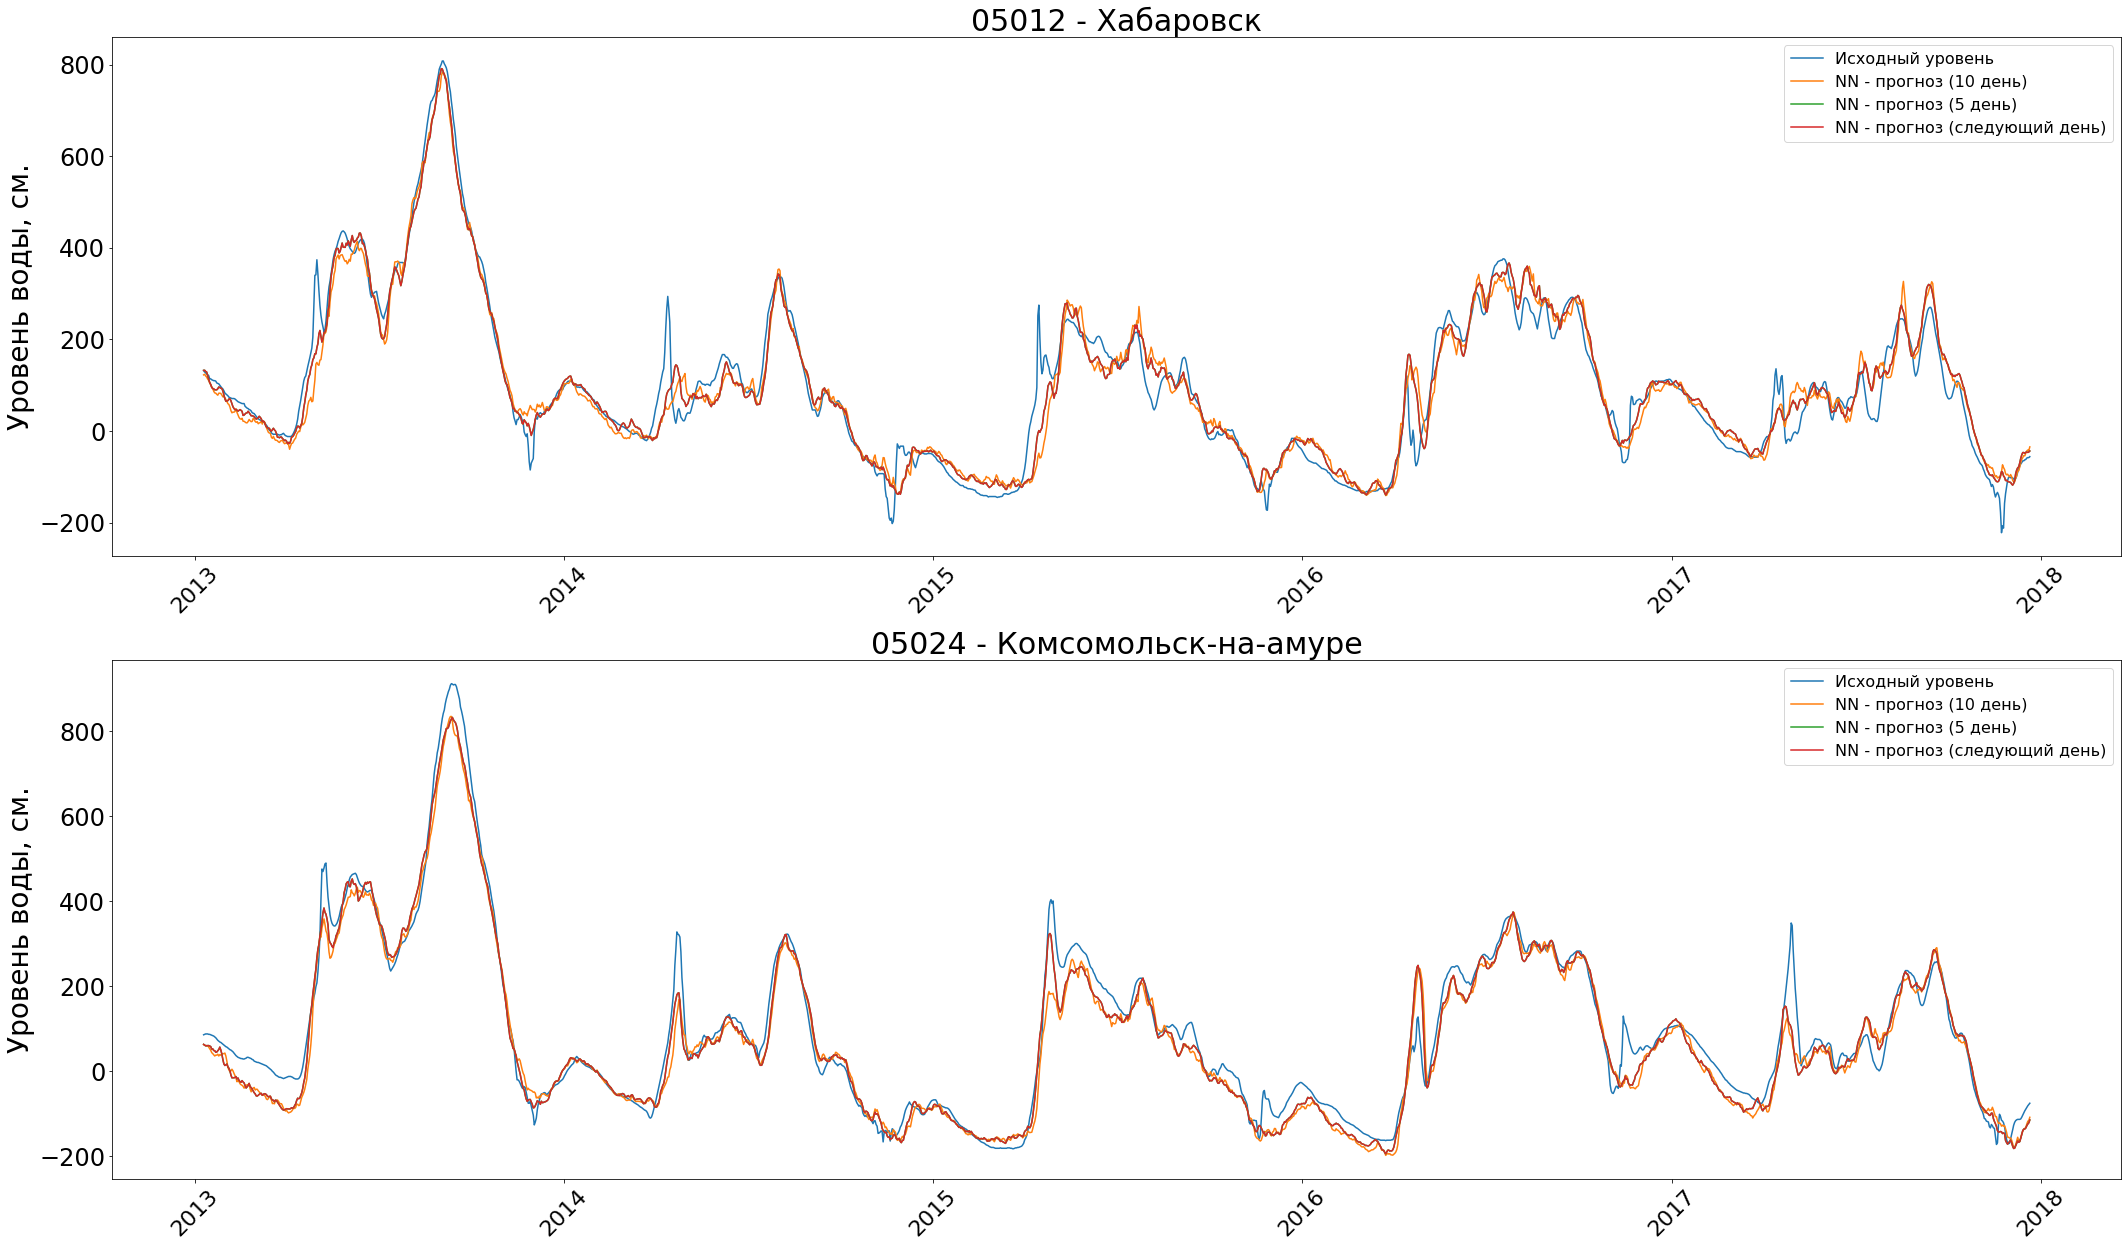

In [68]:
fig,axes = plt.subplots(figsize=(36,21),nrows=2)
plot_df = results_df.copy()
plot_df.sort_values('date',inplace=True)

y_n = 0
for i in ['05012','05024']:
    ax = axes[y_n]
    name = i + ' - ' + hydro.loc[i,'name'][0:hydro.loc[i,'name'].find('(')].capitalize()
    if i == '05012':
        name += 'к'
    elif i == '05024':
        name += 'е'
    ax.set_title(name,fontsize=30)
    ax.plot(plot_df['date'],plot_df['sealevel_max_' + i],label='Исходный уровень')
    ax.plot(plot_df['date'],plot_df[i + '_nn-day-10'],label='NN - прогноз (10 день)')
    ax.plot(plot_df['date'],plot_df[i + '_nn-day-5'],label='NN - прогноз (5 день)')
    ax.plot(plot_df['date'],plot_df[i + '_nn-day-5'],label='NN - прогноз (следующий день)')
    ax.tick_params(axis='x', rotation=45,labelsize=22)
    ax.set_ylabel('Уровень воды, см.',fontsize=28)
    ax.tick_params(axis='y', labelsize=24)
    ax.legend(fontsize=16)
    y_n += 1

plt.savefig('NN - прогноз на 5 лет.png')